# Building dataset inspection

## Introduction

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

In [26]:
from mrcnn import utils
from mrcnn import model as modellib
from mrcnn.model import log
from mrcnn.config import Config
from mrcnn import visualize

In [3]:
from tanzania_challenge import buildings, generator

In [4]:
from importlib import reload

## Configuration preparation

In [5]:
class BuildingsConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "buildings"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 3  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 384
    IMAGE_MAX_DIM = 384

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = BuildingsConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  384
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  384
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [384 384   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [6]:
DATAPATH = os.path.join("..", "data", "open_ai_tanzania", "preprocessed")
MODEL_DIR = os.path.join("..", "data", "open_ai_tanzania", "output", "instance_segmentation", "checkpoints")

In [7]:
os.listdir(os.path.join(DATAPATH, str(config.IMAGE_MIN_DIM)))

['training', 'validation']

## Dataset displaying

In [8]:
reload(buildings)

<module 'tanzania_challenge.buildings' from '/home/rde/src/tanzania_challenge/tanzania_challenge/buildings.py'>

In [9]:
train_bd = buildings.BuildingDataset()
val_bd = buildings.BuildingDataset()
train_bd.load_buildings(DATAPATH, subset="training", img_size=config.IMAGE_MIN_DIM)
val_bd.load_buildings(DATAPATH, subset="validation", img_size=config.IMAGE_MIN_DIM)

In [10]:
print(len(train_bd.image_info))
train_bd.image_info[0]

9935


{'id': 0,
 'source': 'building',
 'path': '../data/open_ai_tanzania/preprocessed/384/training/images/grid_035_384_384_26112_6528.tif',
 'name': 'grid_035_384_384_26112_6528.tif',
 'raw_image_path': '../data/input/images/grid_035.tif',
 'feature_path': '../data/open_ai_tanzania/preprocessed/384/training/features/grid_035_384_384_26112_6528.json',
 'item_path': '../data/open_ai_tanzania/preprocessed/384/training/items/grid_035_384_384_26112_6528.json',
 'width': 384,
 'height': 384}

In [11]:
mask, class_ids = train_bd.load_mask(0)

In [12]:
print(len(mask))
print(class_ids)

384
[3]


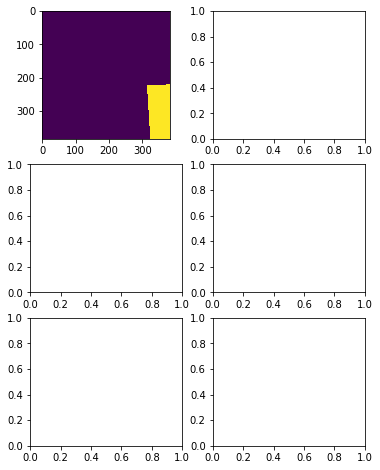

In [13]:
f, ax = plt.subplots(3, 2, figsize=(6, 8))
for i in range(class_ids.shape[0]):
    ax[int(i/2)][int(i%2)].imshow(mask[:, :, i])

In [14]:
print(len(val_bd.image_info))
val_bd.image_info[0]

934


{'id': 0,
 'source': 'building',
 'path': '../data/open_ai_tanzania/preprocessed/384/validation/images/grid_050_384_384_28032_5376.tif',
 'name': 'grid_050_384_384_28032_5376.tif',
 'raw_image_path': '../data/input/images/grid_050.tif',
 'feature_path': '../data/open_ai_tanzania/preprocessed/384/validation/features/grid_050_384_384_28032_5376.json',
 'item_path': '../data/open_ai_tanzania/preprocessed/384/validation/items/grid_050_384_384_28032_5376.json',
 'width': 384,
 'height': 384}

In [15]:
mask, class_ids = val_bd.load_mask(0)

In [16]:
class_ids

array([1], dtype=uint8)

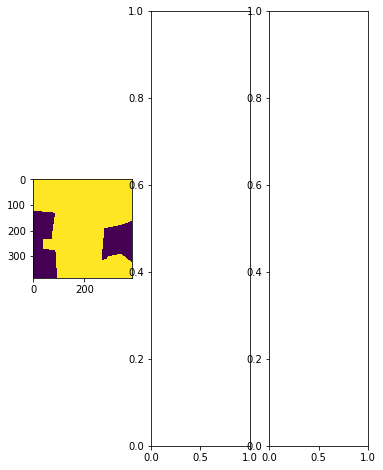

In [17]:
f, ax = plt.subplots(1, 3, figsize=(6, 8))
for i in range(class_ids.shape[0]):
    ax[int(i%3)].imshow(mask[:, :, i])

In [18]:
train_bd.prepare()
val_bd.prepare()

### Model training

In [19]:
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [104]:
model.load_weights("../../Mask_RCNN/mask_rcnn_coco.h5", by_name=True,
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                            "mrcnn_bbox", "mrcnn_mask"])

In [105]:
model.train(train_dataset=train_bd, val_dataset=val_bd, 
            learning_rate=config.LEARNING_RATE, 
            epochs=30, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: ../data/open_ai_tanzania/output/instance_segmentation/checkpoints/buildings20181016T1550/mask_rcnn_buildings_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/keras/engine/training_generator.py:46: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserW

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

Epoch 1/30


/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

  4/100 [>.............................] - ETA: 3:06 - loss: 4.9709 - rpn_class_loss: 0.0976 - rpn_bbox_loss: 1.5849 - mrcnn_class_loss: 1.1172 - mrcnn_bbox_loss: 1.3865 - mrcnn_mask_loss: 0.7846

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

  8/100 [=>............................] - ETA: 1:35 - loss: 4.5331 - rpn_class_loss: 0.1000 - rpn_bbox_loss: 1.6041 - mrcnn_class_loss: 0.9417 - mrcnn_bbox_loss: 1.2538 - mrcnn_mask_loss: 0.6337

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 12/100 [==>...........................] - ETA: 1:05 - loss: 4.2619 - rpn_class_loss: 0.0843 - rpn_bbox_loss: 1.4383 - mrcnn_class_loss: 0.8653 - mrcnn_bbox_loss: 1.2399 - mrcnn_mask_loss: 0.6341

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 16/100 [===>..........................] - ETA: 49s - loss: 4.2743 - rpn_class_loss: 0.0849 - rpn_bbox_loss: 1.4338 - mrcnn_class_loss: 0.7834 - mrcnn_bbox_loss: 1.1984 - mrcnn_mask_loss: 0.7737

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 20/100 [=====>........................] - ETA: 39s - loss: 4.2413 - rpn_class_loss: 0.0822 - rpn_bbox_loss: 1.7580 - mrcnn_class_loss: 0.6623 - mrcnn_bbox_loss: 1.0586 - mrcnn_mask_loss: 0.6801

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 24/100 [======>.......................] - ETA: 33s - loss: 4.0781 - rpn_class_loss: 0.0782 - rpn_bbox_loss: 1.6539 - mrcnn_class_loss: 0.6080 - mrcnn_bbox_loss: 1.0834 - mrcnn_mask_loss: 0.6546

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 28/100 [=======>......................] - ETA: 28s - loss: 4.1253 - rpn_class_loss: 0.0767 - rpn_bbox_loss: 1.7224 - mrcnn_class_loss: 0.5753 - mrcnn_bbox_loss: 1.1031 - mrcnn_mask_loss: 0.6478

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 32/100 [========>.....................] - ETA: 24s - loss: 4.1061 - rpn_class_loss: 0.0744 - rpn_bbox_loss: 1.8201 - mrcnn_class_loss: 0.5543 - mrcnn_bbox_loss: 1.0445 - mrcnn_mask_loss: 0.6128

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 36/100 [=========>....................] - ETA: 21s - loss: 4.0061 - rpn_class_loss: 0.0715 - rpn_bbox_loss: 1.7579 - mrcnn_class_loss: 0.5395 - mrcnn_bbox_loss: 1.0388 - mrcnn_mask_loss: 0.5985

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 40/100 [===========>..................] - ETA: 18s - loss: 3.8873 - rpn_class_loss: 0.0691 - rpn_bbox_loss: 1.7326 - mrcnn_class_loss: 0.5207 - mrcnn_bbox_loss: 0.9936 - mrcnn_mask_loss: 0.5713

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 44/100 [============>.................] - ETA: 16s - loss: 3.8185 - rpn_class_loss: 0.0686 - rpn_bbox_loss: 1.7150 - mrcnn_class_loss: 0.4966 - mrcnn_bbox_loss: 0.9759 - mrcnn_mask_loss: 0.5624

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 48/100 [=============>................] - ETA: 14s - loss: 3.7473 - rpn_class_loss: 0.0681 - rpn_bbox_loss: 1.6620 - mrcnn_class_loss: 0.5064 - mrcnn_bbox_loss: 0.9653 - mrcnn_mask_loss: 0.5455

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 52/100 [==============>...............] - ETA: 13s - loss: 3.6911 - rpn_class_loss: 0.0661 - rpn_bbox_loss: 1.6725 - mrcnn_class_loss: 0.4759 - mrcnn_bbox_loss: 0.9452 - mrcnn_mask_loss: 0.5314

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 56/100 [===============>..............] - ETA: 11s - loss: 3.6414 - rpn_class_loss: 0.0652 - rpn_bbox_loss: 1.6318 - mrcnn_class_loss: 0.4897 - mrcnn_bbox_loss: 0.9308 - mrcnn_mask_loss: 0.5239

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 60/100 [=================>............] - ETA: 10s - loss: 3.6334 - rpn_class_loss: 0.0643 - rpn_bbox_loss: 1.6497 - mrcnn_class_loss: 0.4902 - mrcnn_bbox_loss: 0.9112 - mrcnn_mask_loss: 0.5181

ERROR:root:Error processing image {'id': 1282, 'source': 'building', 'path': '../data/open_ai_tanzania/preprocessed/384/training/images/grid_001_384_384_14976_8832.tif', 'name': 'grid_001_384_384_14976_8832.tif', 'raw_image_path': '../data/input/images/grid_001.tif', 'feature_path': '../data/open_ai_tanzania/preprocessed/384/training/features/grid_001_384_384_14976_8832.json', 'item_path': '../data/open_ai_tanzania/preprocessed/384/training/items/grid_001_384_384_14976_8832.json', 'width': 384, 'height': 384}
Traceback (most recent call last):
  File "/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/mrcnn/model.py", line 1717, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/mrcnn/model.py", line 1219, in load_image_gt
    mask, class_ids = dataset.load_mask(image_id)
  File "/home/rde/src/tanzania_challenge/tanzania_challenge/buildings.py", line 72, in load_mask
    for k, v in items.items()]
  File "/home

 64/100 [==================>...........] - ETA: 8s - loss: 3.5758 - rpn_class_loss: 0.0621 - rpn_bbox_loss: 1.6528 - mrcnn_class_loss: 0.4671 - mrcnn_bbox_loss: 0.8951 - mrcnn_mask_loss: 0.4988

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 68/100 [===================>..........] - ETA: 7s - loss: 3.5243 - rpn_class_loss: 0.0602 - rpn_bbox_loss: 1.6200 - mrcnn_class_loss: 0.4612 - mrcnn_bbox_loss: 0.8907 - mrcnn_mask_loss: 0.4923

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 72/100 [====================>.........] - ETA: 6s - loss: 3.4806 - rpn_class_loss: 0.0587 - rpn_bbox_loss: 1.5949 - mrcnn_class_loss: 0.4565 - mrcnn_bbox_loss: 0.8833 - mrcnn_mask_loss: 0.4873

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 76/100 [=====================>........] - ETA: 5s - loss: 3.4027 - rpn_class_loss: 0.0574 - rpn_bbox_loss: 1.5736 - mrcnn_class_loss: 0.4422 - mrcnn_bbox_loss: 0.8581 - mrcnn_mask_loss: 0.4714

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 80/100 [=======================>......] - ETA: 4s - loss: 3.3673 - rpn_class_loss: 0.0564 - rpn_bbox_loss: 1.5455 - mrcnn_class_loss: 0.4406 - mrcnn_bbox_loss: 0.8523 - mrcnn_mask_loss: 0.4725

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 84/100 [========================>.....] - ETA: 3s - loss: 3.2998 - rpn_class_loss: 0.0546 - rpn_bbox_loss: 1.5109 - mrcnn_class_loss: 0.4309 - mrcnn_bbox_loss: 0.8396 - mrcnn_mask_loss: 0.4638

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 88/100 [=========================>....] - ETA: 2s - loss: 3.2675 - rpn_class_loss: 0.0530 - rpn_bbox_loss: 1.5152 - mrcnn_class_loss: 0.4197 - mrcnn_bbox_loss: 0.8204 - mrcnn_mask_loss: 0.4592

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 92/100 [==========================>...] - ETA: 1s - loss: 3.2590 - rpn_class_loss: 0.0521 - rpn_bbox_loss: 1.5339 - mrcnn_class_loss: 0.4145 - mrcnn_bbox_loss: 0.8057 - mrcnn_mask_loss: 0.4527

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 96/100 [===========================>..] - ETA: 0s - loss: 3.2550 - rpn_class_loss: 0.0509 - rpn_bbox_loss: 1.5609 - mrcnn_class_loss: 0.4053 - mrcnn_bbox_loss: 0.7924 - mrcnn_mask_loss: 0.4454

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 99/100 [============================>.] - ETA: 0s - loss: 3.2407 - rpn_class_loss: 0.0509 - rpn_bbox_loss: 1.5513 - mrcnn_class_loss: 0.4093 - mrcnn_bbox_loss: 0.7864 - mrcnn_mask_loss: 0.4428

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


100/100 [==============================] - 23s 230ms/step - loss: 3.2287 - rpn_class_loss: 0.0506 - rpn_bbox_loss: 1.5421 - mrcnn_class_loss: 0.4058 - mrcnn_bbox_loss: 0.7876 - mrcnn_mask_loss: 0.4425 - val_loss: 2.2266 - val_rpn_class_loss: 0.0194 - val_rpn_bbox_loss: 1.3298 - val_mrcnn_class_loss: 0.1029 - val_mrcnn_bbox_loss: 0.5490 - val_mrcnn_mask_loss: 0.2255


/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

Epoch 2/30
  4/100 [>.............................] - ETA: 12s - loss: 2.3767 - rpn_class_loss: 0.0269 - rpn_bbox_loss: 1.1655 - mrcnn_class_loss: 0.2715 - mrcnn_bbox_loss: 0.6272 - mrcnn_mask_loss: 0.2856

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

  8/100 [=>............................] - ETA: 12s - loss: 2.6044 - rpn_class_loss: 0.0247 - rpn_bbox_loss: 1.3228 - mrcnn_class_loss: 0.2543 - mrcnn_bbox_loss: 0.6445 - mrcnn_mask_loss: 0.3581

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 12/100 [==>...........................] - ETA: 11s - loss: 2.6005 - rpn_class_loss: 0.0306 - rpn_bbox_loss: 1.3281 - mrcnn_class_loss: 0.2568 - mrcnn_bbox_loss: 0.6293 - mrcnn_mask_loss: 0.3556

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 16/100 [===>..........................] - ETA: 11s - loss: 2.6098 - rpn_class_loss: 0.0349 - rpn_bbox_loss: 1.3040 - mrcnn_class_loss: 0.2665 - mrcnn_bbox_loss: 0.6218 - mrcnn_mask_loss: 0.3827

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 20/100 [=====>........................] - ETA: 10s - loss: 2.8046 - rpn_class_loss: 0.0325 - rpn_bbox_loss: 1.4640 - mrcnn_class_loss: 0.2736 - mrcnn_bbox_loss: 0.6249 - mrcnn_mask_loss: 0.4095

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 24/100 [======>.......................] - ETA: 10s - loss: 2.7088 - rpn_class_loss: 0.0313 - rpn_bbox_loss: 1.4084 - mrcnn_class_loss: 0.2704 - mrcnn_bbox_loss: 0.6012 - mrcnn_mask_loss: 0.3975

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 28/100 [=======>......................] - ETA: 9s - loss: 2.6971 - rpn_class_loss: 0.0320 - rpn_bbox_loss: 1.3994 - mrcnn_class_loss: 0.2846 - mrcnn_bbox_loss: 0.5880 - mrcnn_mask_loss: 0.3931

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 32/100 [========>.....................] - ETA: 8s - loss: 2.6881 - rpn_class_loss: 0.0306 - rpn_bbox_loss: 1.3801 - mrcnn_class_loss: 0.2881 - mrcnn_bbox_loss: 0.5998 - mrcnn_mask_loss: 0.3895

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 36/100 [=========>....................] - ETA: 8s - loss: 2.5985 - rpn_class_loss: 0.0313 - rpn_bbox_loss: 1.3155 - mrcnn_class_loss: 0.2879 - mrcnn_bbox_loss: 0.5815 - mrcnn_mask_loss: 0.3823

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 40/100 [===========>..................] - ETA: 7s - loss: 2.7095 - rpn_class_loss: 0.0305 - rpn_bbox_loss: 1.3577 - mrcnn_class_loss: 0.3197 - mrcnn_bbox_loss: 0.6054 - mrcnn_mask_loss: 0.3961

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 44/100 [============>.................] - ETA: 7s - loss: 2.6833 - rpn_class_loss: 0.0305 - rpn_bbox_loss: 1.3293 - mrcnn_class_loss: 0.3161 - mrcnn_bbox_loss: 0.6039 - mrcnn_mask_loss: 0.4035

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 48/100 [=============>................] - ETA: 6s - loss: 2.6345 - rpn_class_loss: 0.0302 - rpn_bbox_loss: 1.3010 - mrcnn_class_loss: 0.3181 - mrcnn_bbox_loss: 0.5931 - mrcnn_mask_loss: 0.3922

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 52/100 [==============>...............] - ETA: 6s - loss: 2.6278 - rpn_class_loss: 0.0295 - rpn_bbox_loss: 1.2879 - mrcnn_class_loss: 0.3142 - mrcnn_bbox_loss: 0.5962 - mrcnn_mask_loss: 0.4001

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 56/100 [===============>..............] - ETA: 5s - loss: 2.6838 - rpn_class_loss: 0.0298 - rpn_bbox_loss: 1.3209 - mrcnn_class_loss: 0.3163 - mrcnn_bbox_loss: 0.6042 - mrcnn_mask_loss: 0.4126

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 60/100 [=================>............] - ETA: 5s - loss: 2.6969 - rpn_class_loss: 0.0301 - rpn_bbox_loss: 1.3396 - mrcnn_class_loss: 0.3224 - mrcnn_bbox_loss: 0.5953 - mrcnn_mask_loss: 0.4096

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 64/100 [==================>...........] - ETA: 4s - loss: 2.7328 - rpn_class_loss: 0.0304 - rpn_bbox_loss: 1.3310 - mrcnn_class_loss: 0.3332 - mrcnn_bbox_loss: 0.6233 - mrcnn_mask_loss: 0.4149

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 68/100 [===================>..........] - ETA: 4s - loss: 2.7203 - rpn_class_loss: 0.0308 - rpn_bbox_loss: 1.3130 - mrcnn_class_loss: 0.3380 - mrcnn_bbox_loss: 0.6255 - mrcnn_mask_loss: 0.4130

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 72/100 [====================>.........] - ETA: 3s - loss: 2.7248 - rpn_class_loss: 0.0303 - rpn_bbox_loss: 1.3319 - mrcnn_class_loss: 0.3377 - mrcnn_bbox_loss: 0.6171 - mrcnn_mask_loss: 0.4078

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 76/100 [=====================>........] - ETA: 3s - loss: 2.7821 - rpn_class_loss: 0.0302 - rpn_bbox_loss: 1.3833 - mrcnn_class_loss: 0.3337 - mrcnn_bbox_loss: 0.6211 - mrcnn_mask_loss: 0.4137

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 80/100 [=======================>......] - ETA: 2s - loss: 2.7651 - rpn_class_loss: 0.0305 - rpn_bbox_loss: 1.3722 - mrcnn_class_loss: 0.3382 - mrcnn_bbox_loss: 0.6130 - mrcnn_mask_loss: 0.4112

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 84/100 [========================>.....] - ETA: 2s - loss: 2.7242 - rpn_class_loss: 0.0302 - rpn_bbox_loss: 1.3464 - mrcnn_class_loss: 0.3351 - mrcnn_bbox_loss: 0.6106 - mrcnn_mask_loss: 0.4018

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 87/100 [=========================>....] - ETA: 1s - loss: 2.7343 - rpn_class_loss: 0.0297 - rpn_bbox_loss: 1.3555 - mrcnn_class_loss: 0.3398 - mrcnn_bbox_loss: 0.6088 - mrcnn_mask_loss: 0.4006

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 90/100 [==========================>...] - ETA: 1s - loss: 2.7357 - rpn_class_loss: 0.0297 - rpn_bbox_loss: 1.3719 - mrcnn_class_loss: 0.3377 - mrcnn_bbox_loss: 0.6005 - mrcnn_mask_loss: 0.3959

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 94/100 [===========================>..] - ETA: 0s - loss: 2.7123 - rpn_class_loss: 0.0295 - rpn_bbox_loss: 1.3646 - mrcnn_class_loss: 0.3321 - mrcnn_bbox_loss: 0.5929 - mrcnn_mask_loss: 0.3933

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 98/100 [============================>.] - ETA: 0s - loss: 2.7096 - rpn_class_loss: 0.0291 - rpn_bbox_loss: 1.3524 - mrcnn_class_loss: 0.3352 - mrcnn_bbox_loss: 0.5945 - mrcnn_mask_loss: 0.3984

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 99/100 [============================>.] - ETA: 0s - loss: 2.7157 - rpn_class_loss: 0.0293 - rpn_bbox_loss: 1.3533 - mrcnn_class_loss: 0.3388 - mrcnn_bbox_loss: 0.5943 - mrcnn_mask_loss: 0.4000

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

100/100 [==============================] - 14s 136ms/step - loss: 2.7059 - rpn_class_loss: 0.0293 - rpn_bbox_loss: 1.3472 - mrcnn_class_loss: 0.3397 - mrcnn_bbox_loss: 0.5914 - mrcnn_mask_loss: 0.3982 - val_loss: 2.5350 - val_rpn_class_loss: 0.0215 - val_rpn_bbox_loss: 1.1493 - val_mrcnn_class_loss: 0.2133 - val_mrcnn_bbox_loss: 0.6283 - val_mrcnn_mask_loss: 0.5227
Epoch 3/30
  2/100 [..............................] - ETA: 11s - loss: 2.3152 - rpn_class_loss: 0.0240 - rpn_bbox_loss: 0.8136 - mrcnn_class_loss: 0.6046 - mrcnn_bbox_loss: 0.4713 - mrcnn_mask_loss: 0.4017

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

  6/100 [>.............................] - ETA: 12s - loss: 2.2907 - rpn_class_loss: 0.0332 - rpn_bbox_loss: 0.9650 - mrcnn_class_loss: 0.4416 - mrcnn_bbox_loss: 0.4583 - mrcnn_mask_loss: 0.3926

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 10/100 [==>...........................] - ETA: 11s - loss: 2.5147 - rpn_class_loss: 0.0332 - rpn_bbox_loss: 1.0720 - mrcnn_class_loss: 0.3885 - mrcnn_bbox_loss: 0.5807 - mrcnn_mask_loss: 0.4404

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 14/100 [===>..........................] - ETA: 11s - loss: 2.7052 - rpn_class_loss: 0.0317 - rpn_bbox_loss: 1.3860 - mrcnn_class_loss: 0.3657 - mrcnn_bbox_loss: 0.5403 - mrcnn_mask_loss: 0.3815

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 18/100 [====>.........................] - ETA: 10s - loss: 2.6000 - rpn_class_loss: 0.0277 - rpn_bbox_loss: 1.2545 - mrcnn_class_loss: 0.3410 - mrcnn_bbox_loss: 0.5564 - mrcnn_mask_loss: 0.4204

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 22/100 [=====>........................] - ETA: 10s - loss: 2.4568 - rpn_class_loss: 0.0264 - rpn_bbox_loss: 1.1832 - mrcnn_class_loss: 0.3065 - mrcnn_bbox_loss: 0.5366 - mrcnn_mask_loss: 0.4040

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 25/100 [======>.......................] - ETA: 10s - loss: 2.4303 - rpn_class_loss: 0.0259 - rpn_bbox_loss: 1.1189 - mrcnn_class_loss: 0.3183 - mrcnn_bbox_loss: 0.5476 - mrcnn_mask_loss: 0.4196

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 27/100 [=======>......................] - ETA: 9s - loss: 2.4303 - rpn_class_loss: 0.0257 - rpn_bbox_loss: 1.1022 - mrcnn_class_loss: 0.3427 - mrcnn_bbox_loss: 0.5485 - mrcnn_mask_loss: 0.4111

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 31/100 [========>.....................] - ETA: 9s - loss: 2.5273 - rpn_class_loss: 0.0252 - rpn_bbox_loss: 1.1635 - mrcnn_class_loss: 0.3385 - mrcnn_bbox_loss: 0.5739 - mrcnn_mask_loss: 0.4263

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 33/100 [========>.....................] - ETA: 8s - loss: 2.5296 - rpn_class_loss: 0.0259 - rpn_bbox_loss: 1.1535 - mrcnn_class_loss: 0.3376 - mrcnn_bbox_loss: 0.5851 - mrcnn_mask_loss: 0.4275

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 37/100 [==========>...................] - ETA: 8s - loss: 2.4885 - rpn_class_loss: 0.0258 - rpn_bbox_loss: 1.1353 - mrcnn_class_loss: 0.3302 - mrcnn_bbox_loss: 0.5844 - mrcnn_mask_loss: 0.4129

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 41/100 [===========>..................] - ETA: 7s - loss: 2.4760 - rpn_class_loss: 0.0255 - rpn_bbox_loss: 1.1427 - mrcnn_class_loss: 0.3301 - mrcnn_bbox_loss: 0.5625 - mrcnn_mask_loss: 0.4153

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 45/100 [============>.................] - ETA: 7s - loss: 2.5439 - rpn_class_loss: 0.0249 - rpn_bbox_loss: 1.2021 - mrcnn_class_loss: 0.3277 - mrcnn_bbox_loss: 0.5711 - mrcnn_mask_loss: 0.4180

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 49/100 [=============>................] - ETA: 6s - loss: 2.5141 - rpn_class_loss: 0.0253 - rpn_bbox_loss: 1.1657 - mrcnn_class_loss: 0.3379 - mrcnn_bbox_loss: 0.5697 - mrcnn_mask_loss: 0.4155

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 53/100 [==============>...............] - ETA: 6s - loss: 2.5193 - rpn_class_loss: 0.0253 - rpn_bbox_loss: 1.1659 - mrcnn_class_loss: 0.3374 - mrcnn_bbox_loss: 0.5734 - mrcnn_mask_loss: 0.4172

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 57/100 [================>.............] - ETA: 5s - loss: 2.4885 - rpn_class_loss: 0.0255 - rpn_bbox_loss: 1.1382 - mrcnn_class_loss: 0.3417 - mrcnn_bbox_loss: 0.5724 - mrcnn_mask_loss: 0.4108

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 61/100 [=================>............] - ETA: 5s - loss: 2.4669 - rpn_class_loss: 0.0248 - rpn_bbox_loss: 1.1283 - mrcnn_class_loss: 0.3500 - mrcnn_bbox_loss: 0.5632 - mrcnn_mask_loss: 0.4005

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 65/100 [==================>...........] - ETA: 4s - loss: 2.4574 - rpn_class_loss: 0.0243 - rpn_bbox_loss: 1.1235 - mrcnn_class_loss: 0.3446 - mrcnn_bbox_loss: 0.5726 - mrcnn_mask_loss: 0.3924

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 69/100 [===================>..........] - ETA: 4s - loss: 2.4611 - rpn_class_loss: 0.0241 - rpn_bbox_loss: 1.1600 - mrcnn_class_loss: 0.3373 - mrcnn_bbox_loss: 0.5537 - mrcnn_mask_loss: 0.3859

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 73/100 [====================>.........] - ETA: 3s - loss: 2.4335 - rpn_class_loss: 0.0242 - rpn_bbox_loss: 1.1606 - mrcnn_class_loss: 0.3286 - mrcnn_bbox_loss: 0.5411 - mrcnn_mask_loss: 0.3790

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 77/100 [======================>.......] - ETA: 3s - loss: 2.4245 - rpn_class_loss: 0.0241 - rpn_bbox_loss: 1.1721 - mrcnn_class_loss: 0.3191 - mrcnn_bbox_loss: 0.5349 - mrcnn_mask_loss: 0.3742

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 81/100 [=======================>......] - ETA: 2s - loss: 2.4108 - rpn_class_loss: 0.0239 - rpn_bbox_loss: 1.1742 - mrcnn_class_loss: 0.3175 - mrcnn_bbox_loss: 0.5277 - mrcnn_mask_loss: 0.3675

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 85/100 [========================>.....] - ETA: 1s - loss: 2.3995 - rpn_class_loss: 0.0238 - rpn_bbox_loss: 1.1660 - mrcnn_class_loss: 0.3212 - mrcnn_bbox_loss: 0.5225 - mrcnn_mask_loss: 0.3660

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 89/100 [=========================>....] - ETA: 1s - loss: 2.4056 - rpn_class_loss: 0.0236 - rpn_bbox_loss: 1.1728 - mrcnn_class_loss: 0.3208 - mrcnn_bbox_loss: 0.5223 - mrcnn_mask_loss: 0.3661

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 93/100 [==========================>...] - ETA: 0s - loss: 2.3971 - rpn_class_loss: 0.0234 - rpn_bbox_loss: 1.1893 - mrcnn_class_loss: 0.3180 - mrcnn_bbox_loss: 0.5097 - mrcnn_mask_loss: 0.3568

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 97/100 [============================>.] - ETA: 0s - loss: 2.3752 - rpn_class_loss: 0.0235 - rpn_bbox_loss: 1.1648 - mrcnn_class_loss: 0.3243 - mrcnn_bbox_loss: 0.5075 - mrcnn_mask_loss: 0.3551

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 99/100 [============================>.] - ETA: 0s - loss: 2.3923 - rpn_class_loss: 0.0235 - rpn_bbox_loss: 1.1644 - mrcnn_class_loss: 0.3268 - mrcnn_bbox_loss: 0.5151 - mrcnn_mask_loss: 0.3625

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

100/100 [==============================] - 14s 137ms/step - loss: 2.3782 - rpn_class_loss: 0.0233 - rpn_bbox_loss: 1.1625 - mrcnn_class_loss: 0.3235 - mrcnn_bbox_loss: 0.5099 - mrcnn_mask_loss: 0.3589 - val_loss: 2.4404 - val_rpn_class_loss: 0.0138 - val_rpn_bbox_loss: 1.1395 - val_mrcnn_class_loss: 0.2102 - val_mrcnn_bbox_loss: 0.5571 - val_mrcnn_mask_loss: 0.5199
Epoch 4/30
  1/100 [..............................] - ETA: 11s - loss: 1.8947 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.8174 - mrcnn_class_loss: 0.3784 - mrcnn_bbox_loss: 0.4173 - mrcnn_mask_loss: 0.2720

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

  5/100 [>.............................] - ETA: 12s - loss: 2.3185 - rpn_class_loss: 0.0223 - rpn_bbox_loss: 1.0673 - mrcnn_class_loss: 0.3657 - mrcnn_bbox_loss: 0.4682 - mrcnn_mask_loss: 0.3949

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

  9/100 [=>............................] - ETA: 11s - loss: 2.3216 - rpn_class_loss: 0.0200 - rpn_bbox_loss: 1.0745 - mrcnn_class_loss: 0.4158 - mrcnn_bbox_loss: 0.4427 - mrcnn_mask_loss: 0.3686

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 13/100 [==>...........................] - ETA: 11s - loss: 2.2418 - rpn_class_loss: 0.0190 - rpn_bbox_loss: 0.9726 - mrcnn_class_loss: 0.4264 - mrcnn_bbox_loss: 0.4572 - mrcnn_mask_loss: 0.3667

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 17/100 [====>.........................] - ETA: 10s - loss: 2.3480 - rpn_class_loss: 0.0177 - rpn_bbox_loss: 1.0933 - mrcnn_class_loss: 0.3757 - mrcnn_bbox_loss: 0.4959 - mrcnn_mask_loss: 0.3654

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 21/100 [=====>........................] - ETA: 10s - loss: 2.4519 - rpn_class_loss: 0.0203 - rpn_bbox_loss: 1.1438 - mrcnn_class_loss: 0.4022 - mrcnn_bbox_loss: 0.5165 - mrcnn_mask_loss: 0.3691

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 25/100 [======>.......................] - ETA: 9s - loss: 2.4479 - rpn_class_loss: 0.0222 - rpn_bbox_loss: 1.1371 - mrcnn_class_loss: 0.3980 - mrcnn_bbox_loss: 0.5227 - mrcnn_mask_loss: 0.3679 

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 28/100 [=======>......................] - ETA: 9s - loss: 2.3992 - rpn_class_loss: 0.0229 - rpn_bbox_loss: 1.1303 - mrcnn_class_loss: 0.3670 - mrcnn_bbox_loss: 0.5218 - mrcnn_mask_loss: 0.3572

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 31/100 [========>.....................] - ETA: 9s - loss: 2.4034 - rpn_class_loss: 0.0239 - rpn_bbox_loss: 1.1418 - mrcnn_class_loss: 0.3766 - mrcnn_bbox_loss: 0.5085 - mrcnn_mask_loss: 0.3527

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 35/100 [=========>....................] - ETA: 8s - loss: 2.4029 - rpn_class_loss: 0.0237 - rpn_bbox_loss: 1.1532 - mrcnn_class_loss: 0.3839 - mrcnn_bbox_loss: 0.4994 - mrcnn_mask_loss: 0.3426

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 39/100 [==========>...................] - ETA: 8s - loss: 2.4442 - rpn_class_loss: 0.0234 - rpn_bbox_loss: 1.1770 - mrcnn_class_loss: 0.3905 - mrcnn_bbox_loss: 0.5000 - mrcnn_mask_loss: 0.3534

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 43/100 [===========>..................] - ETA: 7s - loss: 2.4314 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 1.1800 - mrcnn_class_loss: 0.3691 - mrcnn_bbox_loss: 0.5004 - mrcnn_mask_loss: 0.3598

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 47/100 [=============>................] - ETA: 7s - loss: 2.3786 - rpn_class_loss: 0.0227 - rpn_bbox_loss: 1.1438 - mrcnn_class_loss: 0.3605 - mrcnn_bbox_loss: 0.4956 - mrcnn_mask_loss: 0.3560

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 51/100 [==============>...............] - ETA: 6s - loss: 2.3897 - rpn_class_loss: 0.0223 - rpn_bbox_loss: 1.1683 - mrcnn_class_loss: 0.3543 - mrcnn_bbox_loss: 0.4902 - mrcnn_mask_loss: 0.3546

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 55/100 [===============>..............] - ETA: 5s - loss: 2.3667 - rpn_class_loss: 0.0223 - rpn_bbox_loss: 1.1800 - mrcnn_class_loss: 0.3400 - mrcnn_bbox_loss: 0.4784 - mrcnn_mask_loss: 0.3461

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 59/100 [================>.............] - ETA: 5s - loss: 2.3755 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 1.1872 - mrcnn_class_loss: 0.3413 - mrcnn_bbox_loss: 0.4838 - mrcnn_mask_loss: 0.3416

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 63/100 [=================>............] - ETA: 4s - loss: 2.3648 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 1.2103 - mrcnn_class_loss: 0.3288 - mrcnn_bbox_loss: 0.4721 - mrcnn_mask_loss: 0.3316

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 67/100 [===================>..........] - ETA: 4s - loss: 2.3517 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 1.2110 - mrcnn_class_loss: 0.3242 - mrcnn_bbox_loss: 0.4670 - mrcnn_mask_loss: 0.3278

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 71/100 [====================>.........] - ETA: 3s - loss: 2.3427 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 1.1994 - mrcnn_class_loss: 0.3253 - mrcnn_bbox_loss: 0.4677 - mrcnn_mask_loss: 0.3293

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 75/100 [=====================>........] - ETA: 3s - loss: 2.3271 - rpn_class_loss: 0.0208 - rpn_bbox_loss: 1.1990 - mrcnn_class_loss: 0.3220 - mrcnn_bbox_loss: 0.4624 - mrcnn_mask_loss: 0.3229

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 79/100 [======================>.......] - ETA: 2s - loss: 2.3139 - rpn_class_loss: 0.0207 - rpn_bbox_loss: 1.1704 - mrcnn_class_loss: 0.3278 - mrcnn_bbox_loss: 0.4698 - mrcnn_mask_loss: 0.3252

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 83/100 [=======================>......] - ETA: 2s - loss: 2.3388 - rpn_class_loss: 0.0206 - rpn_bbox_loss: 1.2036 - mrcnn_class_loss: 0.3284 - mrcnn_bbox_loss: 0.4632 - mrcnn_mask_loss: 0.3229

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 87/100 [=========================>....] - ETA: 1s - loss: 2.3435 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 1.1953 - mrcnn_class_loss: 0.3324 - mrcnn_bbox_loss: 0.4678 - mrcnn_mask_loss: 0.3275

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 91/100 [==========================>...] - ETA: 1s - loss: 2.3334 - rpn_class_loss: 0.0203 - rpn_bbox_loss: 1.1976 - mrcnn_class_loss: 0.3277 - mrcnn_bbox_loss: 0.4636 - mrcnn_mask_loss: 0.3243

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 95/100 [===========================>..] - ETA: 0s - loss: 2.3202 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 1.1767 - mrcnn_class_loss: 0.3354 - mrcnn_bbox_loss: 0.4600 - mrcnn_mask_loss: 0.3272

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 99/100 [============================>.] - ETA: 0s - loss: 2.3125 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 1.1720 - mrcnn_class_loss: 0.3323 - mrcnn_bbox_loss: 0.4599 - mrcnn_mask_loss: 0.3269

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

100/100 [==============================] - 14s 137ms/step - loss: 2.3068 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 1.1679 - mrcnn_class_loss: 0.3301 - mrcnn_bbox_loss: 0.4604 - mrcnn_mask_loss: 0.3270 - val_loss: 1.8452 - val_rpn_class_loss: 0.0113 - val_rpn_bbox_loss: 0.7777 - val_mrcnn_class_loss: 0.1783 - val_mrcnn_bbox_loss: 0.4523 - val_mrcnn_mask_loss: 0.4257
Epoch 5/30
  3/100 [..............................] - ETA: 12s - loss: 2.2643 - rpn_class_loss: 0.0227 - rpn_bbox_loss: 0.6358 - mrcnn_class_loss: 0.5285 - mrcnn_bbox_loss: 0.6521 - mrcnn_mask_loss: 0.4253

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

  7/100 [=>............................] - ETA: 12s - loss: 2.3503 - rpn_class_loss: 0.0256 - rpn_bbox_loss: 0.9016 - mrcnn_class_loss: 0.4734 - mrcnn_bbox_loss: 0.5742 - mrcnn_mask_loss: 0.3755

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 11/100 [==>...........................] - ETA: 11s - loss: 2.2900 - rpn_class_loss: 0.0207 - rpn_bbox_loss: 0.8708 - mrcnn_class_loss: 0.4323 - mrcnn_bbox_loss: 0.5774 - mrcnn_mask_loss: 0.3887

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 15/100 [===>..........................] - ETA: 11s - loss: 2.1988 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.8838 - mrcnn_class_loss: 0.3858 - mrcnn_bbox_loss: 0.5252 - mrcnn_mask_loss: 0.3842

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 19/100 [====>.........................] - ETA: 10s - loss: 2.1975 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.8670 - mrcnn_class_loss: 0.3999 - mrcnn_bbox_loss: 0.5247 - mrcnn_mask_loss: 0.3854

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 23/100 [=====>........................] - ETA: 10s - loss: 2.3315 - rpn_class_loss: 0.0207 - rpn_bbox_loss: 1.0088 - mrcnn_class_loss: 0.3875 - mrcnn_bbox_loss: 0.5366 - mrcnn_mask_loss: 0.3779

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 27/100 [=======>......................] - ETA: 9s - loss: 2.2780 - rpn_class_loss: 0.0204 - rpn_bbox_loss: 1.0045 - mrcnn_class_loss: 0.3652 - mrcnn_bbox_loss: 0.5237 - mrcnn_mask_loss: 0.3643

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 31/100 [========>.....................] - ETA: 9s - loss: 2.2007 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 0.9706 - mrcnn_class_loss: 0.3612 - mrcnn_bbox_loss: 0.4955 - mrcnn_mask_loss: 0.3523

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 35/100 [=========>....................] - ETA: 8s - loss: 2.1845 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.9638 - mrcnn_class_loss: 0.3648 - mrcnn_bbox_loss: 0.4910 - mrcnn_mask_loss: 0.3435

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 39/100 [==========>...................] - ETA: 8s - loss: 2.1230 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.9373 - mrcnn_class_loss: 0.3470 - mrcnn_bbox_loss: 0.4839 - mrcnn_mask_loss: 0.3343

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 43/100 [===========>..................] - ETA: 7s - loss: 2.1673 - rpn_class_loss: 0.0196 - rpn_bbox_loss: 0.9654 - mrcnn_class_loss: 0.3463 - mrcnn_bbox_loss: 0.4939 - mrcnn_mask_loss: 0.3422

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 47/100 [=============>................] - ETA: 7s - loss: 2.1946 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.9933 - mrcnn_class_loss: 0.3456 - mrcnn_bbox_loss: 0.4945 - mrcnn_mask_loss: 0.3415

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 51/100 [==============>...............] - ETA: 6s - loss: 2.3215 - rpn_class_loss: 0.0197 - rpn_bbox_loss: 1.1263 - mrcnn_class_loss: 0.3397 - mrcnn_bbox_loss: 0.4884 - mrcnn_mask_loss: 0.3474

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 55/100 [===============>..............] - ETA: 6s - loss: 2.2766 - rpn_class_loss: 0.0192 - rpn_bbox_loss: 1.0934 - mrcnn_class_loss: 0.3389 - mrcnn_bbox_loss: 0.4798 - mrcnn_mask_loss: 0.3453

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 59/100 [================>.............] - ETA: 5s - loss: 2.2448 - rpn_class_loss: 0.0189 - rpn_bbox_loss: 1.0767 - mrcnn_class_loss: 0.3384 - mrcnn_bbox_loss: 0.4714 - mrcnn_mask_loss: 0.3394

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 63/100 [=================>............] - ETA: 4s - loss: 2.2762 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 1.1263 - mrcnn_class_loss: 0.3260 - mrcnn_bbox_loss: 0.4667 - mrcnn_mask_loss: 0.3379

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 67/100 [===================>..........] - ETA: 4s - loss: 2.2683 - rpn_class_loss: 0.0188 - rpn_bbox_loss: 1.1148 - mrcnn_class_loss: 0.3268 - mrcnn_bbox_loss: 0.4708 - mrcnn_mask_loss: 0.3371

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 71/100 [====================>.........] - ETA: 3s - loss: 2.2745 - rpn_class_loss: 0.0187 - rpn_bbox_loss: 1.1102 - mrcnn_class_loss: 0.3350 - mrcnn_bbox_loss: 0.4712 - mrcnn_mask_loss: 0.3395

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 75/100 [=====================>........] - ETA: 3s - loss: 2.2566 - rpn_class_loss: 0.0185 - rpn_bbox_loss: 1.0928 - mrcnn_class_loss: 0.3296 - mrcnn_bbox_loss: 0.4728 - mrcnn_mask_loss: 0.3429

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 79/100 [======================>.......] - ETA: 2s - loss: 2.2239 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 1.0764 - mrcnn_class_loss: 0.3208 - mrcnn_bbox_loss: 0.4670 - mrcnn_mask_loss: 0.3417

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 83/100 [=======================>......] - ETA: 2s - loss: 2.2215 - rpn_class_loss: 0.0182 - rpn_bbox_loss: 1.0789 - mrcnn_class_loss: 0.3243 - mrcnn_bbox_loss: 0.4613 - mrcnn_mask_loss: 0.3388

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 87/100 [=========================>....] - ETA: 1s - loss: 2.2168 - rpn_class_loss: 0.0189 - rpn_bbox_loss: 1.0583 - mrcnn_class_loss: 0.3307 - mrcnn_bbox_loss: 0.4684 - mrcnn_mask_loss: 0.3406

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 91/100 [==========================>...] - ETA: 1s - loss: 2.2382 - rpn_class_loss: 0.0187 - rpn_bbox_loss: 1.0649 - mrcnn_class_loss: 0.3372 - mrcnn_bbox_loss: 0.4734 - mrcnn_mask_loss: 0.3439

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 95/100 [===========================>..] - ETA: 0s - loss: 2.2579 - rpn_class_loss: 0.0187 - rpn_bbox_loss: 1.0671 - mrcnn_class_loss: 0.3409 - mrcnn_bbox_loss: 0.4799 - mrcnn_mask_loss: 0.3513

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 99/100 [============================>.] - ETA: 0s - loss: 2.2688 - rpn_class_loss: 0.0188 - rpn_bbox_loss: 1.0988 - mrcnn_class_loss: 0.3376 - mrcnn_bbox_loss: 0.4696 - mrcnn_mask_loss: 0.3440

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

100/100 [==============================] - 14s 139ms/step - loss: 2.2718 - rpn_class_loss: 0.0188 - rpn_bbox_loss: 1.0962 - mrcnn_class_loss: 0.3406 - mrcnn_bbox_loss: 0.4705 - mrcnn_mask_loss: 0.3457 - val_loss: 2.5277 - val_rpn_class_loss: 0.0121 - val_rpn_bbox_loss: 0.9253 - val_mrcnn_class_loss: 0.3441 - val_mrcnn_bbox_loss: 0.7817 - val_mrcnn_mask_loss: 0.4646
Epoch 6/30
  3/100 [..............................] - ETA: 11s - loss: 2.9235 - rpn_class_loss: 0.0348 - rpn_bbox_loss: 1.6904 - mrcnn_class_loss: 0.3907 - mrcnn_bbox_loss: 0.4148 - mrcnn_mask_loss: 0.3929

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

  7/100 [=>............................] - ETA: 11s - loss: 1.9947 - rpn_class_loss: 0.0229 - rpn_bbox_loss: 0.9974 - mrcnn_class_loss: 0.3087 - mrcnn_bbox_loss: 0.3493 - mrcnn_mask_loss: 0.3164

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 11/100 [==>...........................] - ETA: 11s - loss: 2.1200 - rpn_class_loss: 0.0206 - rpn_bbox_loss: 1.1134 - mrcnn_class_loss: 0.3120 - mrcnn_bbox_loss: 0.3703 - mrcnn_mask_loss: 0.3038

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 15/100 [===>..........................] - ETA: 11s - loss: 2.0675 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.9857 - mrcnn_class_loss: 0.3389 - mrcnn_bbox_loss: 0.4056 - mrcnn_mask_loss: 0.3200

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 19/100 [====>.........................] - ETA: 10s - loss: 1.9289 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.8894 - mrcnn_class_loss: 0.3113 - mrcnn_bbox_loss: 0.3990 - mrcnn_mask_loss: 0.3121

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 23/100 [=====>........................] - ETA: 10s - loss: 1.9508 - rpn_class_loss: 0.0190 - rpn_bbox_loss: 0.9034 - mrcnn_class_loss: 0.3011 - mrcnn_bbox_loss: 0.4073 - mrcnn_mask_loss: 0.3199

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 27/100 [=======>......................] - ETA: 9s - loss: 1.9647 - rpn_class_loss: 0.0186 - rpn_bbox_loss: 0.8891 - mrcnn_class_loss: 0.2949 - mrcnn_bbox_loss: 0.4318 - mrcnn_mask_loss: 0.3303

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 31/100 [========>.....................] - ETA: 9s - loss: 1.9606 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.9394 - mrcnn_class_loss: 0.2799 - mrcnn_bbox_loss: 0.4125 - mrcnn_mask_loss: 0.3096

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 35/100 [=========>....................] - ETA: 8s - loss: 1.9994 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.9490 - mrcnn_class_loss: 0.3059 - mrcnn_bbox_loss: 0.4148 - mrcnn_mask_loss: 0.3104

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 39/100 [==========>...................] - ETA: 8s - loss: 1.9611 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 0.9351 - mrcnn_class_loss: 0.2944 - mrcnn_bbox_loss: 0.4094 - mrcnn_mask_loss: 0.3038

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 42/100 [===========>..................] - ETA: 7s - loss: 1.9096 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 0.9096 - mrcnn_class_loss: 0.2850 - mrcnn_bbox_loss: 0.4002 - mrcnn_mask_loss: 0.2974

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 44/100 [============>.................] - ETA: 7s - loss: 1.8886 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.8982 - mrcnn_class_loss: 0.2770 - mrcnn_bbox_loss: 0.4026 - mrcnn_mask_loss: 0.2938

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 48/100 [=============>................] - ETA: 6s - loss: 1.9058 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 0.8983 - mrcnn_class_loss: 0.2774 - mrcnn_bbox_loss: 0.4023 - mrcnn_mask_loss: 0.3112

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 52/100 [==============>...............] - ETA: 6s - loss: 1.9241 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 0.8967 - mrcnn_class_loss: 0.2833 - mrcnn_bbox_loss: 0.4095 - mrcnn_mask_loss: 0.3171

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 56/100 [===============>..............] - ETA: 5s - loss: 1.9251 - rpn_class_loss: 0.0179 - rpn_bbox_loss: 0.8912 - mrcnn_class_loss: 0.2914 - mrcnn_bbox_loss: 0.4084 - mrcnn_mask_loss: 0.3162

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 60/100 [=================>............] - ETA: 5s - loss: 1.9081 - rpn_class_loss: 0.0178 - rpn_bbox_loss: 0.8658 - mrcnn_class_loss: 0.2939 - mrcnn_bbox_loss: 0.4132 - mrcnn_mask_loss: 0.3174

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 64/100 [==================>...........] - ETA: 4s - loss: 1.9168 - rpn_class_loss: 0.0179 - rpn_bbox_loss: 0.8586 - mrcnn_class_loss: 0.2965 - mrcnn_bbox_loss: 0.4216 - mrcnn_mask_loss: 0.3222

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 68/100 [===================>..........] - ETA: 4s - loss: 1.9224 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.8593 - mrcnn_class_loss: 0.2962 - mrcnn_bbox_loss: 0.4292 - mrcnn_mask_loss: 0.3196

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 72/100 [====================>.........] - ETA: 3s - loss: 1.9385 - rpn_class_loss: 0.0185 - rpn_bbox_loss: 0.8631 - mrcnn_class_loss: 0.2959 - mrcnn_bbox_loss: 0.4370 - mrcnn_mask_loss: 0.3240

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 76/100 [=====================>........] - ETA: 3s - loss: 1.9391 - rpn_class_loss: 0.0187 - rpn_bbox_loss: 0.8603 - mrcnn_class_loss: 0.3040 - mrcnn_bbox_loss: 0.4308 - mrcnn_mask_loss: 0.3255

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 80/100 [=======================>......] - ETA: 2s - loss: 1.9190 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 0.8524 - mrcnn_class_loss: 0.3004 - mrcnn_bbox_loss: 0.4259 - mrcnn_mask_loss: 0.3220

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 84/100 [========================>.....] - ETA: 2s - loss: 1.8976 - rpn_class_loss: 0.0178 - rpn_bbox_loss: 0.8415 - mrcnn_class_loss: 0.3025 - mrcnn_bbox_loss: 0.4171 - mrcnn_mask_loss: 0.3187

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 88/100 [=========================>....] - ETA: 1s - loss: 1.8811 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 0.8277 - mrcnn_class_loss: 0.3018 - mrcnn_bbox_loss: 0.4170 - mrcnn_mask_loss: 0.3165

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 92/100 [==========================>...] - ETA: 1s - loss: 1.8473 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 0.8082 - mrcnn_class_loss: 0.2947 - mrcnn_bbox_loss: 0.4134 - mrcnn_mask_loss: 0.3134

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 96/100 [===========================>..] - ETA: 0s - loss: 1.8458 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.8093 - mrcnn_class_loss: 0.2941 - mrcnn_bbox_loss: 0.4136 - mrcnn_mask_loss: 0.3114

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 99/100 [============================>.] - ETA: 0s - loss: 1.8341 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.8025 - mrcnn_class_loss: 0.2935 - mrcnn_bbox_loss: 0.4103 - mrcnn_mask_loss: 0.3105

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

100/100 [==============================] - 14s 137ms/step - loss: 1.8674 - rpn_class_loss: 0.0177 - rpn_bbox_loss: 0.8240 - mrcnn_class_loss: 0.2946 - mrcnn_bbox_loss: 0.4151 - mrcnn_mask_loss: 0.3160 - val_loss: 1.8620 - val_rpn_class_loss: 0.0151 - val_rpn_bbox_loss: 0.6410 - val_mrcnn_class_loss: 0.3072 - val_mrcnn_bbox_loss: 0.4823 - val_mrcnn_mask_loss: 0.4164


/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

Epoch 7/30
  4/100 [>.............................] - ETA: 12s - loss: 2.0134 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.7873 - mrcnn_class_loss: 0.4417 - mrcnn_bbox_loss: 0.4253 - mrcnn_mask_loss: 0.3435

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

  8/100 [=>............................] - ETA: 12s - loss: 2.1945 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 1.0890 - mrcnn_class_loss: 0.3464 - mrcnn_bbox_loss: 0.4211 - mrcnn_mask_loss: 0.3196

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 12/100 [==>...........................] - ETA: 11s - loss: 2.1152 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 1.0756 - mrcnn_class_loss: 0.3049 - mrcnn_bbox_loss: 0.4109 - mrcnn_mask_loss: 0.3040

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 16/100 [===>..........................] - ETA: 11s - loss: 2.0814 - rpn_class_loss: 0.0223 - rpn_bbox_loss: 1.0232 - mrcnn_class_loss: 0.3313 - mrcnn_bbox_loss: 0.4042 - mrcnn_mask_loss: 0.3002

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 20/100 [=====>........................] - ETA: 10s - loss: 1.9994 - rpn_class_loss: 0.0207 - rpn_bbox_loss: 0.9620 - mrcnn_class_loss: 0.3236 - mrcnn_bbox_loss: 0.3921 - mrcnn_mask_loss: 0.3010

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 24/100 [======>.......................] - ETA: 10s - loss: 2.0207 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.9866 - mrcnn_class_loss: 0.2883 - mrcnn_bbox_loss: 0.3982 - mrcnn_mask_loss: 0.3283

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 28/100 [=======>......................] - ETA: 9s - loss: 1.8979 - rpn_class_loss: 0.0187 - rpn_bbox_loss: 0.9213 - mrcnn_class_loss: 0.2700 - mrcnn_bbox_loss: 0.3760 - mrcnn_mask_loss: 0.3119

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 32/100 [========>.....................] - ETA: 8s - loss: 1.9392 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.9271 - mrcnn_class_loss: 0.2827 - mrcnn_bbox_loss: 0.3988 - mrcnn_mask_loss: 0.3127

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 36/100 [=========>....................] - ETA: 8s - loss: 1.9504 - rpn_class_loss: 0.0188 - rpn_bbox_loss: 0.9420 - mrcnn_class_loss: 0.2895 - mrcnn_bbox_loss: 0.3958 - mrcnn_mask_loss: 0.3043

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 40/100 [===========>..................] - ETA: 7s - loss: 2.0363 - rpn_class_loss: 0.0190 - rpn_bbox_loss: 0.9701 - mrcnn_class_loss: 0.2862 - mrcnn_bbox_loss: 0.4394 - mrcnn_mask_loss: 0.3216

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 44/100 [============>.................] - ETA: 7s - loss: 2.0535 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 0.9877 - mrcnn_class_loss: 0.2698 - mrcnn_bbox_loss: 0.4448 - mrcnn_mask_loss: 0.3329

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 48/100 [=============>................] - ETA: 6s - loss: 2.0285 - rpn_class_loss: 0.0177 - rpn_bbox_loss: 0.9731 - mrcnn_class_loss: 0.2666 - mrcnn_bbox_loss: 0.4402 - mrcnn_mask_loss: 0.3309

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 52/100 [==============>...............] - ETA: 6s - loss: 2.0368 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.9779 - mrcnn_class_loss: 0.2663 - mrcnn_bbox_loss: 0.4380 - mrcnn_mask_loss: 0.3366

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 56/100 [===============>..............] - ETA: 5s - loss: 2.0428 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 0.9774 - mrcnn_class_loss: 0.2648 - mrcnn_bbox_loss: 0.4382 - mrcnn_mask_loss: 0.3448

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 60/100 [=================>............] - ETA: 5s - loss: 2.0150 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.9623 - mrcnn_class_loss: 0.2613 - mrcnn_bbox_loss: 0.4320 - mrcnn_mask_loss: 0.3423

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 64/100 [==================>...........] - ETA: 4s - loss: 2.0212 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 1.0045 - mrcnn_class_loss: 0.2494 - mrcnn_bbox_loss: 0.4194 - mrcnn_mask_loss: 0.3313

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 67/100 [===================>..........] - ETA: 4s - loss: 2.0190 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 1.0126 - mrcnn_class_loss: 0.2485 - mrcnn_bbox_loss: 0.4150 - mrcnn_mask_loss: 0.3263

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 70/100 [====================>.........] - ETA: 3s - loss: 2.0272 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 1.0128 - mrcnn_class_loss: 0.2593 - mrcnn_bbox_loss: 0.4140 - mrcnn_mask_loss: 0.3238

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 74/100 [=====================>........] - ETA: 3s - loss: 2.0114 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.9945 - mrcnn_class_loss: 0.2542 - mrcnn_bbox_loss: 0.4154 - mrcnn_mask_loss: 0.3305

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 77/100 [======================>.......] - ETA: 3s - loss: 2.0046 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.9824 - mrcnn_class_loss: 0.2622 - mrcnn_bbox_loss: 0.4129 - mrcnn_mask_loss: 0.3303

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 81/100 [=======================>......] - ETA: 2s - loss: 1.9921 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.9750 - mrcnn_class_loss: 0.2621 - mrcnn_bbox_loss: 0.4098 - mrcnn_mask_loss: 0.3282

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 85/100 [========================>.....] - ETA: 1s - loss: 2.0035 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.9919 - mrcnn_class_loss: 0.2585 - mrcnn_bbox_loss: 0.4099 - mrcnn_mask_loss: 0.3261

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 89/100 [=========================>....] - ETA: 1s - loss: 2.0313 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 1.0154 - mrcnn_class_loss: 0.2636 - mrcnn_bbox_loss: 0.4063 - mrcnn_mask_loss: 0.3287

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 93/100 [==========================>...] - ETA: 0s - loss: 2.0514 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 1.0196 - mrcnn_class_loss: 0.2694 - mrcnn_bbox_loss: 0.4095 - mrcnn_mask_loss: 0.3354

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 97/100 [============================>.] - ETA: 0s - loss: 2.0228 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 1.0020 - mrcnn_class_loss: 0.2631 - mrcnn_bbox_loss: 0.4054 - mrcnn_mask_loss: 0.3351

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 99/100 [============================>.] - ETA: 0s - loss: 2.0202 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 0.9941 - mrcnn_class_loss: 0.2702 - mrcnn_bbox_loss: 0.4045 - mrcnn_mask_loss: 0.3340

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


100/100 [==============================] - 14s 137ms/step - loss: 2.0167 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 0.9935 - mrcnn_class_loss: 0.2696 - mrcnn_bbox_loss: 0.4035 - mrcnn_mask_loss: 0.3325 - val_loss: 1.5799 - val_rpn_class_loss: 0.0103 - val_rpn_bbox_loss: 0.7019 - val_mrcnn_class_loss: 0.0665 - val_mrcnn_bbox_loss: 0.4023 - val_mrcnn_mask_loss: 0.3989
Epoch 8/30
  1/100 [..............................] - ETA: 11s - loss: 5.7031 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 4.4667 - mrcnn_class_loss: 0.1036 - mrcnn_bbox_loss: 0.6941 - mrcnn_mask_loss: 0.4282

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

  5/100 [>.............................] - ETA: 11s - loss: 2.6682 - rpn_class_loss: 0.0186 - rpn_bbox_loss: 1.5824 - mrcnn_class_loss: 0.3633 - mrcnn_bbox_loss: 0.4134 - mrcnn_mask_loss: 0.2905

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

  9/100 [=>............................] - ETA: 11s - loss: 2.6251 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 1.4686 - mrcnn_class_loss: 0.3305 - mrcnn_bbox_loss: 0.5046 - mrcnn_mask_loss: 0.3055

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 13/100 [==>...........................] - ETA: 11s - loss: 2.5754 - rpn_class_loss: 0.0200 - rpn_bbox_loss: 1.3689 - mrcnn_class_loss: 0.3856 - mrcnn_bbox_loss: 0.4889 - mrcnn_mask_loss: 0.3119

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 17/100 [====>.........................] - ETA: 10s - loss: 2.4574 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 1.3378 - mrcnn_class_loss: 0.3425 - mrcnn_bbox_loss: 0.4683 - mrcnn_mask_loss: 0.2895

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 21/100 [=====>........................] - ETA: 10s - loss: 2.3206 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 1.2112 - mrcnn_class_loss: 0.3736 - mrcnn_bbox_loss: 0.4328 - mrcnn_mask_loss: 0.2838

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 24/100 [======>.......................] - ETA: 9s - loss: 2.2051 - rpn_class_loss: 0.0187 - rpn_bbox_loss: 1.1324 - mrcnn_class_loss: 0.3517 - mrcnn_bbox_loss: 0.4224 - mrcnn_mask_loss: 0.2798 

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 26/100 [======>.......................] - ETA: 9s - loss: 2.1845 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 1.1572 - mrcnn_class_loss: 0.3284 - mrcnn_bbox_loss: 0.4081 - mrcnn_mask_loss: 0.2732

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 30/100 [========>.....................] - ETA: 9s - loss: 2.1310 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 1.0771 - mrcnn_class_loss: 0.3418 - mrcnn_bbox_loss: 0.4177 - mrcnn_mask_loss: 0.2769

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 34/100 [=========>....................] - ETA: 8s - loss: 2.1284 - rpn_class_loss: 0.0182 - rpn_bbox_loss: 1.0928 - mrcnn_class_loss: 0.3422 - mrcnn_bbox_loss: 0.4064 - mrcnn_mask_loss: 0.2688

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 38/100 [==========>...................] - ETA: 8s - loss: 2.2145 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 1.1518 - mrcnn_class_loss: 0.3459 - mrcnn_bbox_loss: 0.4122 - mrcnn_mask_loss: 0.2864

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 42/100 [===========>..................] - ETA: 7s - loss: 2.1655 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 1.1242 - mrcnn_class_loss: 0.3354 - mrcnn_bbox_loss: 0.4066 - mrcnn_mask_loss: 0.2810

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 46/100 [============>.................] - ETA: 7s - loss: 2.2406 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 1.1825 - mrcnn_class_loss: 0.3377 - mrcnn_bbox_loss: 0.4211 - mrcnn_mask_loss: 0.2809

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 50/100 [==============>...............] - ETA: 6s - loss: 2.2214 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 1.1454 - mrcnn_class_loss: 0.3448 - mrcnn_bbox_loss: 0.4265 - mrcnn_mask_loss: 0.2868

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 54/100 [===============>..............] - ETA: 6s - loss: 2.2627 - rpn_class_loss: 0.0177 - rpn_bbox_loss: 1.1769 - mrcnn_class_loss: 0.3409 - mrcnn_bbox_loss: 0.4304 - mrcnn_mask_loss: 0.2968

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 58/100 [================>.............] - ETA: 5s - loss: 2.2577 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 1.1675 - mrcnn_class_loss: 0.3353 - mrcnn_bbox_loss: 0.4328 - mrcnn_mask_loss: 0.3023

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 62/100 [=================>............] - ETA: 5s - loss: 2.2557 - rpn_class_loss: 0.0196 - rpn_bbox_loss: 1.1624 - mrcnn_class_loss: 0.3289 - mrcnn_bbox_loss: 0.4361 - mrcnn_mask_loss: 0.3088

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 66/100 [==================>...........] - ETA: 4s - loss: 2.2794 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 1.1810 - mrcnn_class_loss: 0.3219 - mrcnn_bbox_loss: 0.4449 - mrcnn_mask_loss: 0.3124

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 70/100 [====================>.........] - ETA: 3s - loss: 2.2548 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 1.1528 - mrcnn_class_loss: 0.3263 - mrcnn_bbox_loss: 0.4463 - mrcnn_mask_loss: 0.3100

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 74/100 [=====================>........] - ETA: 3s - loss: 2.2434 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 1.1396 - mrcnn_class_loss: 0.3281 - mrcnn_bbox_loss: 0.4437 - mrcnn_mask_loss: 0.3124

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 78/100 [======================>.......] - ETA: 2s - loss: 2.2462 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 1.1308 - mrcnn_class_loss: 0.3386 - mrcnn_bbox_loss: 0.4454 - mrcnn_mask_loss: 0.3116

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 82/100 [=======================>......] - ETA: 2s - loss: 2.2527 - rpn_class_loss: 0.0197 - rpn_bbox_loss: 1.1117 - mrcnn_class_loss: 0.3426 - mrcnn_bbox_loss: 0.4576 - mrcnn_mask_loss: 0.3210

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 86/100 [========================>.....] - ETA: 1s - loss: 2.2235 - rpn_class_loss: 0.0196 - rpn_bbox_loss: 1.0908 - mrcnn_class_loss: 0.3437 - mrcnn_bbox_loss: 0.4508 - mrcnn_mask_loss: 0.3187

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 90/100 [==========================>...] - ETA: 1s - loss: 2.2236 - rpn_class_loss: 0.0192 - rpn_bbox_loss: 1.0866 - mrcnn_class_loss: 0.3424 - mrcnn_bbox_loss: 0.4575 - mrcnn_mask_loss: 0.3179

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 94/100 [===========================>..] - ETA: 0s - loss: 2.2082 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 1.0745 - mrcnn_class_loss: 0.3382 - mrcnn_bbox_loss: 0.4575 - mrcnn_mask_loss: 0.3187

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 98/100 [============================>.] - ETA: 0s - loss: 2.1976 - rpn_class_loss: 0.0190 - rpn_bbox_loss: 1.0668 - mrcnn_class_loss: 0.3360 - mrcnn_bbox_loss: 0.4578 - mrcnn_mask_loss: 0.3180

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 99/100 [============================>.] - ETA: 0s - loss: 2.1936 - rpn_class_loss: 0.0189 - rpn_bbox_loss: 1.0667 - mrcnn_class_loss: 0.3350 - mrcnn_bbox_loss: 0.4560 - mrcnn_mask_loss: 0.3170

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

100/100 [==============================] - 14s 137ms/step - loss: 2.1847 - rpn_class_loss: 0.0188 - rpn_bbox_loss: 1.0615 - mrcnn_class_loss: 0.3319 - mrcnn_bbox_loss: 0.4560 - mrcnn_mask_loss: 0.3166 - val_loss: 1.3927 - val_rpn_class_loss: 0.0109 - val_rpn_bbox_loss: 0.5136 - val_mrcnn_class_loss: 0.1269 - val_mrcnn_bbox_loss: 0.3788 - val_mrcnn_mask_loss: 0.3625
Epoch 9/30
  2/100 [..............................] - ETA: 11s - loss: 2.1861 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 1.4163 - mrcnn_class_loss: 0.3408 - mrcnn_bbox_loss: 0.2109 - mrcnn_mask_loss: 0.2140

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

  6/100 [>.............................] - ETA: 11s - loss: 2.4033 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 1.6814 - mrcnn_class_loss: 0.2201 - mrcnn_bbox_loss: 0.2565 - mrcnn_mask_loss: 0.2357

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 10/100 [==>...........................] - ETA: 11s - loss: 2.2205 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 1.2613 - mrcnn_class_loss: 0.3085 - mrcnn_bbox_loss: 0.3574 - mrcnn_mask_loss: 0.2784

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 14/100 [===>..........................] - ETA: 11s - loss: 2.1505 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 1.2225 - mrcnn_class_loss: 0.2815 - mrcnn_bbox_loss: 0.3601 - mrcnn_mask_loss: 0.2704

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 18/100 [====>.........................] - ETA: 10s - loss: 2.0444 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 1.1356 - mrcnn_class_loss: 0.2760 - mrcnn_bbox_loss: 0.3474 - mrcnn_mask_loss: 0.2675

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 22/100 [=====>........................] - ETA: 10s - loss: 2.0896 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 1.0940 - mrcnn_class_loss: 0.2981 - mrcnn_bbox_loss: 0.3884 - mrcnn_mask_loss: 0.2917

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 26/100 [======>.......................] - ETA: 9s - loss: 2.0105 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 1.0287 - mrcnn_class_loss: 0.2853 - mrcnn_bbox_loss: 0.3818 - mrcnn_mask_loss: 0.2975

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 30/100 [========>.....................] - ETA: 9s - loss: 2.0418 - rpn_class_loss: 0.0177 - rpn_bbox_loss: 1.0167 - mrcnn_class_loss: 0.2796 - mrcnn_bbox_loss: 0.4152 - mrcnn_mask_loss: 0.3126

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 34/100 [=========>....................] - ETA: 8s - loss: 2.1831 - rpn_class_loss: 0.0178 - rpn_bbox_loss: 1.1091 - mrcnn_class_loss: 0.2786 - mrcnn_bbox_loss: 0.4417 - mrcnn_mask_loss: 0.3360

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 38/100 [==========>...................] - ETA: 8s - loss: 2.1085 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 1.0630 - mrcnn_class_loss: 0.2752 - mrcnn_bbox_loss: 0.4215 - mrcnn_mask_loss: 0.3309

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 42/100 [===========>..................] - ETA: 7s - loss: 2.0934 - rpn_class_loss: 0.0177 - rpn_bbox_loss: 1.0429 - mrcnn_class_loss: 0.2861 - mrcnn_bbox_loss: 0.4160 - mrcnn_mask_loss: 0.3307

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 46/100 [============>.................] - ETA: 7s - loss: 2.0906 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 1.0249 - mrcnn_class_loss: 0.3014 - mrcnn_bbox_loss: 0.4196 - mrcnn_mask_loss: 0.3267

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 50/100 [==============>...............] - ETA: 6s - loss: 2.0525 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.9852 - mrcnn_class_loss: 0.2987 - mrcnn_bbox_loss: 0.4211 - mrcnn_mask_loss: 0.3295

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 54/100 [===============>..............] - ETA: 6s - loss: 2.0644 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 1.0336 - mrcnn_class_loss: 0.2892 - mrcnn_bbox_loss: 0.4076 - mrcnn_mask_loss: 0.3164

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 58/100 [================>.............] - ETA: 5s - loss: 2.0684 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 1.0333 - mrcnn_class_loss: 0.2880 - mrcnn_bbox_loss: 0.4122 - mrcnn_mask_loss: 0.3176

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 62/100 [=================>............] - ETA: 5s - loss: 2.0650 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 1.0188 - mrcnn_class_loss: 0.2997 - mrcnn_bbox_loss: 0.4136 - mrcnn_mask_loss: 0.3160

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 66/100 [==================>...........] - ETA: 4s - loss: 2.0517 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 1.0020 - mrcnn_class_loss: 0.3051 - mrcnn_bbox_loss: 0.4109 - mrcnn_mask_loss: 0.3162

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 70/100 [====================>.........] - ETA: 3s - loss: 2.0340 - rpn_class_loss: 0.0185 - rpn_bbox_loss: 0.9879 - mrcnn_class_loss: 0.3110 - mrcnn_bbox_loss: 0.4055 - mrcnn_mask_loss: 0.3112

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 74/100 [=====================>........] - ETA: 3s - loss: 1.9878 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.9527 - mrcnn_class_loss: 0.3107 - mrcnn_bbox_loss: 0.3991 - mrcnn_mask_loss: 0.3072

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 78/100 [======================>.......] - ETA: 2s - loss: 2.0071 - rpn_class_loss: 0.0177 - rpn_bbox_loss: 0.9493 - mrcnn_class_loss: 0.3054 - mrcnn_bbox_loss: 0.4157 - mrcnn_mask_loss: 0.3190

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 82/100 [=======================>......] - ETA: 2s - loss: 1.9883 - rpn_class_loss: 0.0182 - rpn_bbox_loss: 0.9250 - mrcnn_class_loss: 0.3109 - mrcnn_bbox_loss: 0.4143 - mrcnn_mask_loss: 0.3200

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 86/100 [========================>.....] - ETA: 1s - loss: 1.9761 - rpn_class_loss: 0.0179 - rpn_bbox_loss: 0.9197 - mrcnn_class_loss: 0.3115 - mrcnn_bbox_loss: 0.4105 - mrcnn_mask_loss: 0.3165

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 90/100 [==========================>...] - ETA: 1s - loss: 1.9652 - rpn_class_loss: 0.0178 - rpn_bbox_loss: 0.9100 - mrcnn_class_loss: 0.3077 - mrcnn_bbox_loss: 0.4126 - mrcnn_mask_loss: 0.3170

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 94/100 [===========================>..] - ETA: 0s - loss: 1.9536 - rpn_class_loss: 0.0179 - rpn_bbox_loss: 0.8979 - mrcnn_class_loss: 0.3065 - mrcnn_bbox_loss: 0.4108 - mrcnn_mask_loss: 0.3206

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 98/100 [============================>.] - ETA: 0s - loss: 1.9747 - rpn_class_loss: 0.0178 - rpn_bbox_loss: 0.9132 - mrcnn_class_loss: 0.3014 - mrcnn_bbox_loss: 0.4191 - mrcnn_mask_loss: 0.3232

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 99/100 [============================>.] - ETA: 0s - loss: 1.9875 - rpn_class_loss: 0.0179 - rpn_bbox_loss: 0.9330 - mrcnn_class_loss: 0.2997 - mrcnn_bbox_loss: 0.4159 - mrcnn_mask_loss: 0.3211

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


100/100 [==============================] - 14s 137ms/step - loss: 1.9719 - rpn_class_loss: 0.0178 - rpn_bbox_loss: 0.9250 - mrcnn_class_loss: 0.2974 - mrcnn_bbox_loss: 0.4127 - mrcnn_mask_loss: 0.3191 - val_loss: 2.5843 - val_rpn_class_loss: 0.0099 - val_rpn_bbox_loss: 1.2422 - val_mrcnn_class_loss: 0.0688 - val_mrcnn_bbox_loss: 0.6325 - val_mrcnn_mask_loss: 0.6309
Epoch 10/30
  2/100 [..............................] - ETA: 12s - loss: 1.9836 - rpn_class_loss: 0.0196 - rpn_bbox_loss: 0.9912 - mrcnn_class_loss: 0.2981 - mrcnn_bbox_loss: 0.3596 - mrcnn_mask_loss: 0.3150

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

  6/100 [>.............................] - ETA: 11s - loss: 1.7718 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.8951 - mrcnn_class_loss: 0.1893 - mrcnn_bbox_loss: 0.3513 - mrcnn_mask_loss: 0.3223

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 10/100 [==>...........................] - ETA: 11s - loss: 1.9440 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 1.1879 - mrcnn_class_loss: 0.1757 - mrcnn_bbox_loss: 0.2951 - mrcnn_mask_loss: 0.2724

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 14/100 [===>..........................] - ETA: 11s - loss: 2.0226 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 1.1165 - mrcnn_class_loss: 0.1961 - mrcnn_bbox_loss: 0.3609 - mrcnn_mask_loss: 0.3355

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 18/100 [====>.........................] - ETA: 10s - loss: 2.0693 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 1.0580 - mrcnn_class_loss: 0.2676 - mrcnn_bbox_loss: 0.3839 - mrcnn_mask_loss: 0.3432

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 22/100 [=====>........................] - ETA: 10s - loss: 1.9578 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.9666 - mrcnn_class_loss: 0.2656 - mrcnn_bbox_loss: 0.3849 - mrcnn_mask_loss: 0.3252

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 26/100 [======>.......................] - ETA: 9s - loss: 2.0175 - rpn_class_loss: 0.0182 - rpn_bbox_loss: 1.0249 - mrcnn_class_loss: 0.2621 - mrcnn_bbox_loss: 0.3858 - mrcnn_mask_loss: 0.3265

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 30/100 [========>.....................] - ETA: 9s - loss: 1.9502 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.9693 - mrcnn_class_loss: 0.2644 - mrcnn_bbox_loss: 0.3753 - mrcnn_mask_loss: 0.3240

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 34/100 [=========>....................] - ETA: 8s - loss: 1.9397 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.9661 - mrcnn_class_loss: 0.2666 - mrcnn_bbox_loss: 0.3644 - mrcnn_mask_loss: 0.3253

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 38/100 [==========>...................] - ETA: 8s - loss: 1.9600 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.9926 - mrcnn_class_loss: 0.2717 - mrcnn_bbox_loss: 0.3600 - mrcnn_mask_loss: 0.3188

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 42/100 [===========>..................] - ETA: 7s - loss: 1.9414 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.9498 - mrcnn_class_loss: 0.2716 - mrcnn_bbox_loss: 0.3713 - mrcnn_mask_loss: 0.3324

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 46/100 [============>.................] - ETA: 7s - loss: 1.9111 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.9224 - mrcnn_class_loss: 0.2720 - mrcnn_bbox_loss: 0.3746 - mrcnn_mask_loss: 0.3253

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 50/100 [==============>...............] - ETA: 6s - loss: 1.8870 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.9052 - mrcnn_class_loss: 0.2752 - mrcnn_bbox_loss: 0.3705 - mrcnn_mask_loss: 0.3201

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 54/100 [===============>..............] - ETA: 6s - loss: 1.9033 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.8911 - mrcnn_class_loss: 0.2946 - mrcnn_bbox_loss: 0.3785 - mrcnn_mask_loss: 0.3219

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 58/100 [================>.............] - ETA: 5s - loss: 1.8949 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.8969 - mrcnn_class_loss: 0.2969 - mrcnn_bbox_loss: 0.3679 - mrcnn_mask_loss: 0.3159

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 62/100 [=================>............] - ETA: 5s - loss: 1.8962 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.9006 - mrcnn_class_loss: 0.2910 - mrcnn_bbox_loss: 0.3725 - mrcnn_mask_loss: 0.3151

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 66/100 [==================>...........] - ETA: 4s - loss: 1.9090 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.9197 - mrcnn_class_loss: 0.2876 - mrcnn_bbox_loss: 0.3715 - mrcnn_mask_loss: 0.3136

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 70/100 [====================>.........] - ETA: 3s - loss: 1.8804 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.9018 - mrcnn_class_loss: 0.2833 - mrcnn_bbox_loss: 0.3673 - mrcnn_mask_loss: 0.3115

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 74/100 [=====================>........] - ETA: 3s - loss: 1.9024 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.9123 - mrcnn_class_loss: 0.2874 - mrcnn_bbox_loss: 0.3693 - mrcnn_mask_loss: 0.3160

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 78/100 [======================>.......] - ETA: 2s - loss: 1.9087 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.9247 - mrcnn_class_loss: 0.2874 - mrcnn_bbox_loss: 0.3663 - mrcnn_mask_loss: 0.3131

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 81/100 [=======================>......] - ETA: 2s - loss: 1.8968 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.9154 - mrcnn_class_loss: 0.2788 - mrcnn_bbox_loss: 0.3731 - mrcnn_mask_loss: 0.3124

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 83/100 [=======================>......] - ETA: 2s - loss: 1.9401 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.9416 - mrcnn_class_loss: 0.2779 - mrcnn_bbox_loss: 0.3816 - mrcnn_mask_loss: 0.3217

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 87/100 [=========================>....] - ETA: 1s - loss: 1.9288 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.9380 - mrcnn_class_loss: 0.2758 - mrcnn_bbox_loss: 0.3774 - mrcnn_mask_loss: 0.3203

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 91/100 [==========================>...] - ETA: 1s - loss: 1.9067 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.9232 - mrcnn_class_loss: 0.2752 - mrcnn_bbox_loss: 0.3720 - mrcnn_mask_loss: 0.3192

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 95/100 [===========================>..] - ETA: 0s - loss: 1.8950 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.9164 - mrcnn_class_loss: 0.2734 - mrcnn_bbox_loss: 0.3706 - mrcnn_mask_loss: 0.3176

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 99/100 [============================>.] - ETA: 0s - loss: 1.8881 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.9089 - mrcnn_class_loss: 0.2759 - mrcnn_bbox_loss: 0.3679 - mrcnn_mask_loss: 0.3183

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

100/100 [==============================] - 14s 137ms/step - loss: 1.8906 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.9100 - mrcnn_class_loss: 0.2733 - mrcnn_bbox_loss: 0.3717 - mrcnn_mask_loss: 0.3185 - val_loss: 2.4755 - val_rpn_class_loss: 0.0121 - val_rpn_bbox_loss: 1.3528 - val_mrcnn_class_loss: 0.2135 - val_mrcnn_bbox_loss: 0.4273 - val_mrcnn_mask_loss: 0.4698
Epoch 11/30
  3/100 [..............................] - ETA: 12s - loss: 1.5793 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.6156 - mrcnn_class_loss: 0.2594 - mrcnn_bbox_loss: 0.3702 - mrcnn_mask_loss: 0.3189

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

  7/100 [=>............................] - ETA: 12s - loss: 1.7388 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.7805 - mrcnn_class_loss: 0.3327 - mrcnn_bbox_loss: 0.3179 - mrcnn_mask_loss: 0.2939

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 11/100 [==>...........................] - ETA: 11s - loss: 1.7372 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 0.8311 - mrcnn_class_loss: 0.3030 - mrcnn_bbox_loss: 0.3182 - mrcnn_mask_loss: 0.2674

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 15/100 [===>..........................] - ETA: 11s - loss: 1.7443 - rpn_class_loss: 0.0192 - rpn_bbox_loss: 0.8079 - mrcnn_class_loss: 0.3201 - mrcnn_bbox_loss: 0.3330 - mrcnn_mask_loss: 0.2640

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 19/100 [====>.........................] - ETA: 10s - loss: 1.7131 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.7485 - mrcnn_class_loss: 0.3298 - mrcnn_bbox_loss: 0.3425 - mrcnn_mask_loss: 0.2732

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 23/100 [=====>........................] - ETA: 10s - loss: 1.7350 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.7964 - mrcnn_class_loss: 0.3220 - mrcnn_bbox_loss: 0.3268 - mrcnn_mask_loss: 0.2694

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 27/100 [=======>......................] - ETA: 9s - loss: 1.8120 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.8449 - mrcnn_class_loss: 0.3061 - mrcnn_bbox_loss: 0.3557 - mrcnn_mask_loss: 0.2859

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 31/100 [========>.....................] - ETA: 9s - loss: 1.8023 - rpn_class_loss: 0.0182 - rpn_bbox_loss: 0.8330 - mrcnn_class_loss: 0.2997 - mrcnn_bbox_loss: 0.3640 - mrcnn_mask_loss: 0.2874

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 35/100 [=========>....................] - ETA: 8s - loss: 1.8192 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.8475 - mrcnn_class_loss: 0.2950 - mrcnn_bbox_loss: 0.3611 - mrcnn_mask_loss: 0.2987

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 37/100 [==========>...................] - ETA: 8s - loss: 1.8069 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.8398 - mrcnn_class_loss: 0.2972 - mrcnn_bbox_loss: 0.3568 - mrcnn_mask_loss: 0.2968

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 40/100 [===========>..................] - ETA: 8s - loss: 1.7738 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.8417 - mrcnn_class_loss: 0.2851 - mrcnn_bbox_loss: 0.3448 - mrcnn_mask_loss: 0.2859

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 44/100 [============>.................] - ETA: 7s - loss: 1.7228 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.8139 - mrcnn_class_loss: 0.2739 - mrcnn_bbox_loss: 0.3409 - mrcnn_mask_loss: 0.2783

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 48/100 [=============>................] - ETA: 6s - loss: 1.7452 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.8247 - mrcnn_class_loss: 0.2736 - mrcnn_bbox_loss: 0.3473 - mrcnn_mask_loss: 0.2844

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 52/100 [==============>...............] - ETA: 6s - loss: 1.6988 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.7972 - mrcnn_class_loss: 0.2661 - mrcnn_bbox_loss: 0.3405 - mrcnn_mask_loss: 0.2798

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 56/100 [===============>..............] - ETA: 5s - loss: 1.7324 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.8037 - mrcnn_class_loss: 0.2669 - mrcnn_bbox_loss: 0.3566 - mrcnn_mask_loss: 0.2899

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 60/100 [=================>............] - ETA: 5s - loss: 1.7381 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.8164 - mrcnn_class_loss: 0.2647 - mrcnn_bbox_loss: 0.3556 - mrcnn_mask_loss: 0.2861

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 64/100 [==================>...........] - ETA: 4s - loss: 1.7401 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.8136 - mrcnn_class_loss: 0.2784 - mrcnn_bbox_loss: 0.3491 - mrcnn_mask_loss: 0.2834

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 68/100 [===================>..........] - ETA: 4s - loss: 1.7559 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.8356 - mrcnn_class_loss: 0.2700 - mrcnn_bbox_loss: 0.3485 - mrcnn_mask_loss: 0.2857

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 72/100 [====================>.........] - ETA: 3s - loss: 1.7709 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.8327 - mrcnn_class_loss: 0.2800 - mrcnn_bbox_loss: 0.3533 - mrcnn_mask_loss: 0.2886

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 76/100 [=====================>........] - ETA: 3s - loss: 1.7460 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.8180 - mrcnn_class_loss: 0.2711 - mrcnn_bbox_loss: 0.3496 - mrcnn_mask_loss: 0.2912

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 80/100 [=======================>......] - ETA: 2s - loss: 1.7343 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.7957 - mrcnn_class_loss: 0.2802 - mrcnn_bbox_loss: 0.3480 - mrcnn_mask_loss: 0.2944

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 84/100 [========================>.....] - ETA: 2s - loss: 1.7510 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.8023 - mrcnn_class_loss: 0.2860 - mrcnn_bbox_loss: 0.3500 - mrcnn_mask_loss: 0.2969

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 88/100 [=========================>....] - ETA: 1s - loss: 1.7586 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.8124 - mrcnn_class_loss: 0.2828 - mrcnn_bbox_loss: 0.3525 - mrcnn_mask_loss: 0.2951

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 92/100 [==========================>...] - ETA: 1s - loss: 1.7548 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.7990 - mrcnn_class_loss: 0.2835 - mrcnn_bbox_loss: 0.3576 - mrcnn_mask_loss: 0.2989

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 96/100 [===========================>..] - ETA: 0s - loss: 1.7733 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.8338 - mrcnn_class_loss: 0.2769 - mrcnn_bbox_loss: 0.3520 - mrcnn_mask_loss: 0.2951

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 99/100 [============================>.] - ETA: 0s - loss: 1.7914 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.8382 - mrcnn_class_loss: 0.2859 - mrcnn_bbox_loss: 0.3560 - mrcnn_mask_loss: 0.2954

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

100/100 [==============================] - 14s 137ms/step - loss: 1.8064 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.8457 - mrcnn_class_loss: 0.2909 - mrcnn_bbox_loss: 0.3575 - mrcnn_mask_loss: 0.2965 - val_loss: 1.7617 - val_rpn_class_loss: 0.0108 - val_rpn_bbox_loss: 0.9054 - val_mrcnn_class_loss: 0.1223 - val_mrcnn_bbox_loss: 0.3963 - val_mrcnn_mask_loss: 0.3269


/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

Epoch 12/30
  4/100 [>.............................] - ETA: 12s - loss: 1.7155 - rpn_class_loss: 0.0223 - rpn_bbox_loss: 0.3533 - mrcnn_class_loss: 0.6520 - mrcnn_bbox_loss: 0.3570 - mrcnn_mask_loss: 0.3308

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

  8/100 [=>............................] - ETA: 11s - loss: 1.7905 - rpn_class_loss: 0.0267 - rpn_bbox_loss: 0.6677 - mrcnn_class_loss: 0.4940 - mrcnn_bbox_loss: 0.3158 - mrcnn_mask_loss: 0.2864

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 12/100 [==>...........................] - ETA: 11s - loss: 1.7011 - rpn_class_loss: 0.0223 - rpn_bbox_loss: 0.6743 - mrcnn_class_loss: 0.4239 - mrcnn_bbox_loss: 0.3145 - mrcnn_mask_loss: 0.2661

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 16/100 [===>..........................] - ETA: 10s - loss: 1.6545 - rpn_class_loss: 0.0225 - rpn_bbox_loss: 0.7291 - mrcnn_class_loss: 0.3940 - mrcnn_bbox_loss: 0.2698 - mrcnn_mask_loss: 0.2391

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 20/100 [=====>........................] - ETA: 10s - loss: 1.6446 - rpn_class_loss: 0.0202 - rpn_bbox_loss: 0.7505 - mrcnn_class_loss: 0.3615 - mrcnn_bbox_loss: 0.2805 - mrcnn_mask_loss: 0.2319

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 24/100 [======>.......................] - ETA: 9s - loss: 1.6462 - rpn_class_loss: 0.0187 - rpn_bbox_loss: 0.7540 - mrcnn_class_loss: 0.3417 - mrcnn_bbox_loss: 0.2983 - mrcnn_mask_loss: 0.2335 

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 28/100 [=======>......................] - ETA: 9s - loss: 1.6293 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 0.7615 - mrcnn_class_loss: 0.3189 - mrcnn_bbox_loss: 0.2967 - mrcnn_mask_loss: 0.2337

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 32/100 [========>.....................] - ETA: 8s - loss: 1.6833 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 0.8058 - mrcnn_class_loss: 0.3320 - mrcnn_bbox_loss: 0.3007 - mrcnn_mask_loss: 0.2265

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 36/100 [=========>....................] - ETA: 8s - loss: 1.6860 - rpn_class_loss: 0.0187 - rpn_bbox_loss: 0.7935 - mrcnn_class_loss: 0.3268 - mrcnn_bbox_loss: 0.3093 - mrcnn_mask_loss: 0.2377

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 40/100 [===========>..................] - ETA: 7s - loss: 1.7104 - rpn_class_loss: 0.0192 - rpn_bbox_loss: 0.7879 - mrcnn_class_loss: 0.3227 - mrcnn_bbox_loss: 0.3284 - mrcnn_mask_loss: 0.2521

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 44/100 [============>.................] - ETA: 7s - loss: 1.7032 - rpn_class_loss: 0.0186 - rpn_bbox_loss: 0.7950 - mrcnn_class_loss: 0.3124 - mrcnn_bbox_loss: 0.3256 - mrcnn_mask_loss: 0.2516

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 46/100 [============>.................] - ETA: 7s - loss: 1.7385 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.8028 - mrcnn_class_loss: 0.3276 - mrcnn_bbox_loss: 0.3331 - mrcnn_mask_loss: 0.2559

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 49/100 [=============>................] - ETA: 6s - loss: 1.7234 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.7902 - mrcnn_class_loss: 0.3282 - mrcnn_bbox_loss: 0.3269 - mrcnn_mask_loss: 0.2586

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 53/100 [==============>...............] - ETA: 6s - loss: 1.6884 - rpn_class_loss: 0.0190 - rpn_bbox_loss: 0.7694 - mrcnn_class_loss: 0.3155 - mrcnn_bbox_loss: 0.3201 - mrcnn_mask_loss: 0.2643

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 56/100 [===============>..............] - ETA: 5s - loss: 1.7114 - rpn_class_loss: 0.0186 - rpn_bbox_loss: 0.7902 - mrcnn_class_loss: 0.3035 - mrcnn_bbox_loss: 0.3291 - mrcnn_mask_loss: 0.2701

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 58/100 [================>.............] - ETA: 5s - loss: 1.7253 - rpn_class_loss: 0.0182 - rpn_bbox_loss: 0.7993 - mrcnn_class_loss: 0.2988 - mrcnn_bbox_loss: 0.3348 - mrcnn_mask_loss: 0.2741

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 62/100 [=================>............] - ETA: 4s - loss: 1.7294 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 0.7882 - mrcnn_class_loss: 0.2960 - mrcnn_bbox_loss: 0.3434 - mrcnn_mask_loss: 0.2834

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 65/100 [==================>...........] - ETA: 4s - loss: 1.7285 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 0.7911 - mrcnn_class_loss: 0.2895 - mrcnn_bbox_loss: 0.3459 - mrcnn_mask_loss: 0.2839

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 67/100 [===================>..........] - ETA: 4s - loss: 1.7414 - rpn_class_loss: 0.0187 - rpn_bbox_loss: 0.7946 - mrcnn_class_loss: 0.2955 - mrcnn_bbox_loss: 0.3497 - mrcnn_mask_loss: 0.2829

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 71/100 [====================>.........] - ETA: 3s - loss: 1.7424 - rpn_class_loss: 0.0187 - rpn_bbox_loss: 0.8006 - mrcnn_class_loss: 0.2982 - mrcnn_bbox_loss: 0.3444 - mrcnn_mask_loss: 0.2805

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 75/100 [=====================>........] - ETA: 3s - loss: 1.7419 - rpn_class_loss: 0.0187 - rpn_bbox_loss: 0.7928 - mrcnn_class_loss: 0.3095 - mrcnn_bbox_loss: 0.3419 - mrcnn_mask_loss: 0.2791

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 79/100 [======================>.......] - ETA: 2s - loss: 1.7552 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.7964 - mrcnn_class_loss: 0.3136 - mrcnn_bbox_loss: 0.3446 - mrcnn_mask_loss: 0.2813

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 83/100 [=======================>......] - ETA: 2s - loss: 1.7865 - rpn_class_loss: 0.0190 - rpn_bbox_loss: 0.8213 - mrcnn_class_loss: 0.3127 - mrcnn_bbox_loss: 0.3498 - mrcnn_mask_loss: 0.2837

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 87/100 [=========================>....] - ETA: 1s - loss: 1.7668 - rpn_class_loss: 0.0189 - rpn_bbox_loss: 0.8150 - mrcnn_class_loss: 0.3110 - mrcnn_bbox_loss: 0.3421 - mrcnn_mask_loss: 0.2799

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 91/100 [==========================>...] - ETA: 1s - loss: 1.7595 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.8071 - mrcnn_class_loss: 0.3165 - mrcnn_bbox_loss: 0.3390 - mrcnn_mask_loss: 0.2777

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 95/100 [===========================>..] - ETA: 0s - loss: 1.7685 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.8114 - mrcnn_class_loss: 0.3149 - mrcnn_bbox_loss: 0.3399 - mrcnn_mask_loss: 0.2830

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 99/100 [============================>.] - ETA: 0s - loss: 1.7782 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.8165 - mrcnn_class_loss: 0.3132 - mrcnn_bbox_loss: 0.3412 - mrcnn_mask_loss: 0.2883

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

100/100 [==============================] - 14s 136ms/step - loss: 1.7938 - rpn_class_loss: 0.0190 - rpn_bbox_loss: 0.8161 - mrcnn_class_loss: 0.3246 - mrcnn_bbox_loss: 0.3441 - mrcnn_mask_loss: 0.2900 - val_loss: 1.8336 - val_rpn_class_loss: 0.0126 - val_rpn_bbox_loss: 0.9723 - val_mrcnn_class_loss: 0.2154 - val_mrcnn_bbox_loss: 0.2847 - val_mrcnn_mask_loss: 0.3487
Epoch 13/30
  3/100 [..............................] - ETA: 11s - loss: 2.3995 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.8312 - mrcnn_class_loss: 0.3672 - mrcnn_bbox_loss: 0.7668 - mrcnn_mask_loss: 0.4227

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

  7/100 [=>............................] - ETA: 11s - loss: 1.6938 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.6201 - mrcnn_class_loss: 0.2790 - mrcnn_bbox_loss: 0.4747 - mrcnn_mask_loss: 0.3086

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 11/100 [==>...........................] - ETA: 11s - loss: 1.8435 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.6819 - mrcnn_class_loss: 0.2983 - mrcnn_bbox_loss: 0.5300 - mrcnn_mask_loss: 0.3206

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 12/100 [==>...........................] - ETA: 11s - loss: 1.8110 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.6546 - mrcnn_class_loss: 0.2878 - mrcnn_bbox_loss: 0.5224 - mrcnn_mask_loss: 0.3328

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 14/100 [===>..........................] - ETA: 11s - loss: 1.6595 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.5837 - mrcnn_class_loss: 0.2694 - mrcnn_bbox_loss: 0.4777 - mrcnn_mask_loss: 0.3162

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 17/100 [====>.........................] - ETA: 10s - loss: 1.6094 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.5845 - mrcnn_class_loss: 0.2466 - mrcnn_bbox_loss: 0.4505 - mrcnn_mask_loss: 0.3147

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 21/100 [=====>........................] - ETA: 10s - loss: 1.5828 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.5869 - mrcnn_class_loss: 0.2470 - mrcnn_bbox_loss: 0.4245 - mrcnn_mask_loss: 0.3104

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 24/100 [======>.......................] - ETA: 9s - loss: 1.6035 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.6549 - mrcnn_class_loss: 0.2348 - mrcnn_bbox_loss: 0.4028 - mrcnn_mask_loss: 0.2974 

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 26/100 [======>.......................] - ETA: 9s - loss: 1.6221 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.6552 - mrcnn_class_loss: 0.2589 - mrcnn_bbox_loss: 0.3919 - mrcnn_mask_loss: 0.3029

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 30/100 [========>.....................] - ETA: 9s - loss: 1.6367 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.6603 - mrcnn_class_loss: 0.2717 - mrcnn_bbox_loss: 0.3811 - mrcnn_mask_loss: 0.3097

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 34/100 [=========>....................] - ETA: 8s - loss: 1.6078 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.6387 - mrcnn_class_loss: 0.2881 - mrcnn_bbox_loss: 0.3692 - mrcnn_mask_loss: 0.2979

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 38/100 [==========>...................] - ETA: 8s - loss: 1.5685 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.6014 - mrcnn_class_loss: 0.2818 - mrcnn_bbox_loss: 0.3719 - mrcnn_mask_loss: 0.3004

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 42/100 [===========>..................] - ETA: 7s - loss: 1.5583 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.6419 - mrcnn_class_loss: 0.2637 - mrcnn_bbox_loss: 0.3522 - mrcnn_mask_loss: 0.2873

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 46/100 [============>.................] - ETA: 7s - loss: 1.5315 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.6278 - mrcnn_class_loss: 0.2662 - mrcnn_bbox_loss: 0.3436 - mrcnn_mask_loss: 0.2806

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 50/100 [==============>...............] - ETA: 6s - loss: 1.5504 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.6347 - mrcnn_class_loss: 0.2786 - mrcnn_bbox_loss: 0.3402 - mrcnn_mask_loss: 0.2830

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 54/100 [===============>..............] - ETA: 6s - loss: 1.5562 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.6379 - mrcnn_class_loss: 0.2923 - mrcnn_bbox_loss: 0.3335 - mrcnn_mask_loss: 0.2787

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 58/100 [================>.............] - ETA: 5s - loss: 1.5867 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.6684 - mrcnn_class_loss: 0.2868 - mrcnn_bbox_loss: 0.3398 - mrcnn_mask_loss: 0.2780

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 62/100 [=================>............] - ETA: 4s - loss: 1.5820 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.6867 - mrcnn_class_loss: 0.2794 - mrcnn_bbox_loss: 0.3287 - mrcnn_mask_loss: 0.2730

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 66/100 [==================>...........] - ETA: 4s - loss: 1.6053 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.7125 - mrcnn_class_loss: 0.2736 - mrcnn_bbox_loss: 0.3308 - mrcnn_mask_loss: 0.2737

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 70/100 [====================>.........] - ETA: 3s - loss: 1.5908 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.7002 - mrcnn_class_loss: 0.2641 - mrcnn_bbox_loss: 0.3338 - mrcnn_mask_loss: 0.2782

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 74/100 [=====================>........] - ETA: 3s - loss: 1.5844 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.6912 - mrcnn_class_loss: 0.2686 - mrcnn_bbox_loss: 0.3336 - mrcnn_mask_loss: 0.2768

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 78/100 [======================>.......] - ETA: 2s - loss: 1.6055 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.7165 - mrcnn_class_loss: 0.2608 - mrcnn_bbox_loss: 0.3353 - mrcnn_mask_loss: 0.2786

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 82/100 [=======================>......] - ETA: 2s - loss: 1.6057 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.7117 - mrcnn_class_loss: 0.2628 - mrcnn_bbox_loss: 0.3391 - mrcnn_mask_loss: 0.2778

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 86/100 [========================>.....] - ETA: 1s - loss: 1.6403 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.7221 - mrcnn_class_loss: 0.2740 - mrcnn_bbox_loss: 0.3486 - mrcnn_mask_loss: 0.2813

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 90/100 [==========================>...] - ETA: 1s - loss: 1.6438 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.7335 - mrcnn_class_loss: 0.2723 - mrcnn_bbox_loss: 0.3444 - mrcnn_mask_loss: 0.2789

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 94/100 [===========================>..] - ETA: 0s - loss: 1.6322 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.7283 - mrcnn_class_loss: 0.2720 - mrcnn_bbox_loss: 0.3405 - mrcnn_mask_loss: 0.2766

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 98/100 [============================>.] - ETA: 0s - loss: 1.6228 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.7174 - mrcnn_class_loss: 0.2735 - mrcnn_bbox_loss: 0.3399 - mrcnn_mask_loss: 0.2775

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 99/100 [============================>.] - ETA: 0s - loss: 1.6252 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.7170 - mrcnn_class_loss: 0.2781 - mrcnn_bbox_loss: 0.3387 - mrcnn_mask_loss: 0.2767

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

100/100 [==============================] - 14s 136ms/step - loss: 1.6171 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.7116 - mrcnn_class_loss: 0.2754 - mrcnn_bbox_loss: 0.3362 - mrcnn_mask_loss: 0.2793 - val_loss: 2.2262 - val_rpn_class_loss: 0.0078 - val_rpn_bbox_loss: 1.2510 - val_mrcnn_class_loss: 0.1019 - val_mrcnn_bbox_loss: 0.3927 - val_mrcnn_mask_loss: 0.4729
Epoch 14/30
  2/100 [..............................] - ETA: 12s - loss: 1.5470 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.6893 - mrcnn_class_loss: 0.1636 - mrcnn_bbox_loss: 0.4660 - mrcnn_mask_loss: 0.2131

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

  6/100 [>.............................] - ETA: 12s - loss: 2.2546 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 1.0726 - mrcnn_class_loss: 0.2998 - mrcnn_bbox_loss: 0.5062 - mrcnn_mask_loss: 0.3547

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 10/100 [==>...........................] - ETA: 11s - loss: 2.0749 - rpn_class_loss: 0.0202 - rpn_bbox_loss: 0.9333 - mrcnn_class_loss: 0.3084 - mrcnn_bbox_loss: 0.4659 - mrcnn_mask_loss: 0.3472

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
ERROR:root:Error processing image {'id': 1889, 'source': 'building', 'path': '../data/open_ai_tanzania/preprocessed/384/training/images/grid_001_384_384_7680_22656.tif', 'name': 'grid_001_384_384_7680_22656.tif', 'raw_image_path': '../data/input/images/grid_001.tif', 'feature_path': '../data/open_ai_tanzania/preprocessed/384/training/features/grid_001_384_384_7680_22656.json', 'item_path': '../data/open_ai_tanzania/preprocessed/384/training/items/grid_001_384_384_7680_22656.json', 'width': 384, 'height': 384}
Traceback (most recent call last):
  File "/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/mrcnn/model.py", line 1717, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/home/rd

 14/100 [===>..........................] - ETA: 11s - loss: 1.9191 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.8709 - mrcnn_class_loss: 0.3124 - mrcnn_bbox_loss: 0.4138 - mrcnn_mask_loss: 0.3027

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 18/100 [====>.........................] - ETA: 10s - loss: 1.9524 - rpn_class_loss: 0.0206 - rpn_bbox_loss: 0.9439 - mrcnn_class_loss: 0.3056 - mrcnn_bbox_loss: 0.3913 - mrcnn_mask_loss: 0.2910

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 22/100 [=====>........................] - ETA: 10s - loss: 1.8930 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.9026 - mrcnn_class_loss: 0.3046 - mrcnn_bbox_loss: 0.3845 - mrcnn_mask_loss: 0.2819

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 26/100 [======>.......................] - ETA: 9s - loss: 1.8470 - rpn_class_loss: 0.0182 - rpn_bbox_loss: 0.8254 - mrcnn_class_loss: 0.3062 - mrcnn_bbox_loss: 0.4030 - mrcnn_mask_loss: 0.2943

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 30/100 [========>.....................] - ETA: 9s - loss: 1.8528 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.8434 - mrcnn_class_loss: 0.2974 - mrcnn_bbox_loss: 0.3964 - mrcnn_mask_loss: 0.2976

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 34/100 [=========>....................] - ETA: 8s - loss: 1.9241 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.9165 - mrcnn_class_loss: 0.2864 - mrcnn_bbox_loss: 0.4047 - mrcnn_mask_loss: 0.2996

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 38/100 [==========>...................] - ETA: 8s - loss: 1.9264 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.9380 - mrcnn_class_loss: 0.2893 - mrcnn_bbox_loss: 0.3906 - mrcnn_mask_loss: 0.2925

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 42/100 [===========>..................] - ETA: 7s - loss: 1.8693 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.8872 - mrcnn_class_loss: 0.2933 - mrcnn_bbox_loss: 0.3840 - mrcnn_mask_loss: 0.2892

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 46/100 [============>.................] - ETA: 7s - loss: 1.9029 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.8971 - mrcnn_class_loss: 0.2900 - mrcnn_bbox_loss: 0.3985 - mrcnn_mask_loss: 0.3017

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 50/100 [==============>...............] - ETA: 6s - loss: 1.8918 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.8714 - mrcnn_class_loss: 0.3034 - mrcnn_bbox_loss: 0.3955 - mrcnn_mask_loss: 0.3050

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 54/100 [===============>..............] - ETA: 6s - loss: 1.8786 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.8771 - mrcnn_class_loss: 0.3006 - mrcnn_bbox_loss: 0.3881 - mrcnn_mask_loss: 0.2965

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 58/100 [================>.............] - ETA: 5s - loss: 1.8559 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 0.8625 - mrcnn_class_loss: 0.2998 - mrcnn_bbox_loss: 0.3856 - mrcnn_mask_loss: 0.2915

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 62/100 [=================>............] - ETA: 5s - loss: 1.9239 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.8735 - mrcnn_class_loss: 0.3195 - mrcnn_bbox_loss: 0.4091 - mrcnn_mask_loss: 0.3060

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 66/100 [==================>...........] - ETA: 4s - loss: 1.9074 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.8563 - mrcnn_class_loss: 0.3217 - mrcnn_bbox_loss: 0.4075 - mrcnn_mask_loss: 0.3062

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 70/100 [====================>.........] - ETA: 3s - loss: 1.8814 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.8409 - mrcnn_class_loss: 0.3167 - mrcnn_bbox_loss: 0.4012 - mrcnn_mask_loss: 0.3074

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 72/100 [====================>.........] - ETA: 3s - loss: 1.8738 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.8411 - mrcnn_class_loss: 0.3181 - mrcnn_bbox_loss: 0.3969 - mrcnn_mask_loss: 0.3027

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 75/100 [=====================>........] - ETA: 3s - loss: 1.8564 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.8319 - mrcnn_class_loss: 0.3164 - mrcnn_bbox_loss: 0.3921 - mrcnn_mask_loss: 0.3010

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 79/100 [======================>.......] - ETA: 2s - loss: 1.8523 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.8329 - mrcnn_class_loss: 0.3182 - mrcnn_bbox_loss: 0.3867 - mrcnn_mask_loss: 0.2989

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 83/100 [=======================>......] - ETA: 2s - loss: 1.8438 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.8235 - mrcnn_class_loss: 0.3219 - mrcnn_bbox_loss: 0.3846 - mrcnn_mask_loss: 0.2982

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 87/100 [=========================>....] - ETA: 1s - loss: 1.8244 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.8134 - mrcnn_class_loss: 0.3224 - mrcnn_bbox_loss: 0.3782 - mrcnn_mask_loss: 0.2947

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 91/100 [==========================>...] - ETA: 1s - loss: 1.8268 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.8108 - mrcnn_class_loss: 0.3255 - mrcnn_bbox_loss: 0.3731 - mrcnn_mask_loss: 0.3014

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 95/100 [===========================>..] - ETA: 0s - loss: 1.8112 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.8032 - mrcnn_class_loss: 0.3212 - mrcnn_bbox_loss: 0.3706 - mrcnn_mask_loss: 0.3004

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 99/100 [============================>.] - ETA: 0s - loss: 1.7947 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.7882 - mrcnn_class_loss: 0.3229 - mrcnn_bbox_loss: 0.3695 - mrcnn_mask_loss: 0.2983

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

100/100 [==============================] - 14s 137ms/step - loss: 1.7963 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.7886 - mrcnn_class_loss: 0.3233 - mrcnn_bbox_loss: 0.3698 - mrcnn_mask_loss: 0.2988 - val_loss: 2.2436 - val_rpn_class_loss: 0.0087 - val_rpn_bbox_loss: 0.7375 - val_mrcnn_class_loss: 0.2800 - val_mrcnn_bbox_loss: 0.6593 - val_mrcnn_mask_loss: 0.5581
Epoch 15/30
  3/100 [..............................] - ETA: 11s - loss: 1.9073 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 1.0499 - mrcnn_class_loss: 0.1603 - mrcnn_bbox_loss: 0.4060 - mrcnn_mask_loss: 0.2830

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

  7/100 [=>............................] - ETA: 12s - loss: 1.6635 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.9277 - mrcnn_class_loss: 0.1978 - mrcnn_bbox_loss: 0.3068 - mrcnn_mask_loss: 0.2201

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 11/100 [==>...........................] - ETA: 11s - loss: 1.5992 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.7933 - mrcnn_class_loss: 0.2210 - mrcnn_bbox_loss: 0.3297 - mrcnn_mask_loss: 0.2424

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 15/100 [===>..........................] - ETA: 11s - loss: 1.5892 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.8223 - mrcnn_class_loss: 0.2319 - mrcnn_bbox_loss: 0.2933 - mrcnn_mask_loss: 0.2257

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 19/100 [====>.........................] - ETA: 10s - loss: 1.7801 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.8953 - mrcnn_class_loss: 0.2557 - mrcnn_bbox_loss: 0.3475 - mrcnn_mask_loss: 0.2656

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 23/100 [=====>........................] - ETA: 10s - loss: 1.7866 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.9036 - mrcnn_class_loss: 0.2685 - mrcnn_bbox_loss: 0.3382 - mrcnn_mask_loss: 0.2615

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 27/100 [=======>......................] - ETA: 9s - loss: 1.7448 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.8194 - mrcnn_class_loss: 0.2765 - mrcnn_bbox_loss: 0.3629 - mrcnn_mask_loss: 0.2713

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 31/100 [========>.....................] - ETA: 9s - loss: 1.7480 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.8157 - mrcnn_class_loss: 0.2841 - mrcnn_bbox_loss: 0.3563 - mrcnn_mask_loss: 0.2776

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 35/100 [=========>....................] - ETA: 8s - loss: 1.7177 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.7902 - mrcnn_class_loss: 0.2887 - mrcnn_bbox_loss: 0.3473 - mrcnn_mask_loss: 0.2766

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 39/100 [==========>...................] - ETA: 8s - loss: 1.6805 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.7803 - mrcnn_class_loss: 0.2841 - mrcnn_bbox_loss: 0.3368 - mrcnn_mask_loss: 0.2650

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 41/100 [===========>..................] - ETA: 7s - loss: 1.8033 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.9025 - mrcnn_class_loss: 0.2910 - mrcnn_bbox_loss: 0.3320 - mrcnn_mask_loss: 0.2629

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 44/100 [============>.................] - ETA: 7s - loss: 1.7506 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.8749 - mrcnn_class_loss: 0.2812 - mrcnn_bbox_loss: 0.3257 - mrcnn_mask_loss: 0.2541

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 48/100 [=============>................] - ETA: 6s - loss: 1.7386 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.8490 - mrcnn_class_loss: 0.3083 - mrcnn_bbox_loss: 0.3195 - mrcnn_mask_loss: 0.2475

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 52/100 [==============>...............] - ETA: 6s - loss: 1.7750 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.8651 - mrcnn_class_loss: 0.3189 - mrcnn_bbox_loss: 0.3253 - mrcnn_mask_loss: 0.2511

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 56/100 [===============>..............] - ETA: 5s - loss: 1.7503 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.8525 - mrcnn_class_loss: 0.3110 - mrcnn_bbox_loss: 0.3226 - mrcnn_mask_loss: 0.2499

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 58/100 [================>.............] - ETA: 5s - loss: 1.7358 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.8381 - mrcnn_class_loss: 0.3139 - mrcnn_bbox_loss: 0.3187 - mrcnn_mask_loss: 0.2505

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 61/100 [=================>............] - ETA: 5s - loss: 1.7255 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.8207 - mrcnn_class_loss: 0.3146 - mrcnn_bbox_loss: 0.3187 - mrcnn_mask_loss: 0.2570

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 65/100 [==================>...........] - ETA: 4s - loss: 1.7238 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.8388 - mrcnn_class_loss: 0.3055 - mrcnn_bbox_loss: 0.3112 - mrcnn_mask_loss: 0.2538

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 69/100 [===================>..........] - ETA: 4s - loss: 1.8199 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.9230 - mrcnn_class_loss: 0.3033 - mrcnn_bbox_loss: 0.3170 - mrcnn_mask_loss: 0.2621

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 73/100 [====================>.........] - ETA: 3s - loss: 1.8094 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.9041 - mrcnn_class_loss: 0.3095 - mrcnn_bbox_loss: 0.3177 - mrcnn_mask_loss: 0.2633

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
ERROR:root:Error processing image {'id': 2443, 'source': 'building', 'path': '../data/open_ai_tanzania/preprocessed/384/training/images/grid_001_384_384_5376_21888.tif', 'name': 'grid_001_384_384_5376_21888.tif', 'raw_image_path': '../data/input/images/grid_001.tif', 'feature_path': '../data/open_ai_tanzania/preprocessed/384/training/features/grid_001_384_384_5376_21888.json', 'item_path': '../data/open_ai_tanzania/preprocessed/384/training/items/grid_001_384_384_5376_21888.json', 'width': 384, 'height': 384}
Traceback (most recent call last):
  File "/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/mrcnn/model.py", line 1717, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/home/rd

 77/100 [======================>.......] - ETA: 3s - loss: 1.8081 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.9010 - mrcnn_class_loss: 0.3059 - mrcnn_bbox_loss: 0.3202 - mrcnn_mask_loss: 0.2659

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 81/100 [=======================>......] - ETA: 2s - loss: 1.8021 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.8983 - mrcnn_class_loss: 0.2995 - mrcnn_bbox_loss: 0.3206 - mrcnn_mask_loss: 0.2682

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 85/100 [========================>.....] - ETA: 1s - loss: 1.8387 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.9307 - mrcnn_class_loss: 0.2993 - mrcnn_bbox_loss: 0.3245 - mrcnn_mask_loss: 0.2690

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 89/100 [=========================>....] - ETA: 1s - loss: 1.8307 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.9217 - mrcnn_class_loss: 0.2997 - mrcnn_bbox_loss: 0.3202 - mrcnn_mask_loss: 0.2742

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 93/100 [==========================>...] - ETA: 0s - loss: 1.8150 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.9053 - mrcnn_class_loss: 0.2976 - mrcnn_bbox_loss: 0.3215 - mrcnn_mask_loss: 0.2757

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 97/100 [============================>.] - ETA: 0s - loss: 1.8490 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.9012 - mrcnn_class_loss: 0.3106 - mrcnn_bbox_loss: 0.3363 - mrcnn_mask_loss: 0.2860

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 99/100 [============================>.] - ETA: 0s - loss: 1.8606 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.8988 - mrcnn_class_loss: 0.3135 - mrcnn_bbox_loss: 0.3407 - mrcnn_mask_loss: 0.2924

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

100/100 [==============================] - 14s 138ms/step - loss: 1.8737 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.9044 - mrcnn_class_loss: 0.3117 - mrcnn_bbox_loss: 0.3466 - mrcnn_mask_loss: 0.2959 - val_loss: 2.3675 - val_rpn_class_loss: 0.0120 - val_rpn_bbox_loss: 1.3161 - val_mrcnn_class_loss: 0.2265 - val_mrcnn_bbox_loss: 0.3178 - val_mrcnn_mask_loss: 0.4951
Epoch 16/30
  1/100 [..............................] - ETA: 11s - loss: 1.0134 - rpn_class_loss: 0.0182 - rpn_bbox_loss: 0.5192 - mrcnn_class_loss: 0.1482 - mrcnn_bbox_loss: 0.1320 - mrcnn_mask_loss: 0.1958

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

  5/100 [>.............................] - ETA: 11s - loss: 2.2592 - rpn_class_loss: 0.0189 - rpn_bbox_loss: 1.1526 - mrcnn_class_loss: 0.3730 - mrcnn_bbox_loss: 0.2824 - mrcnn_mask_loss: 0.4323

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

  9/100 [=>............................] - ETA: 11s - loss: 1.9564 - rpn_class_loss: 0.0188 - rpn_bbox_loss: 0.9195 - mrcnn_class_loss: 0.3670 - mrcnn_bbox_loss: 0.3033 - mrcnn_mask_loss: 0.3478

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 13/100 [==>...........................] - ETA: 11s - loss: 1.6932 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.7423 - mrcnn_class_loss: 0.3372 - mrcnn_bbox_loss: 0.3010 - mrcnn_mask_loss: 0.2969

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 17/100 [====>.........................] - ETA: 10s - loss: 1.7889 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.8681 - mrcnn_class_loss: 0.3102 - mrcnn_bbox_loss: 0.2915 - mrcnn_mask_loss: 0.3049

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 21/100 [=====>........................] - ETA: 10s - loss: 1.9850 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.9731 - mrcnn_class_loss: 0.3042 - mrcnn_bbox_loss: 0.3523 - mrcnn_mask_loss: 0.3420

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 25/100 [======>.......................] - ETA: 9s - loss: 1.9896 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 1.0202 - mrcnn_class_loss: 0.2830 - mrcnn_bbox_loss: 0.3388 - mrcnn_mask_loss: 0.3331

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 29/100 [=======>......................] - ETA: 9s - loss: 1.9547 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.9827 - mrcnn_class_loss: 0.2807 - mrcnn_bbox_loss: 0.3518 - mrcnn_mask_loss: 0.3244

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 33/100 [========>.....................] - ETA: 8s - loss: 1.9136 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.9304 - mrcnn_class_loss: 0.2887 - mrcnn_bbox_loss: 0.3620 - mrcnn_mask_loss: 0.3177

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 37/100 [==========>...................] - ETA: 8s - loss: 1.8657 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.8978 - mrcnn_class_loss: 0.2910 - mrcnn_bbox_loss: 0.3535 - mrcnn_mask_loss: 0.3089

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 41/100 [===========>..................] - ETA: 7s - loss: 1.8902 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.9082 - mrcnn_class_loss: 0.2762 - mrcnn_bbox_loss: 0.3712 - mrcnn_mask_loss: 0.3203

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 45/100 [============>.................] - ETA: 7s - loss: 1.8992 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.8972 - mrcnn_class_loss: 0.2944 - mrcnn_bbox_loss: 0.3739 - mrcnn_mask_loss: 0.3196

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 49/100 [=============>................] - ETA: 6s - loss: 1.9088 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.8926 - mrcnn_class_loss: 0.3061 - mrcnn_bbox_loss: 0.3752 - mrcnn_mask_loss: 0.3200

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 53/100 [==============>...............] - ETA: 6s - loss: 1.9259 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.8961 - mrcnn_class_loss: 0.3187 - mrcnn_bbox_loss: 0.3759 - mrcnn_mask_loss: 0.3192

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 57/100 [================>.............] - ETA: 5s - loss: 1.8863 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.8739 - mrcnn_class_loss: 0.3146 - mrcnn_bbox_loss: 0.3660 - mrcnn_mask_loss: 0.3156

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 61/100 [=================>............] - ETA: 5s - loss: 1.8716 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.8673 - mrcnn_class_loss: 0.3097 - mrcnn_bbox_loss: 0.3672 - mrcnn_mask_loss: 0.3116

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 65/100 [==================>...........] - ETA: 4s - loss: 1.8868 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.8844 - mrcnn_class_loss: 0.3073 - mrcnn_bbox_loss: 0.3668 - mrcnn_mask_loss: 0.3126

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 69/100 [===================>..........] - ETA: 4s - loss: 1.8653 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.8654 - mrcnn_class_loss: 0.3078 - mrcnn_bbox_loss: 0.3658 - mrcnn_mask_loss: 0.3108

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 73/100 [====================>.........] - ETA: 3s - loss: 1.8660 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.8620 - mrcnn_class_loss: 0.3127 - mrcnn_bbox_loss: 0.3647 - mrcnn_mask_loss: 0.3111

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 77/100 [======================>.......] - ETA: 3s - loss: 1.8517 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.8466 - mrcnn_class_loss: 0.3170 - mrcnn_bbox_loss: 0.3655 - mrcnn_mask_loss: 0.3073

ERROR:root:Error processing image {'id': 3322, 'source': 'building', 'path': '../data/open_ai_tanzania/preprocessed/384/training/images/grid_001_384_384_16896_11136.tif', 'name': 'grid_001_384_384_16896_11136.tif', 'raw_image_path': '../data/input/images/grid_001.tif', 'feature_path': '../data/open_ai_tanzania/preprocessed/384/training/features/grid_001_384_384_16896_11136.json', 'item_path': '../data/open_ai_tanzania/preprocessed/384/training/items/grid_001_384_384_16896_11136.json', 'width': 384, 'height': 384}
Traceback (most recent call last):
  File "/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/mrcnn/model.py", line 1717, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/mrcnn/model.py", line 1219, in load_image_gt
    mask, class_ids = dataset.load_mask(image_id)
  File "/home/rde/src/tanzania_challenge/tanzania_challenge/buildings.py", line 72, in load_mask
    for k, v in items.items()]
  File "/

 81/100 [=======================>......] - ETA: 2s - loss: 1.8614 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.8670 - mrcnn_class_loss: 0.3097 - mrcnn_bbox_loss: 0.3630 - mrcnn_mask_loss: 0.3060

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 85/100 [========================>.....] - ETA: 1s - loss: 1.8811 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.8799 - mrcnn_class_loss: 0.3026 - mrcnn_bbox_loss: 0.3738 - mrcnn_mask_loss: 0.3091

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 89/100 [=========================>....] - ETA: 1s - loss: 1.8653 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.8681 - mrcnn_class_loss: 0.3039 - mrcnn_bbox_loss: 0.3704 - mrcnn_mask_loss: 0.3072

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 93/100 [==========================>...] - ETA: 0s - loss: 1.8536 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.8688 - mrcnn_class_loss: 0.2992 - mrcnn_bbox_loss: 0.3671 - mrcnn_mask_loss: 0.3029

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 97/100 [============================>.] - ETA: 0s - loss: 1.8392 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.8614 - mrcnn_class_loss: 0.2947 - mrcnn_bbox_loss: 0.3634 - mrcnn_mask_loss: 0.3042

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 99/100 [============================>.] - ETA: 0s - loss: 1.8205 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.8484 - mrcnn_class_loss: 0.2946 - mrcnn_bbox_loss: 0.3616 - mrcnn_mask_loss: 0.3004

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

100/100 [==============================] - 14s 136ms/step - loss: 1.8208 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.8504 - mrcnn_class_loss: 0.2922 - mrcnn_bbox_loss: 0.3618 - mrcnn_mask_loss: 0.3009 - val_loss: 1.8635 - val_rpn_class_loss: 0.0086 - val_rpn_bbox_loss: 0.8070 - val_mrcnn_class_loss: 0.1656 - val_mrcnn_bbox_loss: 0.4785 - val_mrcnn_mask_loss: 0.4039
Epoch 17/30
  1/100 [..............................] - ETA: 11s - loss: 1.7000 - rpn_class_loss: 0.0293 - rpn_bbox_loss: 0.8078 - mrcnn_class_loss: 0.3049 - mrcnn_bbox_loss: 0.3500 - mrcnn_mask_loss: 0.2080

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

  5/100 [>.............................] - ETA: 12s - loss: 2.2095 - rpn_class_loss: 0.0208 - rpn_bbox_loss: 0.9222 - mrcnn_class_loss: 0.3535 - mrcnn_bbox_loss: 0.5627 - mrcnn_mask_loss: 0.3502

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

  6/100 [>.............................] - ETA: 12s - loss: 2.1028 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.8526 - mrcnn_class_loss: 0.3598 - mrcnn_bbox_loss: 0.5393 - mrcnn_mask_loss: 0.3316

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 10/100 [==>...........................] - ETA: 11s - loss: 1.9549 - rpn_class_loss: 0.0209 - rpn_bbox_loss: 0.7763 - mrcnn_class_loss: 0.3747 - mrcnn_bbox_loss: 0.4598 - mrcnn_mask_loss: 0.3232

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 14/100 [===>..........................] - ETA: 11s - loss: 1.8270 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.6603 - mrcnn_class_loss: 0.3819 - mrcnn_bbox_loss: 0.4181 - mrcnn_mask_loss: 0.3476

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 18/100 [====>.........................] - ETA: 10s - loss: 1.8472 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.6993 - mrcnn_class_loss: 0.3703 - mrcnn_bbox_loss: 0.4189 - mrcnn_mask_loss: 0.3418

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 22/100 [=====>........................] - ETA: 10s - loss: 1.7886 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.6465 - mrcnn_class_loss: 0.3674 - mrcnn_bbox_loss: 0.4156 - mrcnn_mask_loss: 0.3430

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 26/100 [======>.......................] - ETA: 9s - loss: 1.7779 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.6713 - mrcnn_class_loss: 0.3395 - mrcnn_bbox_loss: 0.4164 - mrcnn_mask_loss: 0.3358 

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 30/100 [========>.....................] - ETA: 9s - loss: 1.7897 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.6788 - mrcnn_class_loss: 0.3394 - mrcnn_bbox_loss: 0.4237 - mrcnn_mask_loss: 0.3331

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 34/100 [=========>....................] - ETA: 8s - loss: 1.7320 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.6478 - mrcnn_class_loss: 0.3446 - mrcnn_bbox_loss: 0.4033 - mrcnn_mask_loss: 0.3222

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 38/100 [==========>...................] - ETA: 8s - loss: 1.7319 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.6733 - mrcnn_class_loss: 0.3426 - mrcnn_bbox_loss: 0.3918 - mrcnn_mask_loss: 0.3098

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 42/100 [===========>..................] - ETA: 7s - loss: 1.7690 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.7339 - mrcnn_class_loss: 0.3244 - mrcnn_bbox_loss: 0.3885 - mrcnn_mask_loss: 0.3071

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 46/100 [============>.................] - ETA: 7s - loss: 1.7800 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.7438 - mrcnn_class_loss: 0.3325 - mrcnn_bbox_loss: 0.3845 - mrcnn_mask_loss: 0.3035

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 50/100 [==============>...............] - ETA: 6s - loss: 1.7805 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.7406 - mrcnn_class_loss: 0.3441 - mrcnn_bbox_loss: 0.3804 - mrcnn_mask_loss: 0.2997

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 53/100 [==============>...............] - ETA: 6s - loss: 1.7651 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.7326 - mrcnn_class_loss: 0.3383 - mrcnn_bbox_loss: 0.3783 - mrcnn_mask_loss: 0.2998

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 55/100 [===============>..............] - ETA: 6s - loss: 1.7675 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.7255 - mrcnn_class_loss: 0.3404 - mrcnn_bbox_loss: 0.3804 - mrcnn_mask_loss: 0.3053

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 59/100 [================>.............] - ETA: 5s - loss: 1.7424 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.7353 - mrcnn_class_loss: 0.3297 - mrcnn_bbox_loss: 0.3666 - mrcnn_mask_loss: 0.2948

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 63/100 [=================>............] - ETA: 4s - loss: 1.7976 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.7701 - mrcnn_class_loss: 0.3279 - mrcnn_bbox_loss: 0.3784 - mrcnn_mask_loss: 0.3050

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 64/100 [==================>...........] - ETA: 4s - loss: 1.7970 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.7669 - mrcnn_class_loss: 0.3245 - mrcnn_bbox_loss: 0.3813 - mrcnn_mask_loss: 0.3083

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 68/100 [===================>..........] - ETA: 4s - loss: 1.7945 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 0.7583 - mrcnn_class_loss: 0.3362 - mrcnn_bbox_loss: 0.3773 - mrcnn_mask_loss: 0.3062

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 72/100 [====================>.........] - ETA: 3s - loss: 1.7813 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.7548 - mrcnn_class_loss: 0.3334 - mrcnn_bbox_loss: 0.3709 - mrcnn_mask_loss: 0.3059

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 76/100 [=====================>........] - ETA: 3s - loss: 1.7940 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.7589 - mrcnn_class_loss: 0.3351 - mrcnn_bbox_loss: 0.3762 - mrcnn_mask_loss: 0.3072

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 80/100 [=======================>......] - ETA: 2s - loss: 1.7835 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.7569 - mrcnn_class_loss: 0.3336 - mrcnn_bbox_loss: 0.3735 - mrcnn_mask_loss: 0.3024

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 84/100 [========================>.....] - ETA: 2s - loss: 1.8032 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.7698 - mrcnn_class_loss: 0.3359 - mrcnn_bbox_loss: 0.3756 - mrcnn_mask_loss: 0.3045

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 88/100 [=========================>....] - ETA: 1s - loss: 1.8044 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.7667 - mrcnn_class_loss: 0.3389 - mrcnn_bbox_loss: 0.3783 - mrcnn_mask_loss: 0.3032

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 92/100 [==========================>...] - ETA: 1s - loss: 1.7956 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.7620 - mrcnn_class_loss: 0.3349 - mrcnn_bbox_loss: 0.3786 - mrcnn_mask_loss: 0.3029

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 96/100 [===========================>..] - ETA: 0s - loss: 1.7927 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.7685 - mrcnn_class_loss: 0.3330 - mrcnn_bbox_loss: 0.3738 - mrcnn_mask_loss: 0.3003

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 99/100 [============================>.] - ETA: 0s - loss: 1.7868 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.7684 - mrcnn_class_loss: 0.3278 - mrcnn_bbox_loss: 0.3750 - mrcnn_mask_loss: 0.2984

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

100/100 [==============================] - 14s 137ms/step - loss: 1.7846 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.7651 - mrcnn_class_loss: 0.3266 - mrcnn_bbox_loss: 0.3734 - mrcnn_mask_loss: 0.3024 - val_loss: 1.9133 - val_rpn_class_loss: 0.0092 - val_rpn_bbox_loss: 0.7495 - val_mrcnn_class_loss: 0.2077 - val_mrcnn_bbox_loss: 0.4402 - val_mrcnn_mask_loss: 0.5067


/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

Epoch 18/30
  4/100 [>.............................] - ETA: 12s - loss: 1.5070 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.7142 - mrcnn_class_loss: 0.1596 - mrcnn_bbox_loss: 0.2900 - mrcnn_mask_loss: 0.3286

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

  8/100 [=>............................] - ETA: 12s - loss: 1.3771 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.6221 - mrcnn_class_loss: 0.1931 - mrcnn_bbox_loss: 0.2555 - mrcnn_mask_loss: 0.2934

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 12/100 [==>...........................] - ETA: 11s - loss: 1.5583 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.7725 - mrcnn_class_loss: 0.2372 - mrcnn_bbox_loss: 0.2718 - mrcnn_mask_loss: 0.2629

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 16/100 [===>..........................] - ETA: 11s - loss: 1.5480 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.7245 - mrcnn_class_loss: 0.2275 - mrcnn_bbox_loss: 0.2938 - mrcnn_mask_loss: 0.2882

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 20/100 [=====>........................] - ETA: 10s - loss: 1.6124 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.7149 - mrcnn_class_loss: 0.2867 - mrcnn_bbox_loss: 0.3066 - mrcnn_mask_loss: 0.2906

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 24/100 [======>.......................] - ETA: 10s - loss: 1.5747 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.6650 - mrcnn_class_loss: 0.2988 - mrcnn_bbox_loss: 0.3069 - mrcnn_mask_loss: 0.2908

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 28/100 [=======>......................] - ETA: 9s - loss: 1.5409 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.6604 - mrcnn_class_loss: 0.2767 - mrcnn_bbox_loss: 0.3053 - mrcnn_mask_loss: 0.2856

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 32/100 [========>.....................] - ETA: 9s - loss: 1.5409 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.6763 - mrcnn_class_loss: 0.2601 - mrcnn_bbox_loss: 0.3090 - mrcnn_mask_loss: 0.2829

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 36/100 [=========>....................] - ETA: 8s - loss: 1.7090 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.7711 - mrcnn_class_loss: 0.2671 - mrcnn_bbox_loss: 0.3561 - mrcnn_mask_loss: 0.3009

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 39/100 [==========>...................] - ETA: 8s - loss: 1.7064 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.7815 - mrcnn_class_loss: 0.2620 - mrcnn_bbox_loss: 0.3516 - mrcnn_mask_loss: 0.2974

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 41/100 [===========>..................] - ETA: 7s - loss: 1.6680 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.7617 - mrcnn_class_loss: 0.2568 - mrcnn_bbox_loss: 0.3452 - mrcnn_mask_loss: 0.2906

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 45/100 [============>.................] - ETA: 7s - loss: 1.6949 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.7610 - mrcnn_class_loss: 0.2586 - mrcnn_bbox_loss: 0.3669 - mrcnn_mask_loss: 0.2951

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 49/100 [=============>................] - ETA: 6s - loss: 1.6740 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.7483 - mrcnn_class_loss: 0.2501 - mrcnn_bbox_loss: 0.3641 - mrcnn_mask_loss: 0.2987

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 52/100 [==============>...............] - ETA: 6s - loss: 1.6912 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.7470 - mrcnn_class_loss: 0.2723 - mrcnn_bbox_loss: 0.3644 - mrcnn_mask_loss: 0.2944

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 54/100 [===============>..............] - ETA: 6s - loss: 1.7034 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.7520 - mrcnn_class_loss: 0.2802 - mrcnn_bbox_loss: 0.3640 - mrcnn_mask_loss: 0.2939

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 58/100 [================>.............] - ETA: 5s - loss: 1.6729 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.7334 - mrcnn_class_loss: 0.2817 - mrcnn_bbox_loss: 0.3529 - mrcnn_mask_loss: 0.2922

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 62/100 [=================>............] - ETA: 5s - loss: 1.6742 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.7447 - mrcnn_class_loss: 0.2738 - mrcnn_bbox_loss: 0.3529 - mrcnn_mask_loss: 0.2899

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 66/100 [==================>...........] - ETA: 4s - loss: 1.6808 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.7482 - mrcnn_class_loss: 0.2776 - mrcnn_bbox_loss: 0.3548 - mrcnn_mask_loss: 0.2871

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 70/100 [====================>.........] - ETA: 4s - loss: 1.6597 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.7366 - mrcnn_class_loss: 0.2762 - mrcnn_bbox_loss: 0.3513 - mrcnn_mask_loss: 0.2821

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 74/100 [=====================>........] - ETA: 3s - loss: 1.6972 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.7940 - mrcnn_class_loss: 0.2695 - mrcnn_bbox_loss: 0.3439 - mrcnn_mask_loss: 0.2761

ERROR:root:Error processing image {'id': 852, 'source': 'building', 'path': '../data/open_ai_tanzania/preprocessed/384/training/images/grid_001_384_384_7680_22272.tif', 'name': 'grid_001_384_384_7680_22272.tif', 'raw_image_path': '../data/input/images/grid_001.tif', 'feature_path': '../data/open_ai_tanzania/preprocessed/384/training/features/grid_001_384_384_7680_22272.json', 'item_path': '../data/open_ai_tanzania/preprocessed/384/training/items/grid_001_384_384_7680_22272.json', 'width': 384, 'height': 384}
Traceback (most recent call last):
  File "/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/mrcnn/model.py", line 1717, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/mrcnn/model.py", line 1219, in load_image_gt
    mask, class_ids = dataset.load_mask(image_id)
  File "/home/rde/src/tanzania_challenge/tanzania_challenge/buildings.py", line 72, in load_mask
    for k, v in items.items()]
  File "/home/

 78/100 [======================>.......] - ETA: 2s - loss: 1.7044 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.7988 - mrcnn_class_loss: 0.2706 - mrcnn_bbox_loss: 0.3453 - mrcnn_mask_loss: 0.2763

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 82/100 [=======================>......] - ETA: 2s - loss: 1.7198 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.7966 - mrcnn_class_loss: 0.2787 - mrcnn_bbox_loss: 0.3489 - mrcnn_mask_loss: 0.2821

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 86/100 [========================>.....] - ETA: 1s - loss: 1.7622 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.8273 - mrcnn_class_loss: 0.2797 - mrcnn_bbox_loss: 0.3537 - mrcnn_mask_loss: 0.2875

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 90/100 [==========================>...] - ETA: 1s - loss: 1.7750 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.8343 - mrcnn_class_loss: 0.2838 - mrcnn_bbox_loss: 0.3520 - mrcnn_mask_loss: 0.2910

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 94/100 [===========================>..] - ETA: 0s - loss: 1.7585 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.8188 - mrcnn_class_loss: 0.2868 - mrcnn_bbox_loss: 0.3504 - mrcnn_mask_loss: 0.2883

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 98/100 [============================>.] - ETA: 0s - loss: 1.7599 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.8207 - mrcnn_class_loss: 0.2877 - mrcnn_bbox_loss: 0.3495 - mrcnn_mask_loss: 0.2875

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 99/100 [============================>.] - ETA: 0s - loss: 1.7504 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.8137 - mrcnn_class_loss: 0.2882 - mrcnn_bbox_loss: 0.3481 - mrcnn_mask_loss: 0.2860

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

100/100 [==============================] - 14s 139ms/step - loss: 1.7495 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.8133 - mrcnn_class_loss: 0.2885 - mrcnn_bbox_loss: 0.3482 - mrcnn_mask_loss: 0.2850 - val_loss: 2.1323 - val_rpn_class_loss: 0.0084 - val_rpn_bbox_loss: 0.6321 - val_mrcnn_class_loss: 0.3745 - val_mrcnn_bbox_loss: 0.5796 - val_mrcnn_mask_loss: 0.5378
Epoch 19/30
  2/100 [..............................] - ETA: 12s - loss: 2.1432 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 1.2076 - mrcnn_class_loss: 0.0370 - mrcnn_bbox_loss: 0.6227 - mrcnn_mask_loss: 0.2651

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

  6/100 [>.............................] - ETA: 11s - loss: 1.7414 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.7720 - mrcnn_class_loss: 0.2182 - mrcnn_bbox_loss: 0.4660 - mrcnn_mask_loss: 0.2708

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 10/100 [==>...........................] - ETA: 11s - loss: 1.6574 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.5973 - mrcnn_class_loss: 0.3704 - mrcnn_bbox_loss: 0.3857 - mrcnn_mask_loss: 0.2922

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 14/100 [===>..........................] - ETA: 11s - loss: 1.8645 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.6673 - mrcnn_class_loss: 0.4432 - mrcnn_bbox_loss: 0.4141 - mrcnn_mask_loss: 0.3273

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 18/100 [====>.........................] - ETA: 10s - loss: 1.8377 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.6497 - mrcnn_class_loss: 0.4353 - mrcnn_bbox_loss: 0.4060 - mrcnn_mask_loss: 0.3332

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 22/100 [=====>........................] - ETA: 10s - loss: 1.7447 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.6379 - mrcnn_class_loss: 0.3972 - mrcnn_bbox_loss: 0.3882 - mrcnn_mask_loss: 0.3080

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 24/100 [======>.......................] - ETA: 10s - loss: 1.6864 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.6011 - mrcnn_class_loss: 0.4049 - mrcnn_bbox_loss: 0.3727 - mrcnn_mask_loss: 0.2951

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 27/100 [=======>......................] - ETA: 9s - loss: 1.7306 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.6513 - mrcnn_class_loss: 0.4035 - mrcnn_bbox_loss: 0.3687 - mrcnn_mask_loss: 0.2932

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 28/100 [=======>......................] - ETA: 9s - loss: 1.7088 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.6473 - mrcnn_class_loss: 0.3978 - mrcnn_bbox_loss: 0.3626 - mrcnn_mask_loss: 0.2870

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 32/100 [========>.....................] - ETA: 9s - loss: 1.6585 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.6473 - mrcnn_class_loss: 0.3737 - mrcnn_bbox_loss: 0.3404 - mrcnn_mask_loss: 0.2826

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 36/100 [=========>....................] - ETA: 8s - loss: 1.6283 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.6454 - mrcnn_class_loss: 0.3685 - mrcnn_bbox_loss: 0.3267 - mrcnn_mask_loss: 0.2735

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 40/100 [===========>..................] - ETA: 7s - loss: 1.6882 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.6935 - mrcnn_class_loss: 0.3573 - mrcnn_bbox_loss: 0.3436 - mrcnn_mask_loss: 0.2789

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 42/100 [===========>..................] - ETA: 7s - loss: 1.6923 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.7014 - mrcnn_class_loss: 0.3598 - mrcnn_bbox_loss: 0.3410 - mrcnn_mask_loss: 0.2752

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 45/100 [============>.................] - ETA: 7s - loss: 1.6755 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.6943 - mrcnn_class_loss: 0.3436 - mrcnn_bbox_loss: 0.3447 - mrcnn_mask_loss: 0.2786

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 49/100 [=============>................] - ETA: 6s - loss: 1.7122 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.6949 - mrcnn_class_loss: 0.3600 - mrcnn_bbox_loss: 0.3595 - mrcnn_mask_loss: 0.2831

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 53/100 [==============>...............] - ETA: 6s - loss: 1.7302 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.7066 - mrcnn_class_loss: 0.3618 - mrcnn_bbox_loss: 0.3598 - mrcnn_mask_loss: 0.2868

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 57/100 [================>.............] - ETA: 5s - loss: 1.7082 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.6952 - mrcnn_class_loss: 0.3627 - mrcnn_bbox_loss: 0.3521 - mrcnn_mask_loss: 0.2836

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 61/100 [=================>............] - ETA: 5s - loss: 1.7316 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.7154 - mrcnn_class_loss: 0.3532 - mrcnn_bbox_loss: 0.3660 - mrcnn_mask_loss: 0.2823

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 65/100 [==================>...........] - ETA: 4s - loss: 1.7399 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.7194 - mrcnn_class_loss: 0.3491 - mrcnn_bbox_loss: 0.3694 - mrcnn_mask_loss: 0.2865

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 69/100 [===================>..........] - ETA: 4s - loss: 1.7088 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.7125 - mrcnn_class_loss: 0.3344 - mrcnn_bbox_loss: 0.3615 - mrcnn_mask_loss: 0.2843

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 73/100 [====================>.........] - ETA: 3s - loss: 1.6894 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.7027 - mrcnn_class_loss: 0.3273 - mrcnn_bbox_loss: 0.3585 - mrcnn_mask_loss: 0.2850

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 77/100 [======================>.......] - ETA: 3s - loss: 1.6675 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.6895 - mrcnn_class_loss: 0.3314 - mrcnn_bbox_loss: 0.3504 - mrcnn_mask_loss: 0.2806

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 81/100 [=======================>......] - ETA: 2s - loss: 1.6338 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.6758 - mrcnn_class_loss: 0.3206 - mrcnn_bbox_loss: 0.3465 - mrcnn_mask_loss: 0.2757

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 85/100 [========================>.....] - ETA: 1s - loss: 1.6619 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.7174 - mrcnn_class_loss: 0.3088 - mrcnn_bbox_loss: 0.3429 - mrcnn_mask_loss: 0.2777

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 89/100 [=========================>....] - ETA: 1s - loss: 1.6931 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.7541 - mrcnn_class_loss: 0.3063 - mrcnn_bbox_loss: 0.3408 - mrcnn_mask_loss: 0.2768

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 93/100 [==========================>...] - ETA: 0s - loss: 1.6824 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.7466 - mrcnn_class_loss: 0.3036 - mrcnn_bbox_loss: 0.3412 - mrcnn_mask_loss: 0.2757

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 97/100 [============================>.] - ETA: 0s - loss: 1.7016 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.7578 - mrcnn_class_loss: 0.3037 - mrcnn_bbox_loss: 0.3452 - mrcnn_mask_loss: 0.2797

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 99/100 [============================>.] - ETA: 0s - loss: 1.6935 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.7589 - mrcnn_class_loss: 0.3001 - mrcnn_bbox_loss: 0.3419 - mrcnn_mask_loss: 0.2774

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

100/100 [==============================] - 14s 137ms/step - loss: 1.7148 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.7785 - mrcnn_class_loss: 0.2980 - mrcnn_bbox_loss: 0.3438 - mrcnn_mask_loss: 0.2793 - val_loss: 1.9126 - val_rpn_class_loss: 0.0105 - val_rpn_bbox_loss: 0.9160 - val_mrcnn_class_loss: 0.1763 - val_mrcnn_bbox_loss: 0.3858 - val_mrcnn_mask_loss: 0.4241
Epoch 20/30
  1/100 [..............................] - ETA: 11s - loss: 1.1279 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 0.8050 - mrcnn_class_loss: 0.0944 - mrcnn_bbox_loss: 0.0909 - mrcnn_mask_loss: 0.1195

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

  5/100 [>.............................] - ETA: 12s - loss: 1.5649 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.5900 - mrcnn_class_loss: 0.3242 - mrcnn_bbox_loss: 0.3602 - mrcnn_mask_loss: 0.2790

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

  9/100 [=>............................] - ETA: 11s - loss: 1.8304 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.7441 - mrcnn_class_loss: 0.4551 - mrcnn_bbox_loss: 0.3561 - mrcnn_mask_loss: 0.2594

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 13/100 [==>...........................] - ETA: 11s - loss: 1.7357 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.7256 - mrcnn_class_loss: 0.3698 - mrcnn_bbox_loss: 0.3499 - mrcnn_mask_loss: 0.2739

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 17/100 [====>.........................] - ETA: 10s - loss: 1.6969 - rpn_class_loss: 0.0179 - rpn_bbox_loss: 0.7384 - mrcnn_class_loss: 0.3487 - mrcnn_bbox_loss: 0.3244 - mrcnn_mask_loss: 0.2675

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 18/100 [====>.........................] - ETA: 10s - loss: 1.6992 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.7363 - mrcnn_class_loss: 0.3431 - mrcnn_bbox_loss: 0.3300 - mrcnn_mask_loss: 0.2699

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 22/100 [=====>........................] - ETA: 10s - loss: 1.6745 - rpn_class_loss: 0.0185 - rpn_bbox_loss: 0.6920 - mrcnn_class_loss: 0.3527 - mrcnn_bbox_loss: 0.3298 - mrcnn_mask_loss: 0.2815

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 26/100 [======>.......................] - ETA: 9s - loss: 1.7251 - rpn_class_loss: 0.0179 - rpn_bbox_loss: 0.7113 - mrcnn_class_loss: 0.3343 - mrcnn_bbox_loss: 0.3479 - mrcnn_mask_loss: 0.3138

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 30/100 [========>.....................] - ETA: 9s - loss: 1.7282 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.7152 - mrcnn_class_loss: 0.3346 - mrcnn_bbox_loss: 0.3422 - mrcnn_mask_loss: 0.3198

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 34/100 [=========>....................] - ETA: 8s - loss: 1.7345 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 0.7308 - mrcnn_class_loss: 0.3207 - mrcnn_bbox_loss: 0.3454 - mrcnn_mask_loss: 0.3211

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 38/100 [==========>...................] - ETA: 8s - loss: 1.7579 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.7650 - mrcnn_class_loss: 0.3262 - mrcnn_bbox_loss: 0.3334 - mrcnn_mask_loss: 0.3168

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 42/100 [===========>..................] - ETA: 7s - loss: 1.7652 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.7761 - mrcnn_class_loss: 0.3268 - mrcnn_bbox_loss: 0.3289 - mrcnn_mask_loss: 0.3170

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 46/100 [============>.................] - ETA: 7s - loss: 1.8014 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.7792 - mrcnn_class_loss: 0.3537 - mrcnn_bbox_loss: 0.3329 - mrcnn_mask_loss: 0.3194

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 50/100 [==============>...............] - ETA: 6s - loss: 1.7573 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.7585 - mrcnn_class_loss: 0.3433 - mrcnn_bbox_loss: 0.3240 - mrcnn_mask_loss: 0.3156

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 54/100 [===============>..............] - ETA: 6s - loss: 1.7451 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.7441 - mrcnn_class_loss: 0.3441 - mrcnn_bbox_loss: 0.3235 - mrcnn_mask_loss: 0.3176

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 56/100 [===============>..............] - ETA: 5s - loss: 1.7086 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.7387 - mrcnn_class_loss: 0.3323 - mrcnn_bbox_loss: 0.3135 - mrcnn_mask_loss: 0.3086

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 59/100 [================>.............] - ETA: 5s - loss: 1.7202 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.7470 - mrcnn_class_loss: 0.3388 - mrcnn_bbox_loss: 0.3124 - mrcnn_mask_loss: 0.3066

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 63/100 [=================>............] - ETA: 4s - loss: 1.8193 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.7653 - mrcnn_class_loss: 0.3336 - mrcnn_bbox_loss: 0.3486 - mrcnn_mask_loss: 0.3562

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 67/100 [===================>..........] - ETA: 4s - loss: 1.7968 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.7613 - mrcnn_class_loss: 0.3270 - mrcnn_bbox_loss: 0.3462 - mrcnn_mask_loss: 0.3469

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 71/100 [====================>.........] - ETA: 3s - loss: 1.8782 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.8765 - mrcnn_class_loss: 0.3203 - mrcnn_bbox_loss: 0.3324 - mrcnn_mask_loss: 0.3338

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 75/100 [=====================>........] - ETA: 3s - loss: 1.8470 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.8719 - mrcnn_class_loss: 0.3086 - mrcnn_bbox_loss: 0.3256 - mrcnn_mask_loss: 0.3253

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 79/100 [======================>.......] - ETA: 2s - loss: 1.8412 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.8779 - mrcnn_class_loss: 0.3053 - mrcnn_bbox_loss: 0.3213 - mrcnn_mask_loss: 0.3212

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 82/100 [=======================>......] - ETA: 2s - loss: 1.8313 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.8726 - mrcnn_class_loss: 0.3041 - mrcnn_bbox_loss: 0.3208 - mrcnn_mask_loss: 0.3185

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 84/100 [========================>.....] - ETA: 2s - loss: 1.8321 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.8673 - mrcnn_class_loss: 0.3082 - mrcnn_bbox_loss: 0.3233 - mrcnn_mask_loss: 0.3180

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 88/100 [=========================>....] - ETA: 1s - loss: 1.8251 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.8704 - mrcnn_class_loss: 0.3073 - mrcnn_bbox_loss: 0.3165 - mrcnn_mask_loss: 0.3151

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 92/100 [==========================>...] - ETA: 1s - loss: 1.8103 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.8556 - mrcnn_class_loss: 0.3090 - mrcnn_bbox_loss: 0.3172 - mrcnn_mask_loss: 0.3129

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 96/100 [===========================>..] - ETA: 0s - loss: 1.8219 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.8617 - mrcnn_class_loss: 0.3060 - mrcnn_bbox_loss: 0.3202 - mrcnn_mask_loss: 0.3181

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 99/100 [============================>.] - ETA: 0s - loss: 1.8013 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.8510 - mrcnn_class_loss: 0.3032 - mrcnn_bbox_loss: 0.3168 - mrcnn_mask_loss: 0.3143

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

100/100 [==============================] - 14s 137ms/step - loss: 1.8085 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.8531 - mrcnn_class_loss: 0.3004 - mrcnn_bbox_loss: 0.3252 - mrcnn_mask_loss: 0.3139 - val_loss: 1.9590 - val_rpn_class_loss: 0.0109 - val_rpn_bbox_loss: 0.7587 - val_mrcnn_class_loss: 0.3170 - val_mrcnn_bbox_loss: 0.4792 - val_mrcnn_mask_loss: 0.3933


/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

Epoch 21/30
  4/100 [>.............................] - ETA: 13s - loss: 1.8813 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.7564 - mrcnn_class_loss: 0.3529 - mrcnn_bbox_loss: 0.4081 - mrcnn_mask_loss: 0.3485

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

  8/100 [=>............................] - ETA: 12s - loss: 1.4594 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.5698 - mrcnn_class_loss: 0.2870 - mrcnn_bbox_loss: 0.3167 - mrcnn_mask_loss: 0.2716

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 12/100 [==>...........................] - ETA: 11s - loss: 1.5392 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.6200 - mrcnn_class_loss: 0.2992 - mrcnn_bbox_loss: 0.3133 - mrcnn_mask_loss: 0.2941

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 16/100 [===>..........................] - ETA: 10s - loss: 1.7157 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.7884 - mrcnn_class_loss: 0.2817 - mrcnn_bbox_loss: 0.3180 - mrcnn_mask_loss: 0.3161

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 20/100 [=====>........................] - ETA: 10s - loss: 1.6963 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.8617 - mrcnn_class_loss: 0.2417 - mrcnn_bbox_loss: 0.2925 - mrcnn_mask_loss: 0.2890

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 24/100 [======>.......................] - ETA: 9s - loss: 1.7393 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.8686 - mrcnn_class_loss: 0.2782 - mrcnn_bbox_loss: 0.2820 - mrcnn_mask_loss: 0.2991 

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 28/100 [=======>......................] - ETA: 9s - loss: 1.7407 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.8726 - mrcnn_class_loss: 0.2710 - mrcnn_bbox_loss: 0.2928 - mrcnn_mask_loss: 0.2915

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 32/100 [========>.....................] - ETA: 9s - loss: 1.6648 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.8013 - mrcnn_class_loss: 0.2802 - mrcnn_bbox_loss: 0.2855 - mrcnn_mask_loss: 0.2856

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 36/100 [=========>....................] - ETA: 8s - loss: 1.6635 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.7806 - mrcnn_class_loss: 0.2826 - mrcnn_bbox_loss: 0.3016 - mrcnn_mask_loss: 0.2867

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 40/100 [===========>..................] - ETA: 7s - loss: 1.6585 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.7634 - mrcnn_class_loss: 0.3006 - mrcnn_bbox_loss: 0.2942 - mrcnn_mask_loss: 0.2878

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 44/100 [============>.................] - ETA: 7s - loss: 1.7341 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.8143 - mrcnn_class_loss: 0.3159 - mrcnn_bbox_loss: 0.3017 - mrcnn_mask_loss: 0.2886

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 48/100 [=============>................] - ETA: 6s - loss: 1.7027 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.7934 - mrcnn_class_loss: 0.3149 - mrcnn_bbox_loss: 0.2962 - mrcnn_mask_loss: 0.2846

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 52/100 [==============>...............] - ETA: 6s - loss: 1.6995 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.7617 - mrcnn_class_loss: 0.3165 - mrcnn_bbox_loss: 0.3118 - mrcnn_mask_loss: 0.2956

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 56/100 [===============>..............] - ETA: 5s - loss: 1.6706 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.7352 - mrcnn_class_loss: 0.3209 - mrcnn_bbox_loss: 0.3071 - mrcnn_mask_loss: 0.2936

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 60/100 [=================>............] - ETA: 5s - loss: 1.6863 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.7478 - mrcnn_class_loss: 0.3200 - mrcnn_bbox_loss: 0.3100 - mrcnn_mask_loss: 0.2951

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 63/100 [=================>............] - ETA: 4s - loss: 1.7009 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.7481 - mrcnn_class_loss: 0.3258 - mrcnn_bbox_loss: 0.3169 - mrcnn_mask_loss: 0.2966

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 65/100 [==================>...........] - ETA: 4s - loss: 1.6738 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.7316 - mrcnn_class_loss: 0.3236 - mrcnn_bbox_loss: 0.3129 - mrcnn_mask_loss: 0.2924

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 68/100 [===================>..........] - ETA: 4s - loss: 1.6976 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.7666 - mrcnn_class_loss: 0.3224 - mrcnn_bbox_loss: 0.3069 - mrcnn_mask_loss: 0.2885

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 70/100 [====================>.........] - ETA: 3s - loss: 1.6990 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.7698 - mrcnn_class_loss: 0.3209 - mrcnn_bbox_loss: 0.3066 - mrcnn_mask_loss: 0.2885

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 74/100 [=====================>........] - ETA: 3s - loss: 1.6910 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.7624 - mrcnn_class_loss: 0.3178 - mrcnn_bbox_loss: 0.3076 - mrcnn_mask_loss: 0.2899

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 78/100 [======================>.......] - ETA: 2s - loss: 1.6811 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.7515 - mrcnn_class_loss: 0.3231 - mrcnn_bbox_loss: 0.3061 - mrcnn_mask_loss: 0.2872

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 82/100 [=======================>......] - ETA: 2s - loss: 1.6721 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.7553 - mrcnn_class_loss: 0.3146 - mrcnn_bbox_loss: 0.3051 - mrcnn_mask_loss: 0.2839

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 86/100 [========================>.....] - ETA: 1s - loss: 1.6863 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.7886 - mrcnn_class_loss: 0.3055 - mrcnn_bbox_loss: 0.3009 - mrcnn_mask_loss: 0.2784

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 90/100 [==========================>...] - ETA: 1s - loss: 1.6821 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.7829 - mrcnn_class_loss: 0.2995 - mrcnn_bbox_loss: 0.3011 - mrcnn_mask_loss: 0.2856

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 94/100 [===========================>..] - ETA: 0s - loss: 1.6886 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.7791 - mrcnn_class_loss: 0.3038 - mrcnn_bbox_loss: 0.3068 - mrcnn_mask_loss: 0.2861

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 98/100 [============================>.] - ETA: 0s - loss: 1.6973 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.7783 - mrcnn_class_loss: 0.3045 - mrcnn_bbox_loss: 0.3122 - mrcnn_mask_loss: 0.2895

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 99/100 [============================>.] - ETA: 0s - loss: 1.6921 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.7743 - mrcnn_class_loss: 0.3043 - mrcnn_bbox_loss: 0.3116 - mrcnn_mask_loss: 0.2889

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

100/100 [==============================] - 14s 137ms/step - loss: 1.6921 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.7708 - mrcnn_class_loss: 0.3085 - mrcnn_bbox_loss: 0.3114 - mrcnn_mask_loss: 0.2885 - val_loss: 2.1570 - val_rpn_class_loss: 0.0124 - val_rpn_bbox_loss: 0.7856 - val_mrcnn_class_loss: 0.4101 - val_mrcnn_bbox_loss: 0.4843 - val_mrcnn_mask_loss: 0.4646
Epoch 22/30
  2/100 [..............................] - ETA: 11s - loss: 2.8093 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 2.3015 - mrcnn_class_loss: 0.0728 - mrcnn_bbox_loss: 0.2369 - mrcnn_mask_loss: 0.1902            

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

  6/100 [>.............................] - ETA: 12s - loss: 2.1531 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 1.3023 - mrcnn_class_loss: 0.1851 - mrcnn_bbox_loss: 0.3666 - mrcnn_mask_loss: 0.2888

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 10/100 [==>...........................] - ETA: 12s - loss: 2.0226 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 1.2073 - mrcnn_class_loss: 0.1864 - mrcnn_bbox_loss: 0.3320 - mrcnn_mask_loss: 0.2863

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 14/100 [===>..........................] - ETA: 11s - loss: 1.7820 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 1.0008 - mrcnn_class_loss: 0.1925 - mrcnn_bbox_loss: 0.3076 - mrcnn_mask_loss: 0.2691

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 18/100 [====>.........................] - ETA: 11s - loss: 1.6587 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.8896 - mrcnn_class_loss: 0.1861 - mrcnn_bbox_loss: 0.3090 - mrcnn_mask_loss: 0.2601

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 22/100 [=====>........................] - ETA: 10s - loss: 1.6522 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.8712 - mrcnn_class_loss: 0.2070 - mrcnn_bbox_loss: 0.3036 - mrcnn_mask_loss: 0.2558

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 26/100 [======>.......................] - ETA: 9s - loss: 1.5822 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.7989 - mrcnn_class_loss: 0.1949 - mrcnn_bbox_loss: 0.3059 - mrcnn_mask_loss: 0.2688 

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 30/100 [========>.....................] - ETA: 9s - loss: 1.6506 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.8019 - mrcnn_class_loss: 0.2565 - mrcnn_bbox_loss: 0.3127 - mrcnn_mask_loss: 0.2659

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 34/100 [=========>....................] - ETA: 8s - loss: 1.6195 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.7862 - mrcnn_class_loss: 0.2534 - mrcnn_bbox_loss: 0.3063 - mrcnn_mask_loss: 0.2597

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 38/100 [==========>...................] - ETA: 8s - loss: 1.6205 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.7675 - mrcnn_class_loss: 0.2689 - mrcnn_bbox_loss: 0.3045 - mrcnn_mask_loss: 0.2647

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 42/100 [===========>..................] - ETA: 7s - loss: 1.6304 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.7564 - mrcnn_class_loss: 0.2805 - mrcnn_bbox_loss: 0.3046 - mrcnn_mask_loss: 0.2739

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 46/100 [============>.................] - ETA: 7s - loss: 1.6191 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.7341 - mrcnn_class_loss: 0.2922 - mrcnn_bbox_loss: 0.3053 - mrcnn_mask_loss: 0.2727

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 50/100 [==============>...............] - ETA: 6s - loss: 1.5965 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.7228 - mrcnn_class_loss: 0.2930 - mrcnn_bbox_loss: 0.2965 - mrcnn_mask_loss: 0.2698

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 54/100 [===============>..............] - ETA: 6s - loss: 1.6420 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.7641 - mrcnn_class_loss: 0.2870 - mrcnn_bbox_loss: 0.3003 - mrcnn_mask_loss: 0.2760

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 58/100 [================>.............] - ETA: 5s - loss: 1.6068 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.7449 - mrcnn_class_loss: 0.2827 - mrcnn_bbox_loss: 0.2936 - mrcnn_mask_loss: 0.2712

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 62/100 [=================>............] - ETA: 5s - loss: 1.6078 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.7404 - mrcnn_class_loss: 0.2883 - mrcnn_bbox_loss: 0.2946 - mrcnn_mask_loss: 0.2699

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 66/100 [==================>...........] - ETA: 4s - loss: 1.6322 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.7329 - mrcnn_class_loss: 0.2956 - mrcnn_bbox_loss: 0.3089 - mrcnn_mask_loss: 0.2801

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 70/100 [====================>.........] - ETA: 4s - loss: 1.6195 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.7201 - mrcnn_class_loss: 0.3042 - mrcnn_bbox_loss: 0.3053 - mrcnn_mask_loss: 0.2753

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 74/100 [=====================>........] - ETA: 3s - loss: 1.6115 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.7075 - mrcnn_class_loss: 0.3043 - mrcnn_bbox_loss: 0.3068 - mrcnn_mask_loss: 0.2786

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 78/100 [======================>.......] - ETA: 2s - loss: 1.6259 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.7281 - mrcnn_class_loss: 0.3041 - mrcnn_bbox_loss: 0.3067 - mrcnn_mask_loss: 0.2727

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 82/100 [=======================>......] - ETA: 2s - loss: 1.6339 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.7378 - mrcnn_class_loss: 0.3069 - mrcnn_bbox_loss: 0.3039 - mrcnn_mask_loss: 0.2707

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 86/100 [========================>.....] - ETA: 1s - loss: 1.6797 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.7949 - mrcnn_class_loss: 0.3013 - mrcnn_bbox_loss: 0.3016 - mrcnn_mask_loss: 0.2674

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 90/100 [==========================>...] - ETA: 1s - loss: 1.6664 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.7734 - mrcnn_class_loss: 0.3053 - mrcnn_bbox_loss: 0.3028 - mrcnn_mask_loss: 0.2704

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 94/100 [===========================>..] - ETA: 0s - loss: 1.6357 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.7604 - mrcnn_class_loss: 0.2977 - mrcnn_bbox_loss: 0.2974 - mrcnn_mask_loss: 0.2659

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 98/100 [============================>.] - ETA: 0s - loss: 1.6309 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.7522 - mrcnn_class_loss: 0.2936 - mrcnn_bbox_loss: 0.3026 - mrcnn_mask_loss: 0.2682

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 99/100 [============================>.] - ETA: 0s - loss: 1.6407 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.7594 - mrcnn_class_loss: 0.2974 - mrcnn_bbox_loss: 0.3023 - mrcnn_mask_loss: 0.2672

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


100/100 [==============================] - 14s 138ms/step - loss: 1.6322 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.7546 - mrcnn_class_loss: 0.2954 - mrcnn_bbox_loss: 0.3007 - mrcnn_mask_loss: 0.2670 - val_loss: 2.7369 - val_rpn_class_loss: 0.0094 - val_rpn_bbox_loss: 1.0036 - val_mrcnn_class_loss: 0.2524 - val_mrcnn_bbox_loss: 0.9078 - val_mrcnn_mask_loss: 0.5636
Epoch 23/30
  2/100 [..............................] - ETA: 11s - loss: 1.8328 - rpn_class_loss: 0.0236 - rpn_bbox_loss: 0.6957 - mrcnn_class_loss: 0.4647 - mrcnn_bbox_loss: 0.3885 - mrcnn_mask_loss: 0.2604

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

  4/100 [>.............................] - ETA: 12s - loss: 1.6242 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.6890 - mrcnn_class_loss: 0.3175 - mrcnn_bbox_loss: 0.3760 - mrcnn_mask_loss: 0.2278

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


  7/100 [=>............................] - ETA: 12s - loss: 1.7550 - rpn_class_loss: 0.0228 - rpn_bbox_loss: 0.7869 - mrcnn_class_loss: 0.3250 - mrcnn_bbox_loss: 0.3739 - mrcnn_mask_loss: 0.2465

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 10/100 [==>...........................] - ETA: 11s - loss: 1.6309 - rpn_class_loss: 0.0187 - rpn_bbox_loss: 0.6656 - mrcnn_class_loss: 0.3639 - mrcnn_bbox_loss: 0.3387 - mrcnn_mask_loss: 0.2440

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 12/100 [==>...........................] - ETA: 11s - loss: 1.6087 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.6273 - mrcnn_class_loss: 0.3610 - mrcnn_bbox_loss: 0.3552 - mrcnn_mask_loss: 0.2483

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 16/100 [===>..........................] - ETA: 11s - loss: 1.6304 - rpn_class_loss: 0.0192 - rpn_bbox_loss: 0.7173 - mrcnn_class_loss: 0.3238 - mrcnn_bbox_loss: 0.3260 - mrcnn_mask_loss: 0.2441

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 20/100 [=====>........................] - ETA: 10s - loss: 1.5578 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.6767 - mrcnn_class_loss: 0.3152 - mrcnn_bbox_loss: 0.3098 - mrcnn_mask_loss: 0.2380

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 24/100 [======>.......................] - ETA: 10s - loss: 1.5293 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.6777 - mrcnn_class_loss: 0.2978 - mrcnn_bbox_loss: 0.2894 - mrcnn_mask_loss: 0.2481

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 28/100 [=======>......................] - ETA: 9s - loss: 1.5600 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.6729 - mrcnn_class_loss: 0.2887 - mrcnn_bbox_loss: 0.3182 - mrcnn_mask_loss: 0.2646

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 32/100 [========>.....................] - ETA: 8s - loss: 1.4684 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.6267 - mrcnn_class_loss: 0.2725 - mrcnn_bbox_loss: 0.3039 - mrcnn_mask_loss: 0.2494

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 36/100 [=========>....................] - ETA: 8s - loss: 1.5763 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.7040 - mrcnn_class_loss: 0.2847 - mrcnn_bbox_loss: 0.3156 - mrcnn_mask_loss: 0.2559

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 40/100 [===========>..................] - ETA: 7s - loss: 1.5877 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.6929 - mrcnn_class_loss: 0.2970 - mrcnn_bbox_loss: 0.3211 - mrcnn_mask_loss: 0.2601

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 44/100 [============>.................] - ETA: 7s - loss: 1.6045 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.6918 - mrcnn_class_loss: 0.3020 - mrcnn_bbox_loss: 0.3282 - mrcnn_mask_loss: 0.2653

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 48/100 [=============>................] - ETA: 6s - loss: 1.5768 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.6760 - mrcnn_class_loss: 0.2993 - mrcnn_bbox_loss: 0.3247 - mrcnn_mask_loss: 0.2600

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 52/100 [==============>...............] - ETA: 6s - loss: 1.6296 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.7036 - mrcnn_class_loss: 0.3042 - mrcnn_bbox_loss: 0.3352 - mrcnn_mask_loss: 0.2698

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 56/100 [===============>..............] - ETA: 5s - loss: 1.5865 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.6790 - mrcnn_class_loss: 0.2960 - mrcnn_bbox_loss: 0.3293 - mrcnn_mask_loss: 0.2661

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 60/100 [=================>............] - ETA: 5s - loss: 1.5965 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.7076 - mrcnn_class_loss: 0.2916 - mrcnn_bbox_loss: 0.3230 - mrcnn_mask_loss: 0.2584

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 64/100 [==================>...........] - ETA: 4s - loss: 1.5620 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.6875 - mrcnn_class_loss: 0.2813 - mrcnn_bbox_loss: 0.3196 - mrcnn_mask_loss: 0.2583

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 68/100 [===================>..........] - ETA: 4s - loss: 1.5916 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.7001 - mrcnn_class_loss: 0.2844 - mrcnn_bbox_loss: 0.3291 - mrcnn_mask_loss: 0.2626

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 72/100 [====================>.........] - ETA: 3s - loss: 1.6094 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.7220 - mrcnn_class_loss: 0.2851 - mrcnn_bbox_loss: 0.3268 - mrcnn_mask_loss: 0.2600

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 76/100 [=====================>........] - ETA: 3s - loss: 1.6079 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.7382 - mrcnn_class_loss: 0.2799 - mrcnn_bbox_loss: 0.3192 - mrcnn_mask_loss: 0.2554

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 80/100 [=======================>......] - ETA: 2s - loss: 1.6148 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.7366 - mrcnn_class_loss: 0.2870 - mrcnn_bbox_loss: 0.3180 - mrcnn_mask_loss: 0.2576

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 84/100 [========================>.....] - ETA: 2s - loss: 1.6101 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.7441 - mrcnn_class_loss: 0.2789 - mrcnn_bbox_loss: 0.3156 - mrcnn_mask_loss: 0.2559

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 88/100 [=========================>....] - ETA: 1s - loss: 1.6041 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.7431 - mrcnn_class_loss: 0.2795 - mrcnn_bbox_loss: 0.3109 - mrcnn_mask_loss: 0.2551

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 90/100 [==========================>...] - ETA: 1s - loss: 1.6049 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.7413 - mrcnn_class_loss: 0.2827 - mrcnn_bbox_loss: 0.3107 - mrcnn_mask_loss: 0.2547

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 93/100 [==========================>...] - ETA: 0s - loss: 1.5916 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.7333 - mrcnn_class_loss: 0.2784 - mrcnn_bbox_loss: 0.3104 - mrcnn_mask_loss: 0.2541

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 97/100 [============================>.] - ETA: 0s - loss: 1.5800 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.7232 - mrcnn_class_loss: 0.2747 - mrcnn_bbox_loss: 0.3118 - mrcnn_mask_loss: 0.2553

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 99/100 [============================>.] - ETA: 0s - loss: 1.5614 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.7158 - mrcnn_class_loss: 0.2710 - mrcnn_bbox_loss: 0.3071 - mrcnn_mask_loss: 0.2527

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

100/100 [==============================] - 14s 136ms/step - loss: 1.5649 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.7161 - mrcnn_class_loss: 0.2694 - mrcnn_bbox_loss: 0.3107 - mrcnn_mask_loss: 0.2540 - val_loss: 2.0173 - val_rpn_class_loss: 0.0078 - val_rpn_bbox_loss: 0.7913 - val_mrcnn_class_loss: 0.2395 - val_mrcnn_bbox_loss: 0.4956 - val_mrcnn_mask_loss: 0.4831
Epoch 24/30
  1/100 [..............................] - ETA: 12s - loss: 1.4332 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.6635 - mrcnn_class_loss: 0.3983 - mrcnn_bbox_loss: 0.1751 - mrcnn_mask_loss: 0.1895

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

  5/100 [>.............................] - ETA: 12s - loss: 1.7194 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.6160 - mrcnn_class_loss: 0.4164 - mrcnn_bbox_loss: 0.3772 - mrcnn_mask_loss: 0.2940

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

  9/100 [=>............................] - ETA: 12s - loss: 1.6581 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.7053 - mrcnn_class_loss: 0.3141 - mrcnn_bbox_loss: 0.3546 - mrcnn_mask_loss: 0.2683

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 13/100 [==>...........................] - ETA: 11s - loss: 1.6196 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.6348 - mrcnn_class_loss: 0.3216 - mrcnn_bbox_loss: 0.3576 - mrcnn_mask_loss: 0.2898

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 17/100 [====>.........................] - ETA: 10s - loss: 1.6128 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.6603 - mrcnn_class_loss: 0.2819 - mrcnn_bbox_loss: 0.3693 - mrcnn_mask_loss: 0.2869

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 21/100 [=====>........................] - ETA: 10s - loss: 1.5703 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 0.6563 - mrcnn_class_loss: 0.2727 - mrcnn_bbox_loss: 0.3517 - mrcnn_mask_loss: 0.2721

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 25/100 [======>.......................] - ETA: 9s - loss: 1.5990 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.6953 - mrcnn_class_loss: 0.2688 - mrcnn_bbox_loss: 0.3573 - mrcnn_mask_loss: 0.2604 

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 29/100 [=======>......................] - ETA: 9s - loss: 1.6029 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.6683 - mrcnn_class_loss: 0.2778 - mrcnn_bbox_loss: 0.3746 - mrcnn_mask_loss: 0.2658

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 33/100 [========>.....................] - ETA: 8s - loss: 1.5936 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.6536 - mrcnn_class_loss: 0.2802 - mrcnn_bbox_loss: 0.3749 - mrcnn_mask_loss: 0.2689

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 37/100 [==========>...................] - ETA: 8s - loss: 1.7407 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.7661 - mrcnn_class_loss: 0.2861 - mrcnn_bbox_loss: 0.3915 - mrcnn_mask_loss: 0.2808

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 41/100 [===========>..................] - ETA: 7s - loss: 1.6921 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.7412 - mrcnn_class_loss: 0.2874 - mrcnn_bbox_loss: 0.3754 - mrcnn_mask_loss: 0.2719

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 45/100 [============>.................] - ETA: 7s - loss: 1.7059 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.7494 - mrcnn_class_loss: 0.2827 - mrcnn_bbox_loss: 0.3870 - mrcnn_mask_loss: 0.2711

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 49/100 [=============>................] - ETA: 6s - loss: 1.7429 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.7566 - mrcnn_class_loss: 0.3015 - mrcnn_bbox_loss: 0.3926 - mrcnn_mask_loss: 0.2768

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 53/100 [==============>...............] - ETA: 6s - loss: 1.7869 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.7835 - mrcnn_class_loss: 0.3032 - mrcnn_bbox_loss: 0.3999 - mrcnn_mask_loss: 0.2845

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 57/100 [================>.............] - ETA: 5s - loss: 1.8273 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.8019 - mrcnn_class_loss: 0.3173 - mrcnn_bbox_loss: 0.4032 - mrcnn_mask_loss: 0.2894

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 61/100 [=================>............] - ETA: 5s - loss: 1.8458 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.8156 - mrcnn_class_loss: 0.3189 - mrcnn_bbox_loss: 0.4081 - mrcnn_mask_loss: 0.2877

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 65/100 [==================>...........] - ETA: 4s - loss: 1.8202 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.7932 - mrcnn_class_loss: 0.3279 - mrcnn_bbox_loss: 0.3966 - mrcnn_mask_loss: 0.2870

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 69/100 [===================>..........] - ETA: 4s - loss: 1.8020 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.7803 - mrcnn_class_loss: 0.3282 - mrcnn_bbox_loss: 0.3925 - mrcnn_mask_loss: 0.2855

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 73/100 [====================>.........] - ETA: 3s - loss: 1.7934 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.7866 - mrcnn_class_loss: 0.3219 - mrcnn_bbox_loss: 0.3867 - mrcnn_mask_loss: 0.2829

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 75/100 [=====================>........] - ETA: 3s - loss: 1.7829 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.7831 - mrcnn_class_loss: 0.3224 - mrcnn_bbox_loss: 0.3817 - mrcnn_mask_loss: 0.2802

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 78/100 [======================>.......] - ETA: 2s - loss: 1.7786 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.7805 - mrcnn_class_loss: 0.3255 - mrcnn_bbox_loss: 0.3796 - mrcnn_mask_loss: 0.2774

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 82/100 [=======================>......] - ETA: 2s - loss: 1.7459 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.7607 - mrcnn_class_loss: 0.3224 - mrcnn_bbox_loss: 0.3741 - mrcnn_mask_loss: 0.2735

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 86/100 [========================>.....] - ETA: 1s - loss: 1.7415 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.7603 - mrcnn_class_loss: 0.3180 - mrcnn_bbox_loss: 0.3730 - mrcnn_mask_loss: 0.2746

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 90/100 [==========================>...] - ETA: 1s - loss: 1.7529 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.7822 - mrcnn_class_loss: 0.3126 - mrcnn_bbox_loss: 0.3694 - mrcnn_mask_loss: 0.2729

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 93/100 [==========================>...] - ETA: 0s - loss: 1.7452 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.7824 - mrcnn_class_loss: 0.3073 - mrcnn_bbox_loss: 0.3649 - mrcnn_mask_loss: 0.2749

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 95/100 [===========================>..] - ETA: 0s - loss: 1.7498 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.7898 - mrcnn_class_loss: 0.3039 - mrcnn_bbox_loss: 0.3647 - mrcnn_mask_loss: 0.2759

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 99/100 [============================>.] - ETA: 0s - loss: 1.7795 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.8094 - mrcnn_class_loss: 0.3056 - mrcnn_bbox_loss: 0.3720 - mrcnn_mask_loss: 0.2770

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

100/100 [==============================] - 14s 136ms/step - loss: 1.7864 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.8081 - mrcnn_class_loss: 0.3096 - mrcnn_bbox_loss: 0.3744 - mrcnn_mask_loss: 0.2790 - val_loss: 2.6377 - val_rpn_class_loss: 0.0112 - val_rpn_bbox_loss: 0.9464 - val_mrcnn_class_loss: 0.1623 - val_mrcnn_bbox_loss: 0.8435 - val_mrcnn_mask_loss: 0.6743
Epoch 25/30
  3/100 [..............................] - ETA: 11s - loss: 0.8730 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.2630 - mrcnn_class_loss: 0.2463 - mrcnn_bbox_loss: 0.1673 - mrcnn_mask_loss: 0.1784

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

  7/100 [=>............................] - ETA: 12s - loss: 0.9047 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.2775 - mrcnn_class_loss: 0.2671 - mrcnn_bbox_loss: 0.1793 - mrcnn_mask_loss: 0.1666

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 11/100 [==>...........................] - ETA: 11s - loss: 1.3454 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.4804 - mrcnn_class_loss: 0.3108 - mrcnn_bbox_loss: 0.2976 - mrcnn_mask_loss: 0.2416

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 15/100 [===>..........................] - ETA: 11s - loss: 1.3566 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.5165 - mrcnn_class_loss: 0.2816 - mrcnn_bbox_loss: 0.2852 - mrcnn_mask_loss: 0.2585

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 19/100 [====>.........................] - ETA: 10s - loss: 1.3778 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.5175 - mrcnn_class_loss: 0.3123 - mrcnn_bbox_loss: 0.2788 - mrcnn_mask_loss: 0.2521

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 23/100 [=====>........................] - ETA: 10s - loss: 1.3554 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.5278 - mrcnn_class_loss: 0.2863 - mrcnn_bbox_loss: 0.2751 - mrcnn_mask_loss: 0.2504

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 27/100 [=======>......................] - ETA: 9s - loss: 1.3418 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.5066 - mrcnn_class_loss: 0.2896 - mrcnn_bbox_loss: 0.2758 - mrcnn_mask_loss: 0.2535

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 31/100 [========>.....................] - ETA: 9s - loss: 1.4328 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.5768 - mrcnn_class_loss: 0.2910 - mrcnn_bbox_loss: 0.2931 - mrcnn_mask_loss: 0.2564

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 35/100 [=========>....................] - ETA: 8s - loss: 1.4906 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.5966 - mrcnn_class_loss: 0.2891 - mrcnn_bbox_loss: 0.3195 - mrcnn_mask_loss: 0.2700

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 39/100 [==========>...................] - ETA: 8s - loss: 1.5172 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.6178 - mrcnn_class_loss: 0.2863 - mrcnn_bbox_loss: 0.3254 - mrcnn_mask_loss: 0.2724

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 43/100 [===========>..................] - ETA: 7s - loss: 1.5769 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.6408 - mrcnn_class_loss: 0.3055 - mrcnn_bbox_loss: 0.3358 - mrcnn_mask_loss: 0.2796

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 44/100 [============>.................] - ETA: 7s - loss: 1.5565 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.6323 - mrcnn_class_loss: 0.2994 - mrcnn_bbox_loss: 0.3322 - mrcnn_mask_loss: 0.2776

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 48/100 [=============>................] - ETA: 6s - loss: 1.6143 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.6755 - mrcnn_class_loss: 0.3021 - mrcnn_bbox_loss: 0.3419 - mrcnn_mask_loss: 0.2798

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 52/100 [==============>...............] - ETA: 6s - loss: 1.6455 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.7180 - mrcnn_class_loss: 0.3008 - mrcnn_bbox_loss: 0.3385 - mrcnn_mask_loss: 0.2735

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 56/100 [===============>..............] - ETA: 5s - loss: 1.7232 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.7887 - mrcnn_class_loss: 0.3014 - mrcnn_bbox_loss: 0.3438 - mrcnn_mask_loss: 0.2748

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 60/100 [=================>............] - ETA: 5s - loss: 1.7073 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.7656 - mrcnn_class_loss: 0.2943 - mrcnn_bbox_loss: 0.3506 - mrcnn_mask_loss: 0.2824

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 64/100 [==================>...........] - ETA: 4s - loss: 1.7013 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.7520 - mrcnn_class_loss: 0.2962 - mrcnn_bbox_loss: 0.3525 - mrcnn_mask_loss: 0.2859

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 68/100 [===================>..........] - ETA: 4s - loss: 1.6904 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.7300 - mrcnn_class_loss: 0.3052 - mrcnn_bbox_loss: 0.3536 - mrcnn_mask_loss: 0.2865

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 72/100 [====================>.........] - ETA: 3s - loss: 1.6740 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.7216 - mrcnn_class_loss: 0.2990 - mrcnn_bbox_loss: 0.3502 - mrcnn_mask_loss: 0.2884

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 76/100 [=====================>........] - ETA: 3s - loss: 1.6766 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.7280 - mrcnn_class_loss: 0.2941 - mrcnn_bbox_loss: 0.3523 - mrcnn_mask_loss: 0.2874

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 80/100 [=======================>......] - ETA: 2s - loss: 1.6952 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.7406 - mrcnn_class_loss: 0.2934 - mrcnn_bbox_loss: 0.3583 - mrcnn_mask_loss: 0.2882

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 84/100 [========================>.....] - ETA: 2s - loss: 1.6966 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.7382 - mrcnn_class_loss: 0.2962 - mrcnn_bbox_loss: 0.3582 - mrcnn_mask_loss: 0.2888

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 87/100 [=========================>....] - ETA: 1s - loss: 1.7239 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.7385 - mrcnn_class_loss: 0.3090 - mrcnn_bbox_loss: 0.3644 - mrcnn_mask_loss: 0.2969

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 89/100 [=========================>....] - ETA: 1s - loss: 1.7260 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.7431 - mrcnn_class_loss: 0.3075 - mrcnn_bbox_loss: 0.3645 - mrcnn_mask_loss: 0.2955

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 91/100 [==========================>...] - ETA: 1s - loss: 1.7325 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.7561 - mrcnn_class_loss: 0.3044 - mrcnn_bbox_loss: 0.3615 - mrcnn_mask_loss: 0.2949

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 94/100 [===========================>..] - ETA: 0s - loss: 1.7412 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.7631 - mrcnn_class_loss: 0.3101 - mrcnn_bbox_loss: 0.3597 - mrcnn_mask_loss: 0.2928

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 98/100 [============================>.] - ETA: 0s - loss: 1.7340 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.7545 - mrcnn_class_loss: 0.3086 - mrcnn_bbox_loss: 0.3614 - mrcnn_mask_loss: 0.2941

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 99/100 [============================>.] - ETA: 0s - loss: 1.7274 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.7518 - mrcnn_class_loss: 0.3080 - mrcnn_bbox_loss: 0.3594 - mrcnn_mask_loss: 0.2930

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

100/100 [==============================] - 14s 138ms/step - loss: 1.7189 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.7471 - mrcnn_class_loss: 0.3079 - mrcnn_bbox_loss: 0.3567 - mrcnn_mask_loss: 0.2918 - val_loss: 1.7817 - val_rpn_class_loss: 0.0072 - val_rpn_bbox_loss: 0.5058 - val_mrcnn_class_loss: 0.2034 - val_mrcnn_bbox_loss: 0.5452 - val_mrcnn_mask_loss: 0.5201
Epoch 26/30
  2/100 [..............................] - ETA: 12s - loss: 1.4538 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.4423 - mrcnn_class_loss: 0.4382 - mrcnn_bbox_loss: 0.2779 - mrcnn_mask_loss: 0.2795

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

  6/100 [>.............................] - ETA: 11s - loss: 1.5715 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.7614 - mrcnn_class_loss: 0.2429 - mrcnn_bbox_loss: 0.2760 - mrcnn_mask_loss: 0.2751

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 10/100 [==>...........................] - ETA: 11s - loss: 1.7048 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.7436 - mrcnn_class_loss: 0.2237 - mrcnn_bbox_loss: 0.3678 - mrcnn_mask_loss: 0.3549

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 14/100 [===>..........................] - ETA: 11s - loss: 2.3933 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 1.5290 - mrcnn_class_loss: 0.1748 - mrcnn_bbox_loss: 0.3379 - mrcnn_mask_loss: 0.3374

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 18/100 [====>.........................] - ETA: 10s - loss: 2.2591 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 1.4011 - mrcnn_class_loss: 0.1848 - mrcnn_bbox_loss: 0.3267 - mrcnn_mask_loss: 0.3301

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 22/100 [=====>........................] - ETA: 10s - loss: 2.2718 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 1.3923 - mrcnn_class_loss: 0.1982 - mrcnn_bbox_loss: 0.3343 - mrcnn_mask_loss: 0.3313

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 26/100 [======>.......................] - ETA: 9s - loss: 2.2116 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 1.3175 - mrcnn_class_loss: 0.2091 - mrcnn_bbox_loss: 0.3410 - mrcnn_mask_loss: 0.3285

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 30/100 [========>.....................] - ETA: 9s - loss: 2.1772 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 1.2365 - mrcnn_class_loss: 0.2507 - mrcnn_bbox_loss: 0.3405 - mrcnn_mask_loss: 0.3336

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 34/100 [=========>....................] - ETA: 8s - loss: 2.1124 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 1.1586 - mrcnn_class_loss: 0.2517 - mrcnn_bbox_loss: 0.3450 - mrcnn_mask_loss: 0.3407

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 38/100 [==========>...................] - ETA: 8s - loss: 2.0622 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 1.0782 - mrcnn_class_loss: 0.2626 - mrcnn_bbox_loss: 0.3534 - mrcnn_mask_loss: 0.3507

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 42/100 [===========>..................] - ETA: 7s - loss: 2.0145 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 1.0363 - mrcnn_class_loss: 0.2734 - mrcnn_bbox_loss: 0.3456 - mrcnn_mask_loss: 0.3424

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 46/100 [============>.................] - ETA: 7s - loss: 1.9516 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.9773 - mrcnn_class_loss: 0.2824 - mrcnn_bbox_loss: 0.3370 - mrcnn_mask_loss: 0.3385

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 50/100 [==============>...............] - ETA: 6s - loss: 1.8893 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.9253 - mrcnn_class_loss: 0.2803 - mrcnn_bbox_loss: 0.3377 - mrcnn_mask_loss: 0.3295

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 54/100 [===============>..............] - ETA: 6s - loss: 1.8638 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.9240 - mrcnn_class_loss: 0.2720 - mrcnn_bbox_loss: 0.3303 - mrcnn_mask_loss: 0.3203

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 58/100 [================>.............] - ETA: 5s - loss: 1.8326 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.8990 - mrcnn_class_loss: 0.2696 - mrcnn_bbox_loss: 0.3289 - mrcnn_mask_loss: 0.3180

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 62/100 [=================>............] - ETA: 5s - loss: 1.7952 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.8744 - mrcnn_class_loss: 0.2710 - mrcnn_bbox_loss: 0.3225 - mrcnn_mask_loss: 0.3104

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 66/100 [==================>...........] - ETA: 4s - loss: 1.7728 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.8529 - mrcnn_class_loss: 0.2804 - mrcnn_bbox_loss: 0.3171 - mrcnn_mask_loss: 0.3061

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 70/100 [====================>.........] - ETA: 4s - loss: 1.7962 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.8727 - mrcnn_class_loss: 0.2768 - mrcnn_bbox_loss: 0.3215 - mrcnn_mask_loss: 0.3086

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 74/100 [=====================>........] - ETA: 3s - loss: 1.7609 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.8469 - mrcnn_class_loss: 0.2720 - mrcnn_bbox_loss: 0.3185 - mrcnn_mask_loss: 0.3072

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 78/100 [======================>.......] - ETA: 2s - loss: 1.7219 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.8173 - mrcnn_class_loss: 0.2782 - mrcnn_bbox_loss: 0.3118 - mrcnn_mask_loss: 0.2984

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 82/100 [=======================>......] - ETA: 2s - loss: 1.7659 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.8364 - mrcnn_class_loss: 0.2892 - mrcnn_bbox_loss: 0.3203 - mrcnn_mask_loss: 0.3039

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 86/100 [========================>.....] - ETA: 1s - loss: 1.7440 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.8209 - mrcnn_class_loss: 0.2890 - mrcnn_bbox_loss: 0.3175 - mrcnn_mask_loss: 0.3006

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 90/100 [==========================>...] - ETA: 1s - loss: 1.7643 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.8269 - mrcnn_class_loss: 0.2992 - mrcnn_bbox_loss: 0.3210 - mrcnn_mask_loss: 0.3014

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 94/100 [===========================>..] - ETA: 0s - loss: 1.7635 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.8255 - mrcnn_class_loss: 0.2955 - mrcnn_bbox_loss: 0.3209 - mrcnn_mask_loss: 0.3063

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 98/100 [============================>.] - ETA: 0s - loss: 1.7534 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.8233 - mrcnn_class_loss: 0.2896 - mrcnn_bbox_loss: 0.3212 - mrcnn_mask_loss: 0.3041

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 99/100 [============================>.] - ETA: 0s - loss: 1.7523 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.8226 - mrcnn_class_loss: 0.2903 - mrcnn_bbox_loss: 0.3208 - mrcnn_mask_loss: 0.3033

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

100/100 [==============================] - 14s 137ms/step - loss: 1.7666 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.8357 - mrcnn_class_loss: 0.2934 - mrcnn_bbox_loss: 0.3189 - mrcnn_mask_loss: 0.3034 - val_loss: 2.7720 - val_rpn_class_loss: 0.0138 - val_rpn_bbox_loss: 1.8121 - val_mrcnn_class_loss: 0.2348 - val_mrcnn_bbox_loss: 0.3730 - val_mrcnn_mask_loss: 0.3383
Epoch 27/30
  2/100 [..............................] - ETA: 12s - loss: 1.6460 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.7794 - mrcnn_class_loss: 0.1590 - mrcnn_bbox_loss: 0.3995 - mrcnn_mask_loss: 0.3009

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

  6/100 [>.............................] - ETA: 12s - loss: 1.4603 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.6003 - mrcnn_class_loss: 0.2257 - mrcnn_bbox_loss: 0.3303 - mrcnn_mask_loss: 0.2946

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 10/100 [==>...........................] - ETA: 11s - loss: 1.6097 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.6598 - mrcnn_class_loss: 0.2746 - mrcnn_bbox_loss: 0.3664 - mrcnn_mask_loss: 0.2938

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 14/100 [===>..........................] - ETA: 11s - loss: 1.7160 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.8222 - mrcnn_class_loss: 0.2648 - mrcnn_bbox_loss: 0.3423 - mrcnn_mask_loss: 0.2723

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 15/100 [===>..........................] - ETA: 11s - loss: 1.6570 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.7928 - mrcnn_class_loss: 0.2645 - mrcnn_bbox_loss: 0.3261 - mrcnn_mask_loss: 0.2595

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 19/100 [====>.........................] - ETA: 10s - loss: 1.5799 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.7804 - mrcnn_class_loss: 0.2486 - mrcnn_bbox_loss: 0.3030 - mrcnn_mask_loss: 0.2344

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 23/100 [=====>........................] - ETA: 10s - loss: 1.5576 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.7461 - mrcnn_class_loss: 0.2541 - mrcnn_bbox_loss: 0.2946 - mrcnn_mask_loss: 0.2485

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 27/100 [=======>......................] - ETA: 9s - loss: 1.5203 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.7197 - mrcnn_class_loss: 0.2632 - mrcnn_bbox_loss: 0.2824 - mrcnn_mask_loss: 0.2416

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 31/100 [========>.....................] - ETA: 9s - loss: 1.4892 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.7141 - mrcnn_class_loss: 0.2577 - mrcnn_bbox_loss: 0.2701 - mrcnn_mask_loss: 0.2340

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 35/100 [=========>....................] - ETA: 8s - loss: 1.6548 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.8462 - mrcnn_class_loss: 0.2707 - mrcnn_bbox_loss: 0.2867 - mrcnn_mask_loss: 0.2373

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 38/100 [==========>...................] - ETA: 8s - loss: 1.7071 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.8465 - mrcnn_class_loss: 0.2745 - mrcnn_bbox_loss: 0.3205 - mrcnn_mask_loss: 0.2505

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 40/100 [===========>..................] - ETA: 7s - loss: 1.6713 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.8258 - mrcnn_class_loss: 0.2671 - mrcnn_bbox_loss: 0.3147 - mrcnn_mask_loss: 0.2491

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 44/100 [============>.................] - ETA: 7s - loss: 1.6360 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.7898 - mrcnn_class_loss: 0.2710 - mrcnn_bbox_loss: 0.3078 - mrcnn_mask_loss: 0.2532

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 48/100 [=============>................] - ETA: 6s - loss: 1.6405 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.8021 - mrcnn_class_loss: 0.2616 - mrcnn_bbox_loss: 0.3087 - mrcnn_mask_loss: 0.2544

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 52/100 [==============>...............] - ETA: 6s - loss: 1.5766 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.7722 - mrcnn_class_loss: 0.2511 - mrcnn_bbox_loss: 0.2947 - mrcnn_mask_loss: 0.2455

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 56/100 [===============>..............] - ETA: 5s - loss: 1.5692 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.7510 - mrcnn_class_loss: 0.2687 - mrcnn_bbox_loss: 0.2898 - mrcnn_mask_loss: 0.2463

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 60/100 [=================>............] - ETA: 5s - loss: 1.5983 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.7944 - mrcnn_class_loss: 0.2614 - mrcnn_bbox_loss: 0.2862 - mrcnn_mask_loss: 0.2432

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 64/100 [==================>...........] - ETA: 4s - loss: 1.6144 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.8074 - mrcnn_class_loss: 0.2576 - mrcnn_bbox_loss: 0.2916 - mrcnn_mask_loss: 0.2437

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 68/100 [===================>..........] - ETA: 4s - loss: 1.6088 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.8057 - mrcnn_class_loss: 0.2620 - mrcnn_bbox_loss: 0.2861 - mrcnn_mask_loss: 0.2410

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 70/100 [====================>.........] - ETA: 3s - loss: 1.6159 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.7998 - mrcnn_class_loss: 0.2622 - mrcnn_bbox_loss: 0.2932 - mrcnn_mask_loss: 0.2464

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 73/100 [====================>.........] - ETA: 3s - loss: 1.6224 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.8023 - mrcnn_class_loss: 0.2592 - mrcnn_bbox_loss: 0.2957 - mrcnn_mask_loss: 0.2510

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 77/100 [======================>.......] - ETA: 3s - loss: 1.6185 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.8007 - mrcnn_class_loss: 0.2599 - mrcnn_bbox_loss: 0.2951 - mrcnn_mask_loss: 0.2487

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 81/100 [=======================>......] - ETA: 2s - loss: 1.6034 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.7791 - mrcnn_class_loss: 0.2660 - mrcnn_bbox_loss: 0.2975 - mrcnn_mask_loss: 0.2466

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 85/100 [========================>.....] - ETA: 1s - loss: 1.5921 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.7613 - mrcnn_class_loss: 0.2620 - mrcnn_bbox_loss: 0.3058 - mrcnn_mask_loss: 0.2490

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 89/100 [=========================>....] - ETA: 1s - loss: 1.6275 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.7668 - mrcnn_class_loss: 0.2798 - mrcnn_bbox_loss: 0.3110 - mrcnn_mask_loss: 0.2554

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 93/100 [==========================>...] - ETA: 0s - loss: 1.6104 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.7573 - mrcnn_class_loss: 0.2794 - mrcnn_bbox_loss: 0.3067 - mrcnn_mask_loss: 0.2529

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 95/100 [===========================>..] - ETA: 0s - loss: 1.6129 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.7549 - mrcnn_class_loss: 0.2845 - mrcnn_bbox_loss: 0.3070 - mrcnn_mask_loss: 0.2524

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 99/100 [============================>.] - ETA: 0s - loss: 1.5892 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.7370 - mrcnn_class_loss: 0.2823 - mrcnn_bbox_loss: 0.3056 - mrcnn_mask_loss: 0.2502

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

100/100 [==============================] - 14s 137ms/step - loss: 1.5864 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.7377 - mrcnn_class_loss: 0.2815 - mrcnn_bbox_loss: 0.3033 - mrcnn_mask_loss: 0.2499 - val_loss: 2.0432 - val_rpn_class_loss: 0.0064 - val_rpn_bbox_loss: 0.8540 - val_mrcnn_class_loss: 0.1693 - val_mrcnn_bbox_loss: 0.4673 - val_mrcnn_mask_loss: 0.5462
Epoch 28/30
  3/100 [..............................] - ETA: 11s - loss: 1.8043 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.9410 - mrcnn_class_loss: 0.2518 - mrcnn_bbox_loss: 0.3529 - mrcnn_mask_loss: 0.2418

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

  7/100 [=>............................] - ETA: 12s - loss: 1.4413 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.7061 - mrcnn_class_loss: 0.2450 - mrcnn_bbox_loss: 0.2571 - mrcnn_mask_loss: 0.2198

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 11/100 [==>...........................] - ETA: 11s - loss: 1.5199 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.7040 - mrcnn_class_loss: 0.3043 - mrcnn_bbox_loss: 0.2548 - mrcnn_mask_loss: 0.2428

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 15/100 [===>..........................] - ETA: 11s - loss: 1.4478 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.6137 - mrcnn_class_loss: 0.2782 - mrcnn_bbox_loss: 0.2968 - mrcnn_mask_loss: 0.2467

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 19/100 [====>.........................] - ETA: 10s - loss: 1.4976 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.6904 - mrcnn_class_loss: 0.2666 - mrcnn_bbox_loss: 0.2721 - mrcnn_mask_loss: 0.2534

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 22/100 [=====>........................] - ETA: 10s - loss: 1.5826 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 0.7565 - mrcnn_class_loss: 0.2602 - mrcnn_bbox_loss: 0.2891 - mrcnn_mask_loss: 0.2602

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 24/100 [======>.......................] - ETA: 10s - loss: 1.6021 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.7549 - mrcnn_class_loss: 0.2624 - mrcnn_bbox_loss: 0.3001 - mrcnn_mask_loss: 0.2678

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 28/100 [=======>......................] - ETA: 9s - loss: 1.5984 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.7263 - mrcnn_class_loss: 0.2863 - mrcnn_bbox_loss: 0.3012 - mrcnn_mask_loss: 0.2684

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 32/100 [========>.....................] - ETA: 9s - loss: 1.5828 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.7182 - mrcnn_class_loss: 0.2771 - mrcnn_bbox_loss: 0.3084 - mrcnn_mask_loss: 0.2637

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 36/100 [=========>....................] - ETA: 8s - loss: 1.5512 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.6919 - mrcnn_class_loss: 0.2782 - mrcnn_bbox_loss: 0.3038 - mrcnn_mask_loss: 0.2624

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 40/100 [===========>..................] - ETA: 8s - loss: 1.5702 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.7145 - mrcnn_class_loss: 0.2735 - mrcnn_bbox_loss: 0.3046 - mrcnn_mask_loss: 0.2630

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 44/100 [============>.................] - ETA: 7s - loss: 1.5622 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.7029 - mrcnn_class_loss: 0.2869 - mrcnn_bbox_loss: 0.2999 - mrcnn_mask_loss: 0.2580

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 48/100 [=============>................] - ETA: 6s - loss: 1.5221 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.6825 - mrcnn_class_loss: 0.2834 - mrcnn_bbox_loss: 0.2914 - mrcnn_mask_loss: 0.2507

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 52/100 [==============>...............] - ETA: 6s - loss: 1.4942 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.6662 - mrcnn_class_loss: 0.2779 - mrcnn_bbox_loss: 0.2874 - mrcnn_mask_loss: 0.2484

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 56/100 [===============>..............] - ETA: 5s - loss: 1.4895 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.6573 - mrcnn_class_loss: 0.2792 - mrcnn_bbox_loss: 0.2896 - mrcnn_mask_loss: 0.2494

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 57/100 [================>.............] - ETA: 5s - loss: 1.5208 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.6654 - mrcnn_class_loss: 0.2746 - mrcnn_bbox_loss: 0.3002 - mrcnn_mask_loss: 0.2666

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 61/100 [=================>............] - ETA: 5s - loss: 1.5628 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.6876 - mrcnn_class_loss: 0.2803 - mrcnn_bbox_loss: 0.3052 - mrcnn_mask_loss: 0.2755

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 65/100 [==================>...........] - ETA: 4s - loss: 1.5514 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.6831 - mrcnn_class_loss: 0.2812 - mrcnn_bbox_loss: 0.3007 - mrcnn_mask_loss: 0.2725

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 69/100 [===================>..........] - ETA: 4s - loss: 1.5908 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.7272 - mrcnn_class_loss: 0.2741 - mrcnn_bbox_loss: 0.3036 - mrcnn_mask_loss: 0.2717

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 73/100 [====================>.........] - ETA: 3s - loss: 1.5982 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.7248 - mrcnn_class_loss: 0.2790 - mrcnn_bbox_loss: 0.3072 - mrcnn_mask_loss: 0.2730

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 77/100 [======================>.......] - ETA: 3s - loss: 1.5975 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.7184 - mrcnn_class_loss: 0.2828 - mrcnn_bbox_loss: 0.3090 - mrcnn_mask_loss: 0.2734

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 81/100 [=======================>......] - ETA: 2s - loss: 1.5979 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.7069 - mrcnn_class_loss: 0.2883 - mrcnn_bbox_loss: 0.3150 - mrcnn_mask_loss: 0.2741

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 85/100 [========================>.....] - ETA: 1s - loss: 1.5830 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.6934 - mrcnn_class_loss: 0.2897 - mrcnn_bbox_loss: 0.3115 - mrcnn_mask_loss: 0.2747

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 89/100 [=========================>....] - ETA: 1s - loss: 1.5837 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.6967 - mrcnn_class_loss: 0.2879 - mrcnn_bbox_loss: 0.3102 - mrcnn_mask_loss: 0.2750

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 93/100 [==========================>...] - ETA: 0s - loss: 1.5710 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.6904 - mrcnn_class_loss: 0.2834 - mrcnn_bbox_loss: 0.3103 - mrcnn_mask_loss: 0.2733

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 97/100 [============================>.] - ETA: 0s - loss: 1.6001 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.7063 - mrcnn_class_loss: 0.2871 - mrcnn_bbox_loss: 0.3157 - mrcnn_mask_loss: 0.2775

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 99/100 [============================>.] - ETA: 0s - loss: 1.5962 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.7077 - mrcnn_class_loss: 0.2859 - mrcnn_bbox_loss: 0.3130 - mrcnn_mask_loss: 0.2762

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

100/100 [==============================] - 14s 137ms/step - loss: 1.5898 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.7073 - mrcnn_class_loss: 0.2838 - mrcnn_bbox_loss: 0.3106 - mrcnn_mask_loss: 0.2747 - val_loss: 1.8234 - val_rpn_class_loss: 0.0067 - val_rpn_bbox_loss: 0.7927 - val_mrcnn_class_loss: 0.3036 - val_mrcnn_bbox_loss: 0.2740 - val_mrcnn_mask_loss: 0.4464
Epoch 29/30
  1/100 [..............................] - ETA: 11s - loss: 0.9009 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.3299 - mrcnn_class_loss: 0.0480 - mrcnn_bbox_loss: 0.3266 - mrcnn_mask_loss: 0.1943

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

  5/100 [>.............................] - ETA: 12s - loss: 2.2078 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.8813 - mrcnn_class_loss: 0.2586 - mrcnn_bbox_loss: 0.7101 - mrcnn_mask_loss: 0.3479

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

  9/100 [=>............................] - ETA: 11s - loss: 2.0845 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.8356 - mrcnn_class_loss: 0.3081 - mrcnn_bbox_loss: 0.5540 - mrcnn_mask_loss: 0.3739

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 13/100 [==>...........................] - ETA: 11s - loss: 2.0029 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.8154 - mrcnn_class_loss: 0.3445 - mrcnn_bbox_loss: 0.4674 - mrcnn_mask_loss: 0.3594

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 17/100 [====>.........................] - ETA: 10s - loss: 1.8675 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.8042 - mrcnn_class_loss: 0.2992 - mrcnn_bbox_loss: 0.4185 - mrcnn_mask_loss: 0.3284

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 21/100 [=====>........................] - ETA: 10s - loss: 2.0763 - rpn_class_loss: 0.0186 - rpn_bbox_loss: 0.8836 - mrcnn_class_loss: 0.3292 - mrcnn_bbox_loss: 0.4786 - mrcnn_mask_loss: 0.3664

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 25/100 [======>.......................] - ETA: 9s - loss: 2.0223 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.8566 - mrcnn_class_loss: 0.3546 - mrcnn_bbox_loss: 0.4464 - mrcnn_mask_loss: 0.3473 

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 29/100 [=======>......................] - ETA: 9s - loss: 1.9781 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 0.8581 - mrcnn_class_loss: 0.3407 - mrcnn_bbox_loss: 0.4255 - mrcnn_mask_loss: 0.3361

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 33/100 [========>.....................] - ETA: 8s - loss: 1.9586 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.8547 - mrcnn_class_loss: 0.3497 - mrcnn_bbox_loss: 0.4108 - mrcnn_mask_loss: 0.3263

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 37/100 [==========>...................] - ETA: 8s - loss: 1.9543 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.9256 - mrcnn_class_loss: 0.3230 - mrcnn_bbox_loss: 0.3817 - mrcnn_mask_loss: 0.3071

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 41/100 [===========>..................] - ETA: 7s - loss: 1.9261 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.9182 - mrcnn_class_loss: 0.3040 - mrcnn_bbox_loss: 0.3777 - mrcnn_mask_loss: 0.3099

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 45/100 [============>.................] - ETA: 7s - loss: 1.8788 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.8965 - mrcnn_class_loss: 0.2947 - mrcnn_bbox_loss: 0.3671 - mrcnn_mask_loss: 0.3033

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 49/100 [=============>................] - ETA: 6s - loss: 1.8304 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.8765 - mrcnn_class_loss: 0.2851 - mrcnn_bbox_loss: 0.3559 - mrcnn_mask_loss: 0.2963

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 53/100 [==============>...............] - ETA: 6s - loss: 1.7800 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.8436 - mrcnn_class_loss: 0.2759 - mrcnn_bbox_loss: 0.3508 - mrcnn_mask_loss: 0.2935

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 57/100 [================>.............] - ETA: 5s - loss: 1.7712 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.8331 - mrcnn_class_loss: 0.2787 - mrcnn_bbox_loss: 0.3450 - mrcnn_mask_loss: 0.2985

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 61/100 [=================>............] - ETA: 5s - loss: 1.7436 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.8050 - mrcnn_class_loss: 0.2832 - mrcnn_bbox_loss: 0.3461 - mrcnn_mask_loss: 0.2940

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 65/100 [==================>...........] - ETA: 4s - loss: 1.7168 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.7848 - mrcnn_class_loss: 0.2779 - mrcnn_bbox_loss: 0.3441 - mrcnn_mask_loss: 0.2946

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 68/100 [===================>..........] - ETA: 4s - loss: 1.7024 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.7769 - mrcnn_class_loss: 0.2678 - mrcnn_bbox_loss: 0.3468 - mrcnn_mask_loss: 0.2960

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 69/100 [===================>..........] - ETA: 4s - loss: 1.6942 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.7738 - mrcnn_class_loss: 0.2657 - mrcnn_bbox_loss: 0.3452 - mrcnn_mask_loss: 0.2943

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 72/100 [====================>.........] - ETA: 3s - loss: 1.7057 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.7988 - mrcnn_class_loss: 0.2623 - mrcnn_bbox_loss: 0.3371 - mrcnn_mask_loss: 0.2925

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
ERROR:root:Error processing image {'id': 1178, 'source': 'building', 'path': '../data/open_ai_tanzania/preprocessed/384/training/images/grid_001_384_384_15360_8832.tif', 'name': 'grid_001_384_384_15360_8832.tif', 'raw_image_path': '../data/input/images/grid_001.tif', 'feature_path': '../data/open_ai_tanzania/preprocessed/384/training/features/grid_001_384_384_15360_8832.json', 'item_path': '../data/open_ai_tanzania/preprocessed/384/training/items/grid_001_384_384_15360_8832.json', 'width': 384, 'height': 384}
Traceback (most recent call last):
  File "/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/mrcnn/model.py", line 1717, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/home/rd

 76/100 [=====================>........] - ETA: 3s - loss: 1.6900 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.7811 - mrcnn_class_loss: 0.2711 - mrcnn_bbox_loss: 0.3344 - mrcnn_mask_loss: 0.2886

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 80/100 [=======================>......] - ETA: 2s - loss: 1.7020 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.7772 - mrcnn_class_loss: 0.2817 - mrcnn_bbox_loss: 0.3378 - mrcnn_mask_loss: 0.2904

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 83/100 [=======================>......] - ETA: 2s - loss: 1.7174 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.7793 - mrcnn_class_loss: 0.2796 - mrcnn_bbox_loss: 0.3457 - mrcnn_mask_loss: 0.2980

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 85/100 [========================>.....] - ETA: 1s - loss: 1.7219 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.7801 - mrcnn_class_loss: 0.2769 - mrcnn_bbox_loss: 0.3478 - mrcnn_mask_loss: 0.3022

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 89/100 [=========================>....] - ETA: 1s - loss: 1.7075 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.7760 - mrcnn_class_loss: 0.2742 - mrcnn_bbox_loss: 0.3431 - mrcnn_mask_loss: 0.2993

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 93/100 [==========================>...] - ETA: 0s - loss: 1.7135 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.7810 - mrcnn_class_loss: 0.2741 - mrcnn_bbox_loss: 0.3454 - mrcnn_mask_loss: 0.2975

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 97/100 [============================>.] - ETA: 0s - loss: 1.7147 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.7736 - mrcnn_class_loss: 0.2796 - mrcnn_bbox_loss: 0.3472 - mrcnn_mask_loss: 0.2990

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 99/100 [============================>.] - ETA: 0s - loss: 1.7295 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.7884 - mrcnn_class_loss: 0.2797 - mrcnn_bbox_loss: 0.3467 - mrcnn_mask_loss: 0.2993

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

100/100 [==============================] - 14s 137ms/step - loss: 1.7268 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.7873 - mrcnn_class_loss: 0.2799 - mrcnn_bbox_loss: 0.3458 - mrcnn_mask_loss: 0.2985 - val_loss: 1.9779 - val_rpn_class_loss: 0.0171 - val_rpn_bbox_loss: 1.1690 - val_mrcnn_class_loss: 0.2050 - val_mrcnn_bbox_loss: 0.2294 - val_mrcnn_mask_loss: 0.3574
Epoch 30/30
  1/100 [..............................] - ETA: 12s - loss: 1.5541 - rpn_class_loss: 0.0268 - rpn_bbox_loss: 0.6051 - mrcnn_class_loss: 0.5574 - mrcnn_bbox_loss: 0.1650 - mrcnn_mask_loss: 0.1997

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

  5/100 [>.............................] - ETA: 12s - loss: 1.5605 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.8288 - mrcnn_class_loss: 0.3203 - mrcnn_bbox_loss: 0.1944 - mrcnn_mask_loss: 0.2009

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

  9/100 [=>............................] - ETA: 12s - loss: 1.3623 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.6092 - mrcnn_class_loss: 0.3341 - mrcnn_bbox_loss: 0.2188 - mrcnn_mask_loss: 0.1858

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 13/100 [==>...........................] - ETA: 11s - loss: 1.5704 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.8491 - mrcnn_class_loss: 0.2773 - mrcnn_bbox_loss: 0.2238 - mrcnn_mask_loss: 0.2072

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 17/100 [====>.........................] - ETA: 11s - loss: 1.6556 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.8528 - mrcnn_class_loss: 0.2718 - mrcnn_bbox_loss: 0.2693 - mrcnn_mask_loss: 0.2501

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 21/100 [=====>........................] - ETA: 10s - loss: 1.5600 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.7776 - mrcnn_class_loss: 0.2623 - mrcnn_bbox_loss: 0.2681 - mrcnn_mask_loss: 0.2406

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 25/100 [======>.......................] - ETA: 9s - loss: 1.4725 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.6973 - mrcnn_class_loss: 0.2633 - mrcnn_bbox_loss: 0.2601 - mrcnn_mask_loss: 0.2406 

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 29/100 [=======>......................] - ETA: 9s - loss: 1.4938 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.6672 - mrcnn_class_loss: 0.2690 - mrcnn_bbox_loss: 0.2667 - mrcnn_mask_loss: 0.2804

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 32/100 [========>.....................] - ETA: 9s - loss: 1.4704 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.6454 - mrcnn_class_loss: 0.2716 - mrcnn_bbox_loss: 0.2661 - mrcnn_mask_loss: 0.2770

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 34/100 [=========>....................] - ETA: 8s - loss: 1.5336 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.7165 - mrcnn_class_loss: 0.2638 - mrcnn_bbox_loss: 0.2702 - mrcnn_mask_loss: 0.2727

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 38/100 [==========>...................] - ETA: 8s - loss: 1.5273 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.6926 - mrcnn_class_loss: 0.2781 - mrcnn_bbox_loss: 0.2682 - mrcnn_mask_loss: 0.2778

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 42/100 [===========>..................] - ETA: 7s - loss: 1.5873 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.7246 - mrcnn_class_loss: 0.2873 - mrcnn_bbox_loss: 0.2772 - mrcnn_mask_loss: 0.2881

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 46/100 [============>.................] - ETA: 7s - loss: 1.6090 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.7353 - mrcnn_class_loss: 0.2870 - mrcnn_bbox_loss: 0.2917 - mrcnn_mask_loss: 0.2840

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 50/100 [==============>...............] - ETA: 6s - loss: 1.6219 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.7450 - mrcnn_class_loss: 0.2905 - mrcnn_bbox_loss: 0.2895 - mrcnn_mask_loss: 0.2858

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 54/100 [===============>..............] - ETA: 6s - loss: 1.6060 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.7222 - mrcnn_class_loss: 0.2961 - mrcnn_bbox_loss: 0.2908 - mrcnn_mask_loss: 0.2856

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 58/100 [================>.............] - ETA: 5s - loss: 1.5876 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.7041 - mrcnn_class_loss: 0.2951 - mrcnn_bbox_loss: 0.2917 - mrcnn_mask_loss: 0.2855

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 62/100 [=================>............] - ETA: 5s - loss: 1.5814 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.7152 - mrcnn_class_loss: 0.2862 - mrcnn_bbox_loss: 0.2910 - mrcnn_mask_loss: 0.2777

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 66/100 [==================>...........] - ETA: 4s - loss: 1.5734 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.7111 - mrcnn_class_loss: 0.2827 - mrcnn_bbox_loss: 0.2923 - mrcnn_mask_loss: 0.2759

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 69/100 [===================>..........] - ETA: 4s - loss: 1.5852 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.7109 - mrcnn_class_loss: 0.2900 - mrcnn_bbox_loss: 0.2938 - mrcnn_mask_loss: 0.2787

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 71/100 [====================>.........] - ETA: 3s - loss: 1.5791 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.7104 - mrcnn_class_loss: 0.2888 - mrcnn_bbox_loss: 0.2915 - mrcnn_mask_loss: 0.2767

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 75/100 [=====================>........] - ETA: 3s - loss: 1.5792 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.7079 - mrcnn_class_loss: 0.2882 - mrcnn_bbox_loss: 0.2937 - mrcnn_mask_loss: 0.2775

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 79/100 [======================>.......] - ETA: 2s - loss: 1.5357 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.6807 - mrcnn_class_loss: 0.2825 - mrcnn_bbox_loss: 0.2877 - mrcnn_mask_loss: 0.2730

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 83/100 [=======================>......] - ETA: 2s - loss: 1.5801 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.7304 - mrcnn_class_loss: 0.2813 - mrcnn_bbox_loss: 0.2862 - mrcnn_mask_loss: 0.2701

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 87/100 [=========================>....] - ETA: 1s - loss: 1.5717 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.7271 - mrcnn_class_loss: 0.2785 - mrcnn_bbox_loss: 0.2865 - mrcnn_mask_loss: 0.2674

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 90/100 [==========================>...] - ETA: 1s - loss: 1.5622 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.7229 - mrcnn_class_loss: 0.2735 - mrcnn_bbox_loss: 0.2882 - mrcnn_mask_loss: 0.2654

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 91/100 [==========================>...] - ETA: 1s - loss: 1.5694 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.7276 - mrcnn_class_loss: 0.2765 - mrcnn_bbox_loss: 0.2874 - mrcnn_mask_loss: 0.2658

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 93/100 [==========================>...] - ETA: 0s - loss: 1.5755 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.7312 - mrcnn_class_loss: 0.2731 - mrcnn_bbox_loss: 0.2912 - mrcnn_mask_loss: 0.2676

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 97/100 [============================>.] - ETA: 0s - loss: 1.5875 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.7268 - mrcnn_class_loss: 0.2753 - mrcnn_bbox_loss: 0.3020 - mrcnn_mask_loss: 0.2711

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

 99/100 [============================>.] - ETA: 0s - loss: 1.5875 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.7231 - mrcnn_class_loss: 0.2766 - mrcnn_bbox_loss: 0.3033 - mrcnn_mask_loss: 0.2721

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in sk

100/100 [==============================] - 14s 137ms/step - loss: 1.5928 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.7232 - mrcnn_class_loss: 0.2816 - mrcnn_bbox_loss: 0.3042 - mrcnn_mask_loss: 0.2714 - val_loss: 1.7466 - val_rpn_class_loss: 0.0067 - val_rpn_bbox_loss: 0.6591 - val_mrcnn_class_loss: 0.2253 - val_mrcnn_bbox_loss: 0.3719 - val_mrcnn_mask_loss: 0.4837


## Display training image

In [76]:
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(train_bd, config, 0, use_mini_mask=False)


In [77]:
info = train_bd.image_info[0]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], 0, 
                                       train_bd.image_reference(0)))

image ID: building.0 (0) 0


In [78]:
print("Original image shape: ", modellib.parse_image_meta(image_meta[np.newaxis,...])["original_image_shape"][0])

Original image shape:  [384 384   3]


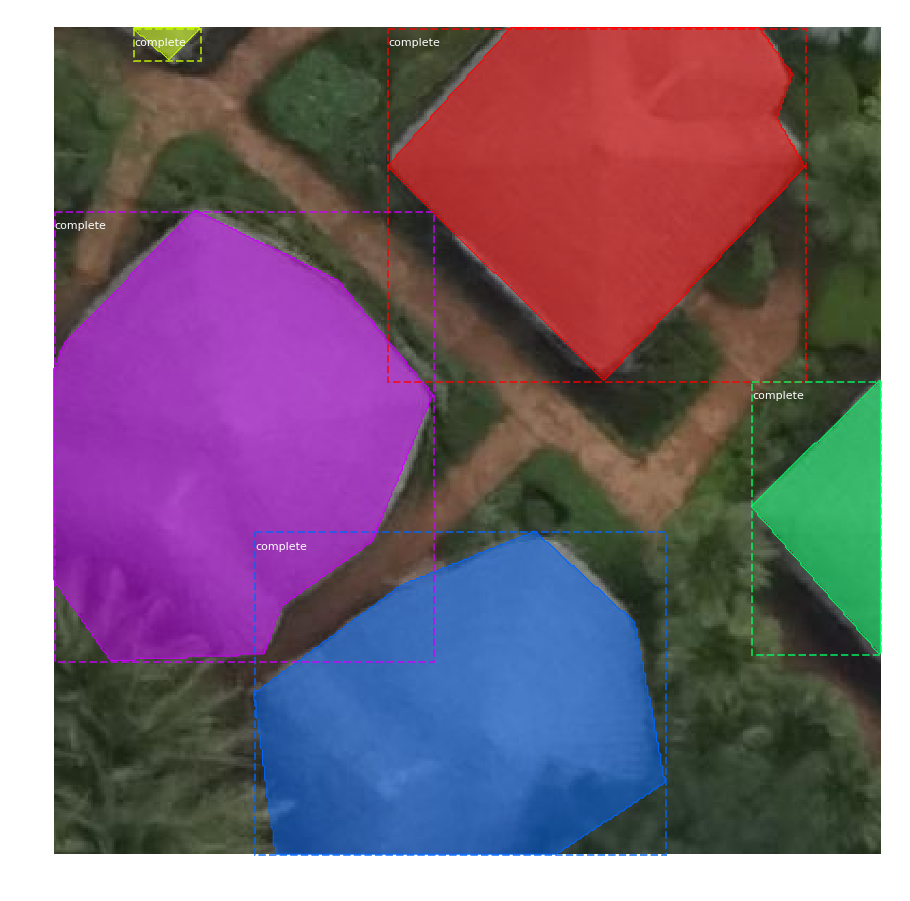

In [79]:
from mrcnn import visualize
from mrcnn.visualize import display_images
visualize.display_instances(image, gt_bbox, gt_mask, gt_class_id, val_bd.class_names,
                            show_bbox=True)

### Validation dataset

In [53]:
i = np.random.randint(len(val_bd.image_info)) ; i

183

In [54]:
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(val_bd, config, i, use_mini_mask=False)


In [55]:
info = train_bd.image_info[0]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], 0, 
                                       val_bd.image_reference(0)))

image ID: building.0 (0) 0


In [56]:
print("Original image shape: ", modellib.parse_image_meta(image_meta[np.newaxis,...])["original_image_shape"][0])

Original image shape:  [384 384   3]


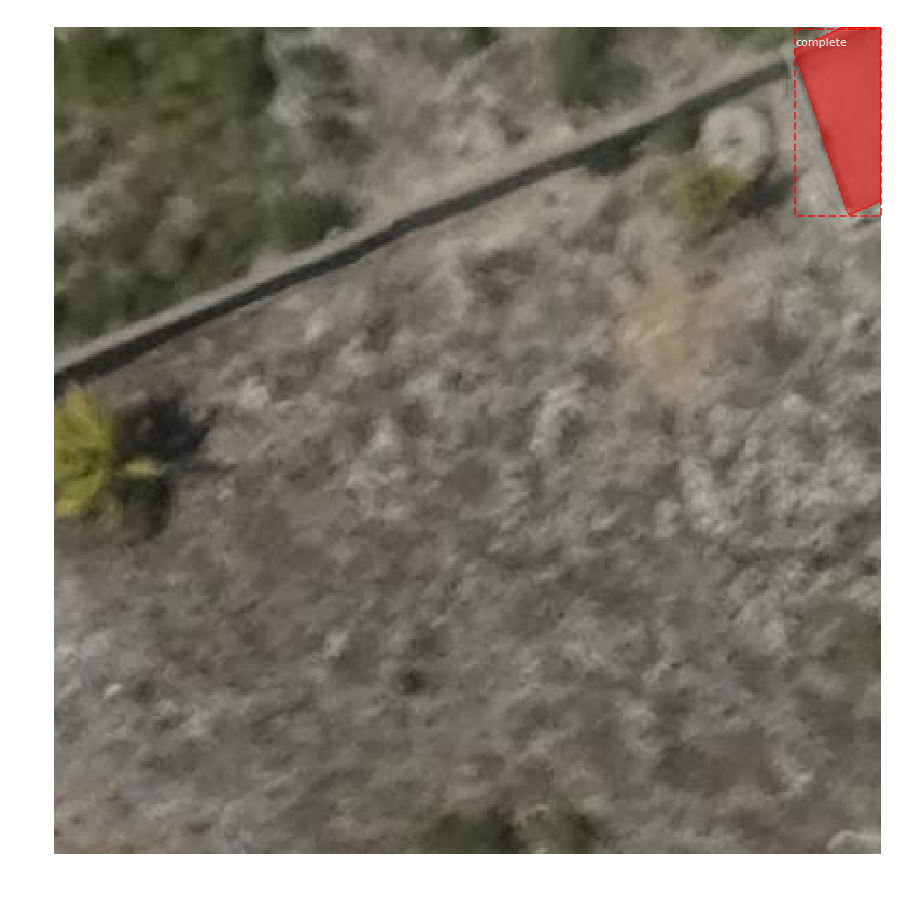

In [57]:
visualize.display_instances(image, gt_bbox, gt_mask, gt_class_id, val_bd.class_names,
                            show_bbox=True)

### Detect molded images

In [58]:
model_dir = "data/open_ai_tanzania/output/instance_segmentation/checkpoints/buildings20181017T1652/"

In [59]:
model = modellib.MaskRCNN(mode="inference", config=config,
                          model_dir=model_dir)

In [60]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    fig, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    fig.tight_layout()
    return ax

Processing 1 images
image                    shape: (384, 384, 3)         min:    1.00000  max:  196.00000  uint8
molded_images            shape: (1, 384, 384, 3)      min:    1.00000  max:  196.00000  uint8
image_metas              shape: (1, 16)               min:    0.00000  max:  384.00000  int64
anchors                  shape: (1, 36828, 4)         min:   -0.23632  max:    1.06922  float32


/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  uint8
gt_bbox                  shape: (1, 4)                min:    0.00000  max:  384.00000  int32
gt_mask                  shape: (384, 384, 1)         min:    0.00000  max:    1.00000  int8
AP @0.50:	 0.000
AP @0.55:	 0.000
AP @0.60:	 0.000
AP @0.65:	 0.000
AP @0.70:	 0.000
AP @0.75:	 0.000
AP @0.80:	 0.000
AP @0.85:	 0.000
AP @0.90:	 0.000
AP @0.95:	 0.000
AP @0.50-0.95:	 0.000


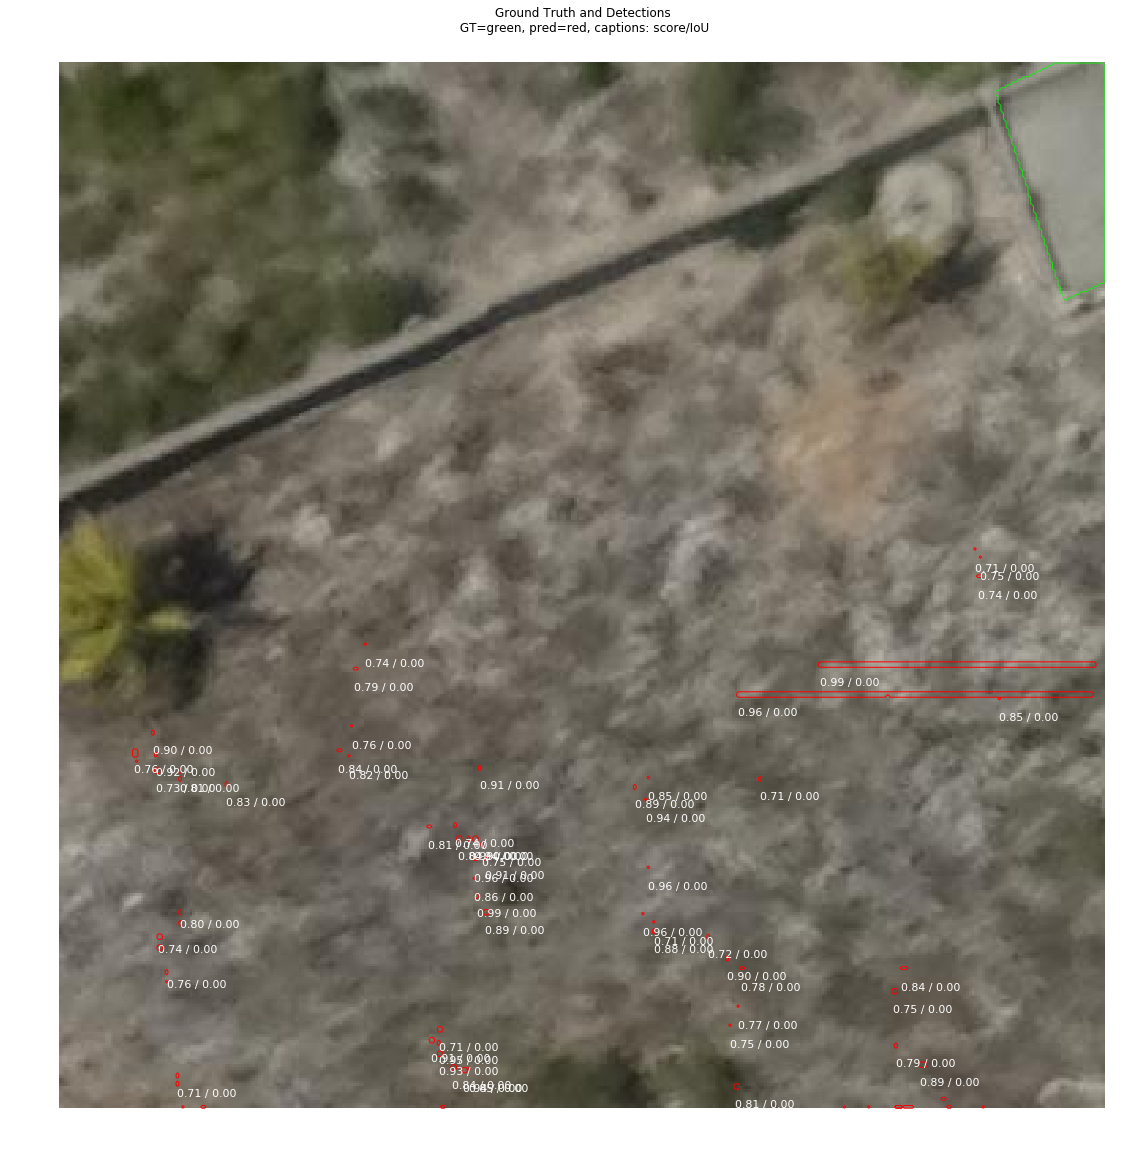

In [61]:
# Run object detection
results = model.detect_molded(np.expand_dims(image, 0), np.expand_dims(image_meta, 0), verbose=1)

# Display results
r = results[0]
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

# Compute AP over range 0.5 to 0.95 and print it
utils.compute_ap_range(gt_bbox, gt_class_id, gt_mask,
                       r['rois'], r['class_ids'], r['scores'], r['masks'],
                       verbose=1)

visualize.display_differences(
    image,
    gt_bbox, gt_class_id, gt_mask,
    r['rois'], r['class_ids'], r['scores'], r['masks'],
    val_bd.class_names, ax=get_ax(),
    show_box=False, show_mask=False,
    iou_threshold=0.5, score_threshold=0.5)